**Stochatics Processes and Simulation in Natural Sciences - Project - Riccardo Crespi & Teodoro Toscano**

# **SIMULATION OF LOTKA-VOLTERRA SYSTEM WITH SEVERAL POPULATIONS**

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from numpy.linalg import eig

This notebook presents a comprehensive numerical study of the generalized Lotka–Volterra (LV) equations, a foundational model in theoretical ecology and population dynamics. Our goal is to understand how different ecological parameters and species interactions shape long-term population behavior across communities of increasing complexity.

We begin by introducing the LV model, both mathematically and biologically, explaining the roles of self-regulation, inter-species interaction, and growth rates. From this foundation, we implement the model in Python using numerical integration and Jacobian stability analysis.

The notebook presents the following structure:

1. **Theoretical Overview**  
   A formal description of the generalized LV model, with biological interpretations of key terms and parameters.

2. **Numerical Implementation**  
   The LV model is implemented via `scipy.integrate.solve_ivp`, with accompanying functions to visualize time series, phase spaces, and analyze stability using the Jacobian matrix.

3. **Large-Scale Simulation Experiments**  
   A systematic parameter sweep is conducted, generating 20 independent random systems under varying ecological regimes (e.g., aggressive vs. natural interactions, no self-regulation). We analyze each system's dynamics, extinction count, Shannon diversity, and eigenvalue stability.

4. **Three-Species Dynamics**  
   Several examples with 3 interacting species highlight fixed points, limit cycles, extinction, invasion, and coexistence phenomena.

5. **Eight-Species Systems**  
   We scale up the analysis to 8-species networks, exploring how parameter configurations affect diversity, dominance, and long-term stability.

8. **Conclusion**  
   A summary of findings and implications for modeling real ecosystems using generalized LV frameworks.

## **THEORETICAL BACKGROUND**

The Lotka–Volterra equations are a family of nonlinear differential equations used to describe the population dynamics of biological systems in which multiple species interact. While originally developed for predator-prey systems with two species, the model has been generalized to systems with **$N%$** interacting populations.

In this project, we study the generalized Lotka–Volterra system as presented in Eq. (1) of the paper [arXiv:2302.07820](https://arxiv.org/pdf/2302.07820):

$$
\frac{d\mathbf{x}}{dt}(t) = \mathbf{x}(t) \odot \left( \mathbf{r} - (I - \Sigma)\mathbf{x}(t) \right)
$$

where:

- $ \mathbf{x}(t) = (x_1(t), x_2(t), \ldots, x_N(t)) \in \mathbb{R}^N %$ is the vector of population abundances,
- $ \mathbf{r} \in \mathbb{R}^N %$ is the vector of intrinsic growth rates,
- $ \Sigma \in \mathbb{R}^{N \times N} %$ is the interaction matrix,
- $ I %$ is the identity matrix,
- $ \odot %$ denotes the Hadamard (element-wise) product.

In component form, the equation for each species $ x_i %$ reads:

$$
\frac{dx_i}{dt} = x_i \left( r_i - x_i + \sum_{j=1}^{N} \Sigma_{ij} x_j \right), \quad \text{for } i = 1, 2, \dots, N
$$

This formulation models the population growth of each species $x_i%$ as a function of:

- Its own abundance (self-regulation),
- The effects of other species through the interaction terms $ \Sigma_{ij} %$.

The model incorporates different types of interactions commonly found in **ecological systems**:

- *Self-regulation*: Each species' own population inhibits its growth due to limited resources or space (intra-species competition). This is reflected in the term $ -x_i^2 %$, which appears when $$ \Sigma_{ii} = 0 \quad \forall i\in [N]$$ i.e., $(I - \Sigma)_{ii} = 1.$ Self-regulation ensures populations don't grow indefinitely.
- *Interspecies competition*: When two species negatively impact each other's growth (e.g., due to shared resources), the off-diagonal interaction term $$ \Sigma_{ij} < 0, \quad i\neq j.$$
- *Mutualism*: If two species benefit from one another (e.g., pollinators and flowering plants), this is captured by $$ \Sigma_{ij} > 0, $$ promoting growth.

These different types of interactions allow the model to simulate complex ecological dynamics such as:

- Stable coexistence of species,
- Periodic oscillations (limit cycles),
- Chaotic fluctuations,
- Extinction or dominance of certain populations.

While the classic two-species predator-prey model shows interesting behavior, most real ecosystems consist of **multiple interacting species**. Extending the model to $ N > 2 %$ enables us to observe:

- Multi-species coexistence and competition,
- Emergence of collective behaviors like synchronized oscillations or clustering,
- High-dimensional chaos and sensitive dependence on initial conditions,
- Invasion and extinction dynamics resulting from asymmetric interactions.

These behaviors cannot be captured by simpler two-species models and are essential for understanding biodiversity, ecosystem stability, and species interactions at scale.

## **SETTING UP THE MODEL**

The model is implemented in Python using the following tools:

- `NumPy` for numerical vector and matrix operations,
- `SciPy`’s `solve_ivp` for numerical integration of the ODE system,
- `Matplotlib` for data visualization.

The right-hand side of the differential equations is implemented as:

In [2]:
# Define the Lotka-Volterra vector field
def lotka_volterra(x, r, Sigma):
    """
    Compute dx/dt for the Lotka-Volterra system with N species.
    Args:
        x: species abundance vector
        r: growth rate vector
        Sigma: interaction matrix (NxN)
    Returns:
        dx/dt: numpy array of shape (N,)
    """
    I = np.eye(len(x))
    interaction = r - (I - Sigma) @ x
    return x * interaction  # Element-wise multiplication

To solve the system numerically, we use:

```python
sol = solve_ivp(lambda t, x: lotka_volterra(x, r, Sigma), t_span, x0, t_eval)
```

We use the RK45 method, an explicit Runge–Kutta method, because:

+    it is well-suited for non-stiff, smooth ODE systems like Lotka–Volterra;

+    it uses adaptive step size to ensure both accuracy and efficiency;

+    it is the default solver in solve_ivp, providing a good balance between generality and performance.

In cases where the system becomes stiff (e.g., due to sharp interactions or extinction thresholds), other solvers like Radau or LSODA may be considered. However, for our simulations, RK45 performs well.

The following function, `simulate_and_analyze_lv`, performs both simulation and qualitative analysis of the generalized Lotka–Volterra system for any number of species $N$.

It performs the following tasks.

1. *Numerical Integration*  

    The system is solved using `scipy.integrate.solve_ivp` with the `'RK45'` method, as analyzed before.

2. *Plotting Abundances Over Time*

    Time-series plots of species abundances $x_i​(t)$ help visualize the population dynamics and detect steady states, oscillations, or chaos.

3. *Phase-Space Visualization*

    Based on the dimension $N$:

    + For $N=2$: a 2D phase plot of $x_1$​ vs $x_2$​.
    + For $N=3$: a 3D phase-space trajectory in $(x_1,x_2,x_3)$.

4. *Total Population Plot*

    The function also plots:
    $$
        \sum_{i=1}^N x_i(t)
    $$
    to visualize collective biomass or system size over time.

5. *Extinction Detection*

    The function checks for species whose abundance drops below a threshold $10^{−3}$, identifying them as nearly extinct.

6. *Fixed Point Estimation*

    The final state $x^*=x(t_{final})$ is used as an estimate of a fixed point (which may hold in the large $t>>1$ limit, unless we have a chaotic behaviour).

7. *Jacobian Matrix Calculation*

    The Jacobian $J$ of the system at the fixed point is computed as:
    $$
    \begin{equation}
    J_{ij} = 
        \begin{cases}
        r_i -x_i^* +\sum_{k}\Sigma_{ik}x_k^* -x_i^*(1-\Sigma_{ii}) \quad \text{if }i=j \\
            -x_i^*(\delta_{ij}-\Sigma_{ij}) \quad \text{if }i\neq j
        \end{cases},
    \end{equation}
    $$
    which is implemented numerically as:
    ```python
    J[i, j] = delta * (r[i] - I[i] @ x_star + Sigma[i] @ x_star)- x_star[i] * ((I - Sigma)[i, j]).
    ```

8. *Stability Analysis*

    The function computes the eigenvalues $\lambda_i$ ​ of the Jacobian $J$ and evaluates:

    +   if $\quad Re(\lambda_i)<0 \quad \forall i$: stable fixed point;
    +   if $\quad \exists i\in[N]\quad |\quad Re(\lambda_i)>0$: unstable;
    +   for mixed/zero eigenvalues: marginal or complex dynamics.

9. *Eigenvalue Plot*

    A scatter plot showing eigenvalues in the complex plane, giving insight into the nature of the fixed point (e.g., node, focus, saddle, spiral).

In [3]:
# Define the simulation and analysis function
def simulate_and_analyze_lv(N, r, Sigma, x0, t_span, t_eval=None):
    """
    Simulate the Lotka-Volterra model and analyze the results.
    This function integrates the Lotka-Volterra equations, plots the results,
    and performs stability analysis.
    It also detects species extinction and estimates the equilibrium point.

    Args:
        N (int): Number of species.
        r (numpy.ndarray): Growth rate vector of shape (N,).
        Sigma (numpy.ndarray): Interaction matrix of shape (N, N).
        x0 (numpy.ndarray): Initial abundances of shape (N,).
        t_span (tuple): Time span for the simulation (start, end).
        t_eval (numpy.ndarray, optional): Time points to evaluate the solution.
            If None, defaults to 1000 points between t_span[0] and t_span[1].
    """

    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 1000)

    sol = solve_ivp(
        fun=lambda t, x: lotka_volterra(x, r, Sigma),
        t_span=t_span,
        y0=x0,
        t_eval=t_eval,
        method='RK45',
        vectorized=False
    )

    x = sol.y
    t = sol.t

    # --- Plot abundances over time ---
    plt.figure(figsize=(10, 6))
    for i in range(N):
        plt.plot(t, x[i], label=f'Species {i+1}')
    plt.xlabel("Time")
    plt.ylabel("Abundance")
    plt.title("Species Abundances Over Time")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Phase Space Plots ---
    if N == 2:
        plt.figure()
        plt.plot(x[0], x[1])
        plt.xlabel("Species 1")
        plt.ylabel("Species 2")
        plt.title("Phase Space (Species 1 vs Species 2)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    elif N == 3:
        from mpl_toolkits.mplot3d import Axes3D
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(x[0], x[1], x[2])
        ax.set_xlabel('Species 1')
        ax.set_ylabel('Species 2')
        ax.set_zlabel('Species 3')
        ax.set_title('3D Phase Space (Species 1, 2, 3)')
        plt.tight_layout()
        plt.show()

    # --- Total population over time ---
    total_pop = np.sum(x, axis=0)
    plt.figure()
    plt.plot(t, total_pop)
    plt.xlabel("Time")
    plt.ylabel("Total Population")
    plt.title("Total Population Over Time")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # --- Detect Species Extinction ---
    extinct_species = [i+1 for i in range(N) if np.min(x[i]) < 1e-3]
    if extinct_species:
        print("Extinct or nearly extinct species (abundance < 1e-3):", extinct_species)
    else:
        print("No species went extinct.")

    # --- Estimate Equilibrium ---
    x_star = x[:, -1]
    print("Estimated Fixed Point (last state):", x_star)

    J = np.zeros((N, N))
    I = np.eye(N)
    for i in range(N):
        for j in range(N):
            delta = 1 if i == j else 0
            J[i, j] = delta * (r[i] - I[i] @ x_star + Sigma[i] @ x_star) - x_star[i] * ((I - Sigma)[i, j])

    eigvals = eig(J)[0]
    print("Jacobian Eigenvalues at Fixed Point:", eigvals)

    if np.all(np.real(eigvals) < 0):
        print("Stable fixed point (all eigenvalues have negative real parts).")
    elif np.any(np.real(eigvals) > 0):
        print("Unstable fixed point (some eigenvalues have positive real parts).")
    else:
        print("Marginally stable or complex behavior.")

    # --- Plot Eigenvalues ---
    plt.figure()
    plt.scatter(np.real(eigvals), np.imag(eigvals), marker='x', color='red')
    plt.axvline(0, color='black', linestyle='--')
    plt.xlabel("Real Part")
    plt.ylabel("Imaginary Part")
    plt.title("Eigenvalues of Jacobian at Equilibrium")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [4]:
def plot_colored_phase_space(N, r, Sigma, x0, t_span, t_eval=None):
    """
    Plot the phase space of the Lotka-Volterra model with N species,
    colored by the abundance of the last species.
    This function integrates the Lotka-Volterra equations and visualizes
    the results in a 2D or 3D phase space plot, depending on the number of species.

    Args:
        N (int): Number of species.
        r (numpy.ndarray): Growth rate vector of shape (N,).
        Sigma (numpy.ndarray): Interaction matrix of shape (N, N).
        x0 (numpy.ndarray): Initial abundances of shape (N,).
        t_span (tuple): Time span for the simulation (start, end).
        t_eval (numpy.ndarray, optional): Time points to evaluate the solution.
            If None, defaults to 2000 points between t_span[0] and t_span[1].
    """
    if t_eval is None:
        t_eval = np.linspace(*t_span, 2000)

    sol = solve_ivp(
        lambda t, x: lotka_volterra(x, r, Sigma),
        t_span=t_span,
        y0=x0,
        t_eval=t_eval,
        method='RK45'
    )
    
    X = np.clip(sol.y, 0, None)  # Clip negative values for realism

    if N == 3:
        x1, x2, x3 = X[0], X[1], X[2]
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(x1, x2, c=x3, cmap='viridis', s=1)
        plt.xlabel('Species 1 (x₁)')
        plt.ylabel('Species 2 (x₂)')
        cbar = plt.colorbar(scatter)
        cbar.set_label('Species 3 (x₃)')
        plt.title('Phase Space: x₁ vs x₂ colored by x₃')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    elif N == 4:
        x1, x2, x3, x4 = X[0], X[1], X[2], X[3]
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        p = ax.scatter(x1, x2, x3, c=x4, cmap='plasma', s=2)
        ax.set_xlabel('Species 1 (x₁)')
        ax.set_ylabel('Species 2 (x₂)')
        ax.set_zlabel('Species 3 (x₃)')
        fig.colorbar(p, label='Species 4 (x₄)')
        ax.set_title('3D Phase Space: x₁–x₃ colored by x₄')
        plt.tight_layout()
        plt.show()
    else:
        print("This visualization supports only N = 3 or N = 4.")

In [5]:
def compute_jacobian(x, r, Sigma):
    """
    Compute the Jacobian matrix at the given state for the system:
        dx_N/dt(t) = x_N(t) ⊙ (r_N - (I_N - Σ_N) x_N(t))
    """
    
    N = len(x)
    J = np.zeros((N, N))
    I = np.eye(N)
    
    for i in range(N):
        for j in range(N):
            if i == j:
                # Derivative with respect to the same species
                # d/dx_j [x_i * (r_i - sum_k (I_ik - Sigma_ik) * x_k)]
                J[i, j] = r[i] - (I[i, j] - Sigma[i, j]) * x[i] - np.sum((I[i, :] - Sigma[i, :]) * x)
            else:
                # Derivative with respect to different species
                J[i, j] = -(I[i, j] - Sigma[i, j]) * x[i]
    
    return J

To explore the diversity of possible outcomes in multi-species ecological systems, we define a function that generates **multiple random simulations** of the generalized Lotka–Volterra (LV) model. This allows us to observe the emergence of different behaviors — from extinction and stability to coexistence and chaos — based on randomized biological parameters.

`generate_lv_trajectories` simulates and plots several realizations of $ N $-species Lotka–Volterra dynamics, each with randomly generated parameters and initial conditions.

For each sample, the funtion performs the fololwing tasks:

1. Randomly generates:
   - Growth rates $ \mathbf{r} $,
   - Interaction matrix $ \Sigma $ with controlled self-regulation,
   - Initial conditions $ \mathbf{x}_0 $.

2. Solves the LV system:
   $$
   \frac{dx_i}{dt} = x_i(t) \left( r_i - x_i(t) + \sum_j \Sigma_{ij} x_j(t) \right).
    $$

3. Analyzes the dynamics:
   - Counts extinct species,
   - Computes Shannon entropy of final abundances (diversity),
   - Calculates the Jacobian matrix at the final state,
   - Extracts the maximum real part of the eigenvalues $ \lambda $ to determine stability.

4. Plots the time evolution of all species abundances in a grid of subplots.

The **Shannon diversity index**, also known as Shannon entropy, is a classical metric used to quantify the diversity of a community. Originally introduced in information theory, it has been widely adopted in ecology to measure species richness and evenness within an ecosystem.

Given a set of $ N $ species with relative abundances $ p_1, p_2, \ldots, p_N $, the Shannon index is defined as:

$$
H = -\sum_{i=1}^{N} p_i \log p_i,
$$

where:
- $ p_i = \frac{x_i}{\sum_{j=1}^{N} x_j} $ is the relative abundance of species $ i $,
- $ x_i $ is the absolute abundance (population) of species $ i $,
- The logarithm is typically taken base $ e $ (natural log), giving units in "nats".

To avoid numerical errors with $ \log(0) $, a small epsilon $ \varepsilon \ll 1 $ is often added:
$$
p_i = \frac{x_i + \varepsilon}{\sum_j (x_j + \varepsilon)}.
$$

Biologically speaking, we can interprete the Shannon measure as follows:

- $ H = 0 $ when there is only one surviving species (no diversity).
- $ H $ is maximized when all species have equal abundances, indicating maximum evenness.
- **Higher values of $ H $** indicate more **balanced ecosystems** — both rich in species and uniform in their distribution.

In dynamical models like Lotka–Volterra systems, species abundances can shift dramatically over time. The Shannon index serves as a compressed snapshot of the long-term outcome of a simulation — letting us track whether systems stabilize into diverse coexistence or collapse into domination/extinction scenarios.


In [6]:
def generate_lv_trajectories(r_set= [0.5, 1.0], S_set= [-0.5, 0.5], diag_set= [0.2, 0.8], x0_set= [0.1, 0.5],
                             num_samples=20, N=3, t_span=(0, 100.0), t_eval=None, extinction_threshold=0.01):
    """
    Generate and plot Lotka-Volterra trajectories for N species with random parameters.
    This function simulates the Lotka-Volterra equations for a range of random parameters,
    and visualizes the results in a grid of subplots.
    It also performs stability analysis and computes the Shannon diversity index.

    Args:
        r_set (list): Range for growth rates [min, max]. Default is [0.5, 1.0].
        S_set (list): Range for interaction strengths [min, max]. Default is [-0.5, 0.5].
        diag_set (list): Range for diagonal elements of Sigma [min, max]. Default is [0.2, 0.8].
        x0_set (list): Range for initial abundances [min, max]. Default is [0.1, 0.5].
        num_samples (int): Number of random samples to generate. Default is 20.
        N (int): Number of species. Default is 3.
        t_span (tuple): Time span for the simulation (start, end). Default is (0, 100.0).
        t_eval (numpy.ndarray, optional): Time points to evaluate the solution.
            If None, defaults to 500 points between t_span[0] and t_span[1].
        extinction_threshold (float): Threshold for species extinction. Default is 0.01.
    """
    
    if t_eval is None:
        t_eval = np.linspace(t_span[0], t_span[1], 500)
    
    fig, axes = plt.subplots(5, 4, figsize=(20, 25))
    axes = axes.flatten()
    species_colors = [
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
    ][:N]  # Slice to N species
    
    np.random.seed(42)  # For reproducibility
    
    for i in range(num_samples):
        # Random biologically plausible parameters
        r = np.random.uniform(r_set[0], r_set[1], size=N)
        
        # Create interaction matrix Sigma
        # For this formulation, we need different constraints
        # Sigma represents facilitation/inhibition effects
        Sigma = np.random.uniform(S_set[0], S_set[1], size=(N, N))
        
        # Set diagonal elements to higher positive values (self-regulation)
        np.fill_diagonal(Sigma, np.random.uniform(diag_set[0], diag_set[1], size=N))
        
        # Initial population sizes
        x0 = np.random.uniform(x0_set[0], x0_set[1], size=N)
        
        # Simulate trajectories with tighter error control
        try:
            sol = solve_ivp(fun=lambda t, x: lotka_volterra(x, r, Sigma),
                          t_span=t_span, y0=x0, t_eval=t_eval, method='RK45', 
                          rtol=1e-6, atol=1e-9, max_step=0.01)
            
            x = sol.y
            t = sol.t
            
            # Compute insights for the final state
            x_final = x[:, -1]
            extinct = x_final < extinction_threshold
            extinct_count = np.sum(extinct)
            
            # Shannon diversity index (handle edge cases)
            epsilon = 1e-10
            total = np.sum(x_final) + epsilon * N
            p = (x_final + epsilon) / total
            shannon = -np.sum(p * np.log(p))
            
            # Stability analysis (Jacobian eigenvalues)
            J = compute_jacobian(x_final, r, Sigma)
            eigvals = np.linalg.eigvals(J)
            max_real_eig = np.max(np.real(eigvals))
            is_stable = "Stable" if max_real_eig < 0 else "Unstable"
            title_color = 'green' if max_real_eig < 0 else 'red'
            
            # Plot trajectories
            ax = axes[i]
            for j in range(N):
                ax.plot(t, x[j], color=species_colors[j], label=f"S{j+1}" if i == 0 else "")
            
            ax.set_title(f"Sample {i+1} ({is_stable})", color=title_color)
            ax.set_xlabel("Time")
            ax.set_ylabel("Abundance")
            ax.grid(True, alpha=0.3)
            
            # Add annotations
            ax.text(0.05, 0.85, 
                   f"Extinct: {extinct_count}\nShannon H: {shannon:.2f}\nMax Re(λ): {max_real_eig:.2f}",
                   transform=ax.transAxes, fontsize=9, 
                   bbox=dict(facecolor='white', alpha=0.8))
        
        except Exception as e:
            axes[i].text(0.5, 0.5, f"Error in simulation {i+1}:\n{str(e)}", 
                         ha='center', va='center', color='red')
            axes[i].set_title(f"Sample {i+1} (Failed)", color='red')
    
    # Add a global legend using the first subplot
    axes[0].legend(loc='upper right', framealpha=0.9)
    plt.tight_layout()
    #i want x axis to be 1000
    plt.xlim(t_span[0], t_span[1])
    plt.show()


## **LOTKA-VOLTERRA SIMULATIONS IN A 3D SPACE**

#### **Natural-Like Parameters**

This panel presents 20 independent simulations of 3-species Lotka–Volterra systems. Each sample uses:

- Growth rates $ r_i \sim \mathcal{U}(0.5, 1.0) $,
- Interaction strengths $ \Sigma_{ij} \sim \mathcal{U}(-0.5, 0.5) $, with moderate self-regulation,
- Initial abundances $ x_i(0) \sim \mathcal{U}(0.1, 0.5) $,
- Simulated over a time horizon of 100 units.

General observations:

- Stability dominates: Most systems converge to stable equilibria where all or some species persist, consistent with expected behavior for moderate interaction strengths and positive growth.
- Low extinction rates: Many systems show zero or one extinction, with several supporting full coexistence of all three species.
- Diversity varies: Shannon entropy values reflect a range of outcomes:
  - High diversity when abundances are balanced (e.g., Samples 1, 5, 16),
  - Low diversity in competitive exclusion scenarios (e.g., Sample 4).

Sample 15 (Unstable) stands out: characterized by positive real eigenvalues and explosive growth, indicating a destabilized ecosystem — possibly due to cooperative loops or insufficient self-regulation.

This simulation suite confirms that:
- Stable coexistence is frequent under “natural” parameter regimes,
- Parameter sensitivity plays a major role: small changes in growth or interaction can shift a system from stable to extinct or chaotic,
- The Jacobian spectrum is an informative tool: stability correlates strongly with $ \max Re(\lambda) < 0 $.

These results validate the model's capacity to represent rich ecological outcomes — from equilibrium to collapse — and underscore the role of structure and regulation in supporting biodiversity.

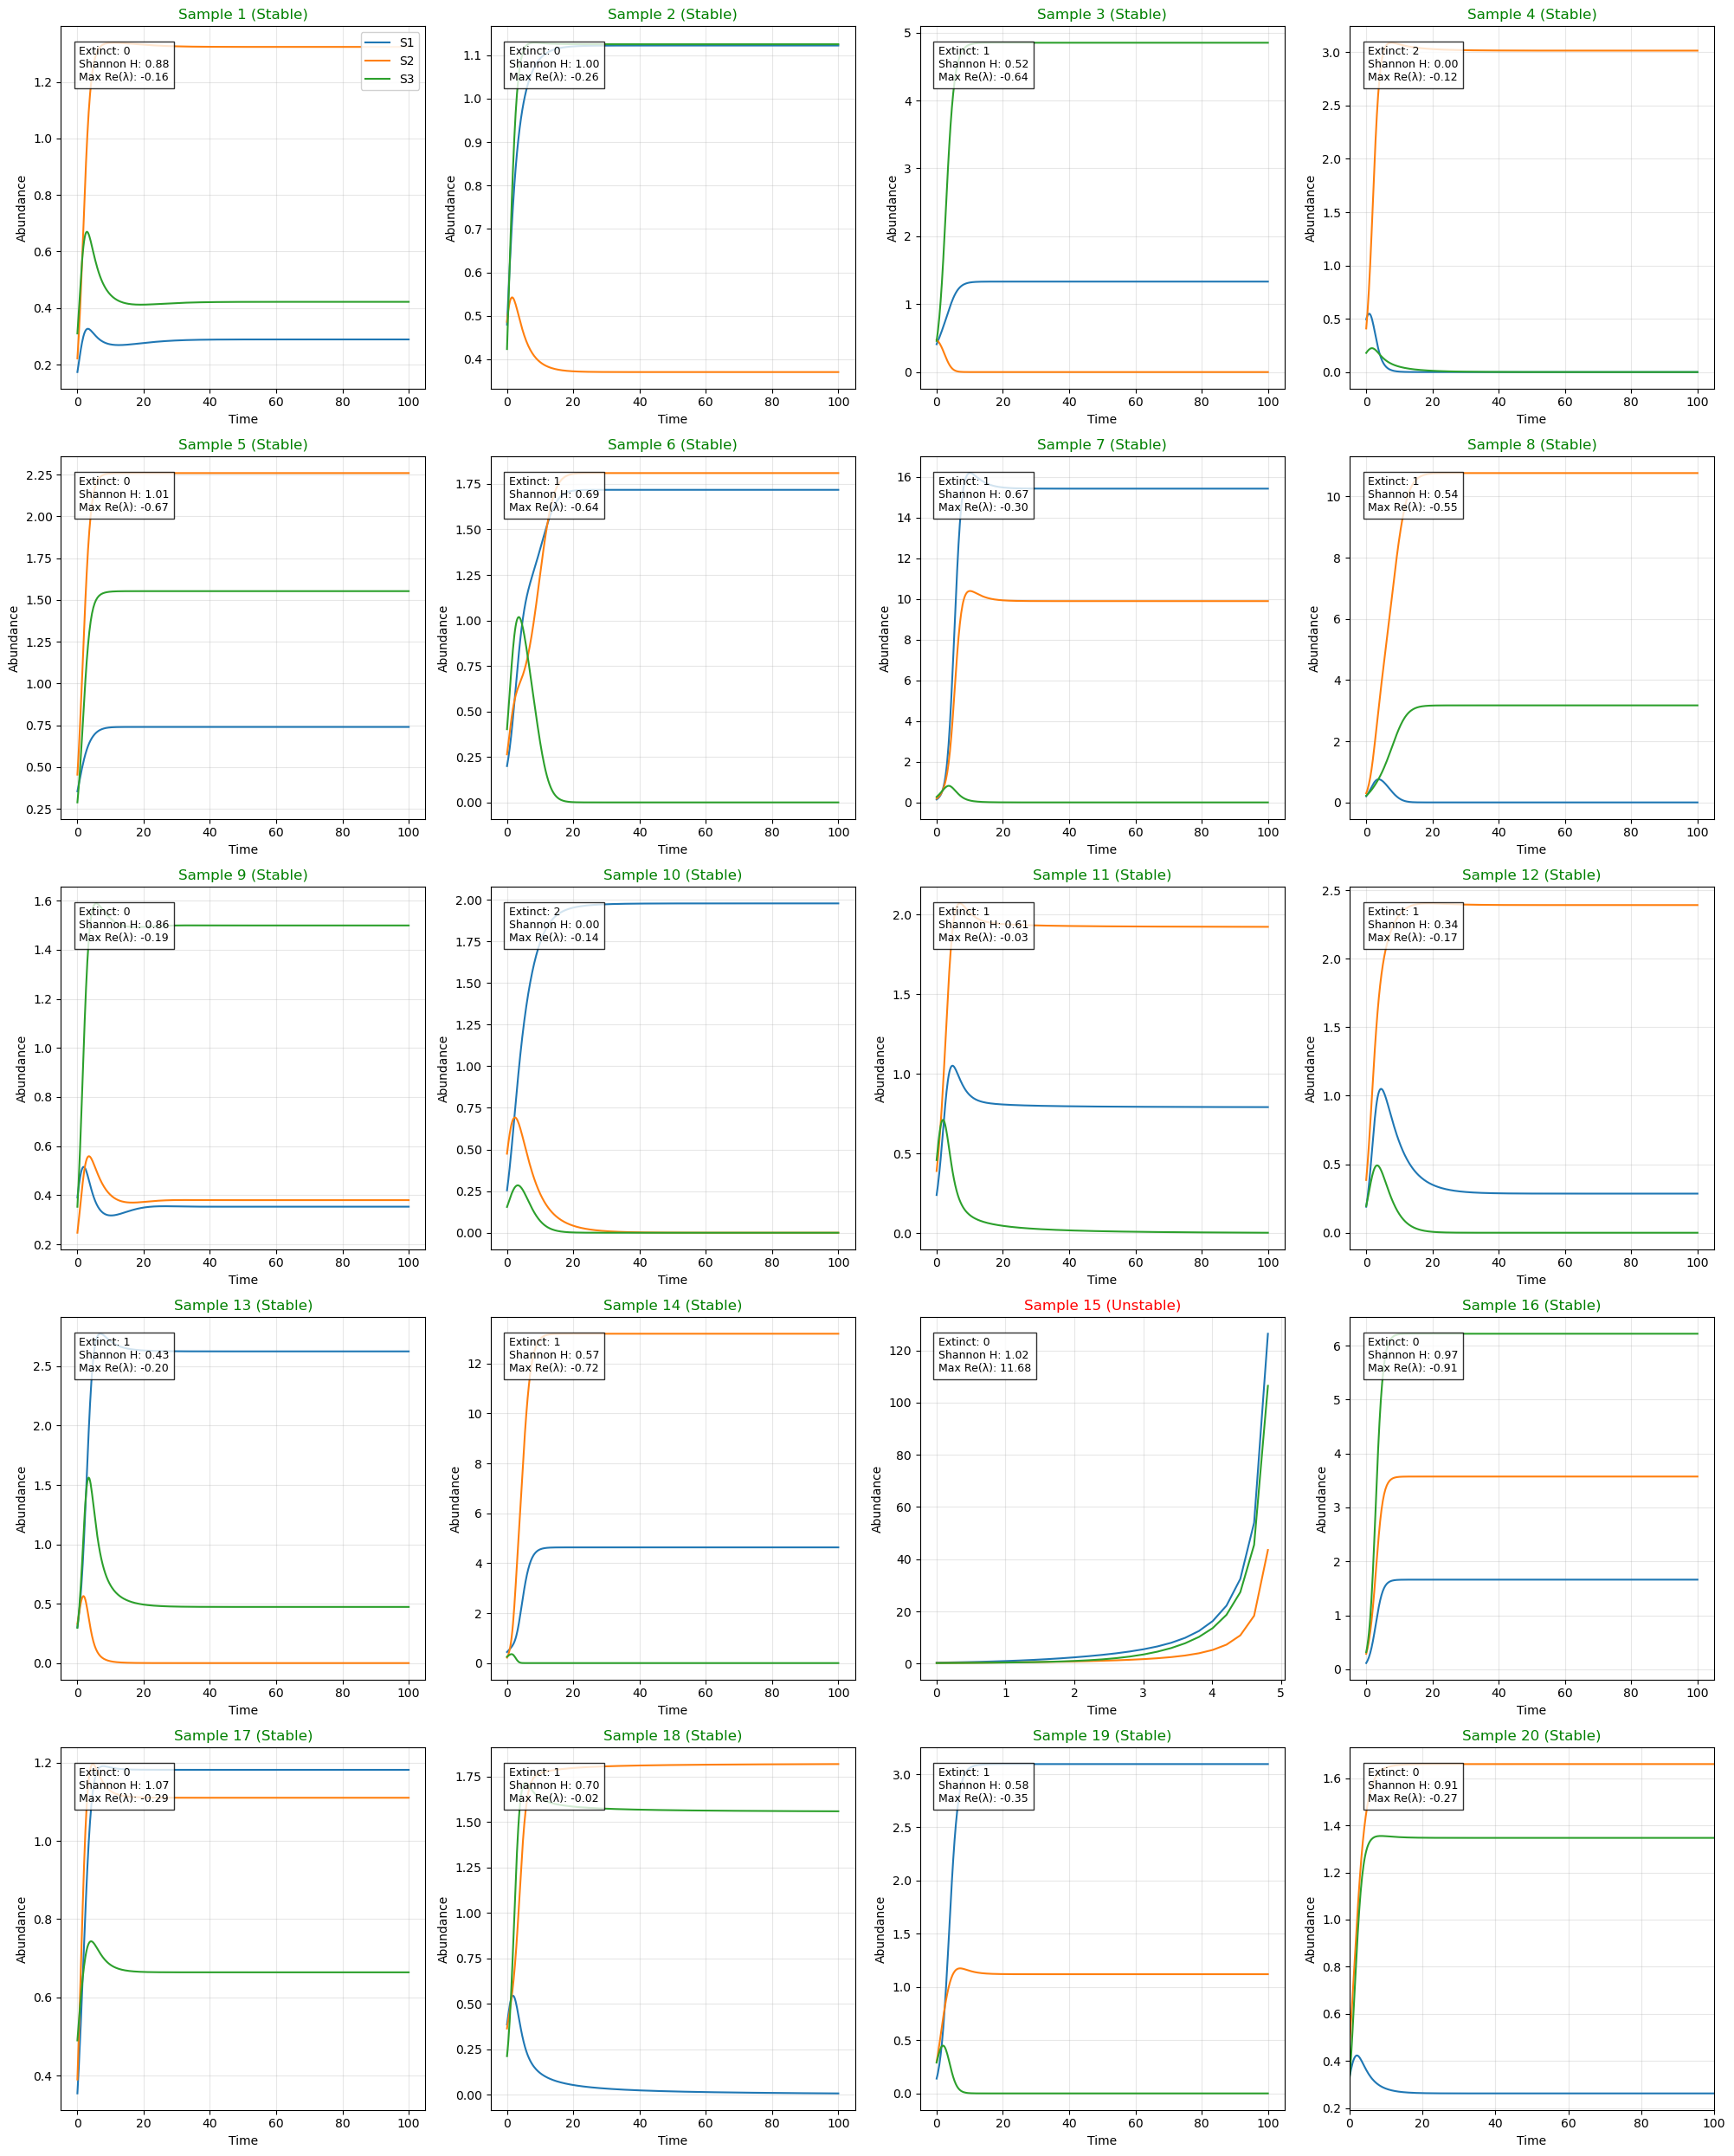

In [7]:
generate_lv_trajectories()

#### **Aggressive Interactions**

In this second experiment, we investigate how **amplifying inter-species interactions** impacts the stability of ecological systems. We increase the range of off-diagonal values in the interaction matrix, simulating ecosystems with stronger competition or facilitation.

Key Observations:

- **Increased instability**: 5 out of 20 simulations are labeled as unstable due to positive real parts in the Jacobian's eigenvalues. In these cases, populations diverge rapidly, often within the first few units of time.
- Explosive growth: Some unstable systems show biologically unrealistic outcomes — exponential growth without bound — highlighting the limits of unregulated facilitation or cooperation.
- Early extinction events are frequent, with many samples showing 1 or 2 extinct species due to harsh competition or strong negative interactions.
- Stable outcomes still appear, indicating that self-regulation and balanced interactions can mitigate instability even in high-variance conditions.

This setting models ecosystems where:
- Species interactions are intense, such as hyper-competitive environments,
- Positive feedback loops are possible, causing runaway growth or sudden extinctions,
- Even small differences in initial conditions or interaction asymmetries can amplify dramatically over time.

These simulations emphasize the fragility of ecological balance in systems with unmoderated interaction strengths and show how small structural changes in $ \Sigma $ can flip a system from stable to chaotic.

This experiment reinforces a key ecological insight: stability is not just about species traits, but about the structure and symmetry of their interactions.


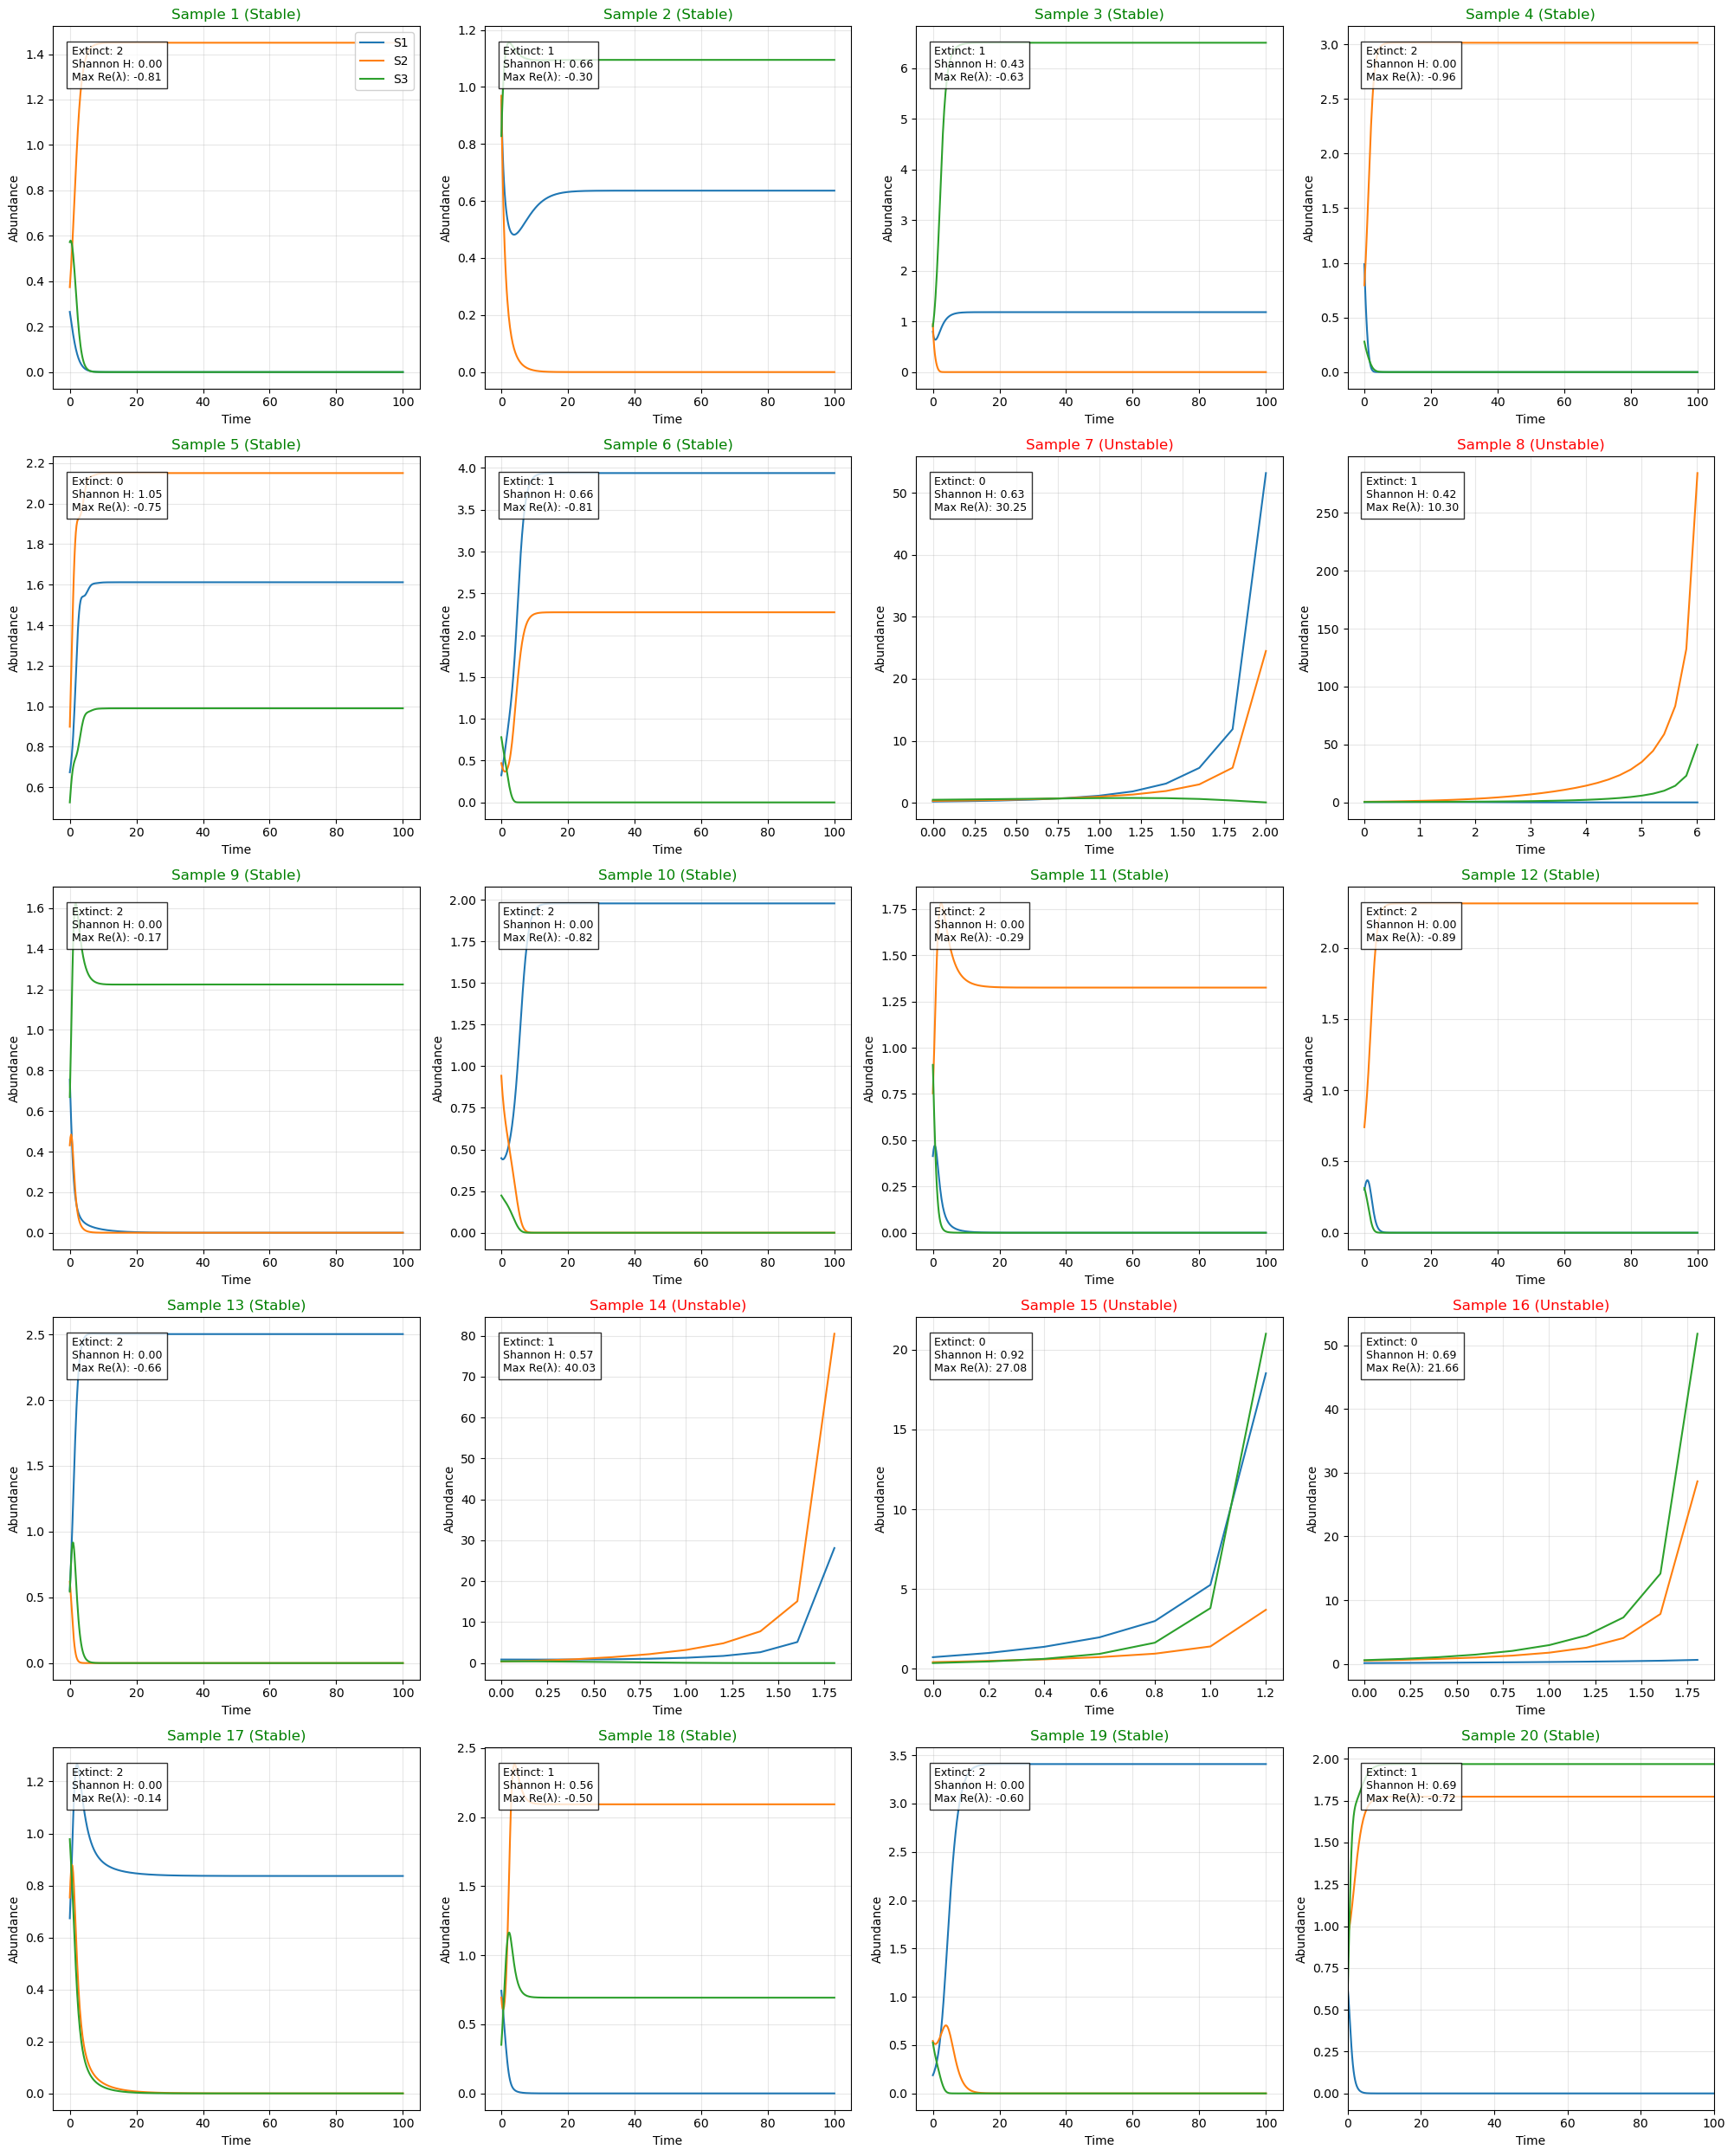

In [8]:
r_set = [0.5, 1.0]
S_set = [-1.5, 1.5]
diag_set = [0.2, 0.8]
x0_set = [0.1, 1]

generate_lv_trajectories(r_set=r_set, S_set=S_set, diag_set=diag_set, x0_set=x0_set)

#### **Increased Growth Rates**

In this configuration, we explore the effect of **higher intrinsic growth rates** on the dynamics of 3-species Lotka–Volterra systems. The key question is:
*How does increasing $ r_i $ — the natural reproductive capacity of species — influence stability, extinction, and diversity?*

Qualitative results:

- Stability dominates: 19 out of 20 samples remain stable despite the more rapid population growth. This suggests that self-regulation and balanced interactions continue to play a stabilizing role even under faster dynamics.
- Saturation patterns emerge: Many species reach high abundance quickly and stabilize. These resemble logistic-like saturations typical in ecological models with strong intrinsic growth.
- Extinction is common, despite high $ r_i $: Strong initial competition can still drive populations to extinction before growth compensates. Most plots feature 1 extinct species.
- Shannon index ranges from low to moderate, reflecting a typical tradeoff:
  - Rapid domination by one species often suppresses diversity,
  - Few cases achieve high evenness or coexistence.

Thus, we see that systems with fast-growing species are not necessarily unstable. What matters more is the structure of interaction — especially competition and regulation.
High growth rates can accelerate convergence but also exacerbate exclusion, especially when competitive interactions are asymmetric.
Early extinction windows shrink: small differences in $ x_0 $ or $ \Sigma $ can lead to permanent loss before growth takes effect.


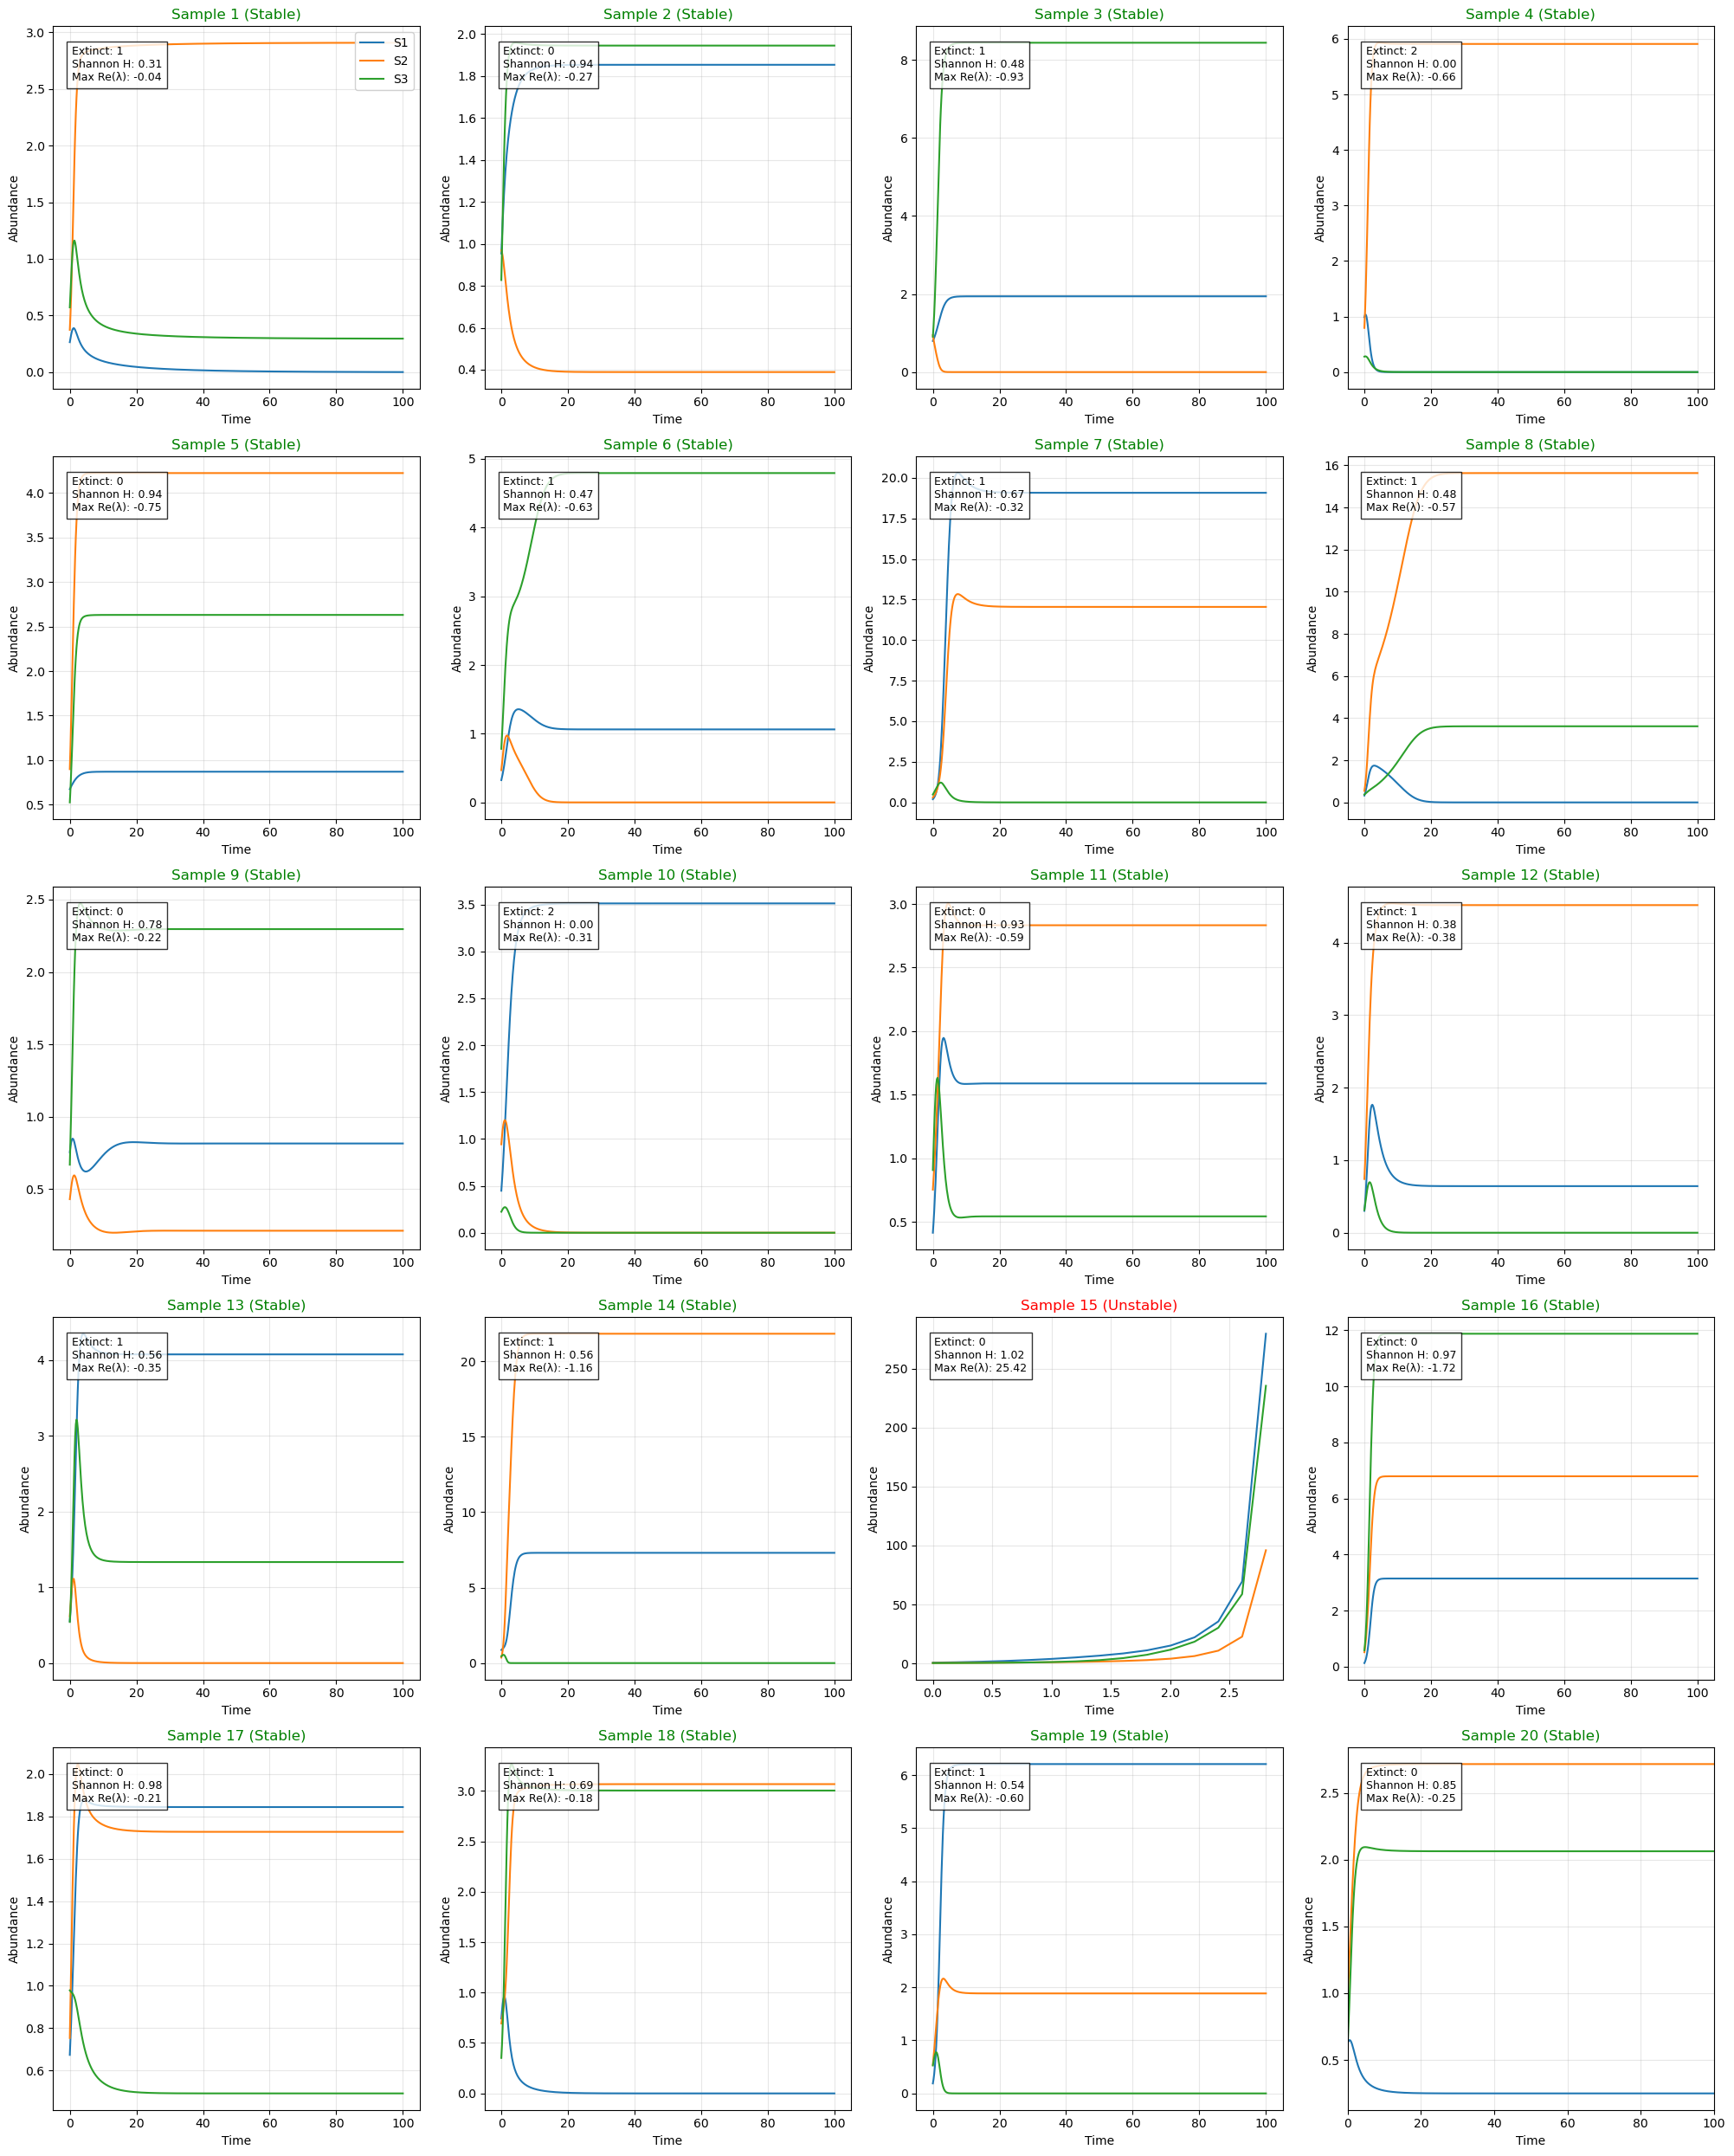

In [9]:
r_set = [0.5, 2.0]
S_set = [-0.5, 0.5]
diag_set = [0.2, 0.8]
x0_set = [0.1, 1]

generate_lv_trajectories(r_set=r_set, S_set=S_set, diag_set=diag_set, x0_set=x0_set, num_samples=20)

#### **High Growth Rate and Aggressive Behaviour**

In this simulation regime, we push the Lotka–Volterra system into an extreme dynamical corner, whicch captures **highly volatile ecosystems**, where population dynamics are shaped by both explosive intrinsic tendencies and intense mutual interactions — mimicking ecosystems on the brink of collapse or runaway success.

Simulation Outcomes

- Significant instability: 5 out of 20 simulations are labeled as unstable, showing divergence or rapid unbounded growth.
- Explosive dynamics: In several unstable plots, populations spike exponentially within a few units of time, a hallmark of systems dominated by positive feedback loops or insufficient self-damping.
- Rare coexistence: Although many systems retain all species, coexistence is fragile and often temporary.

From an ecological viewpoint, this reinforces that aggressive growth must be tightly regulated to maintain biodiversity and avoid systemic collapse.

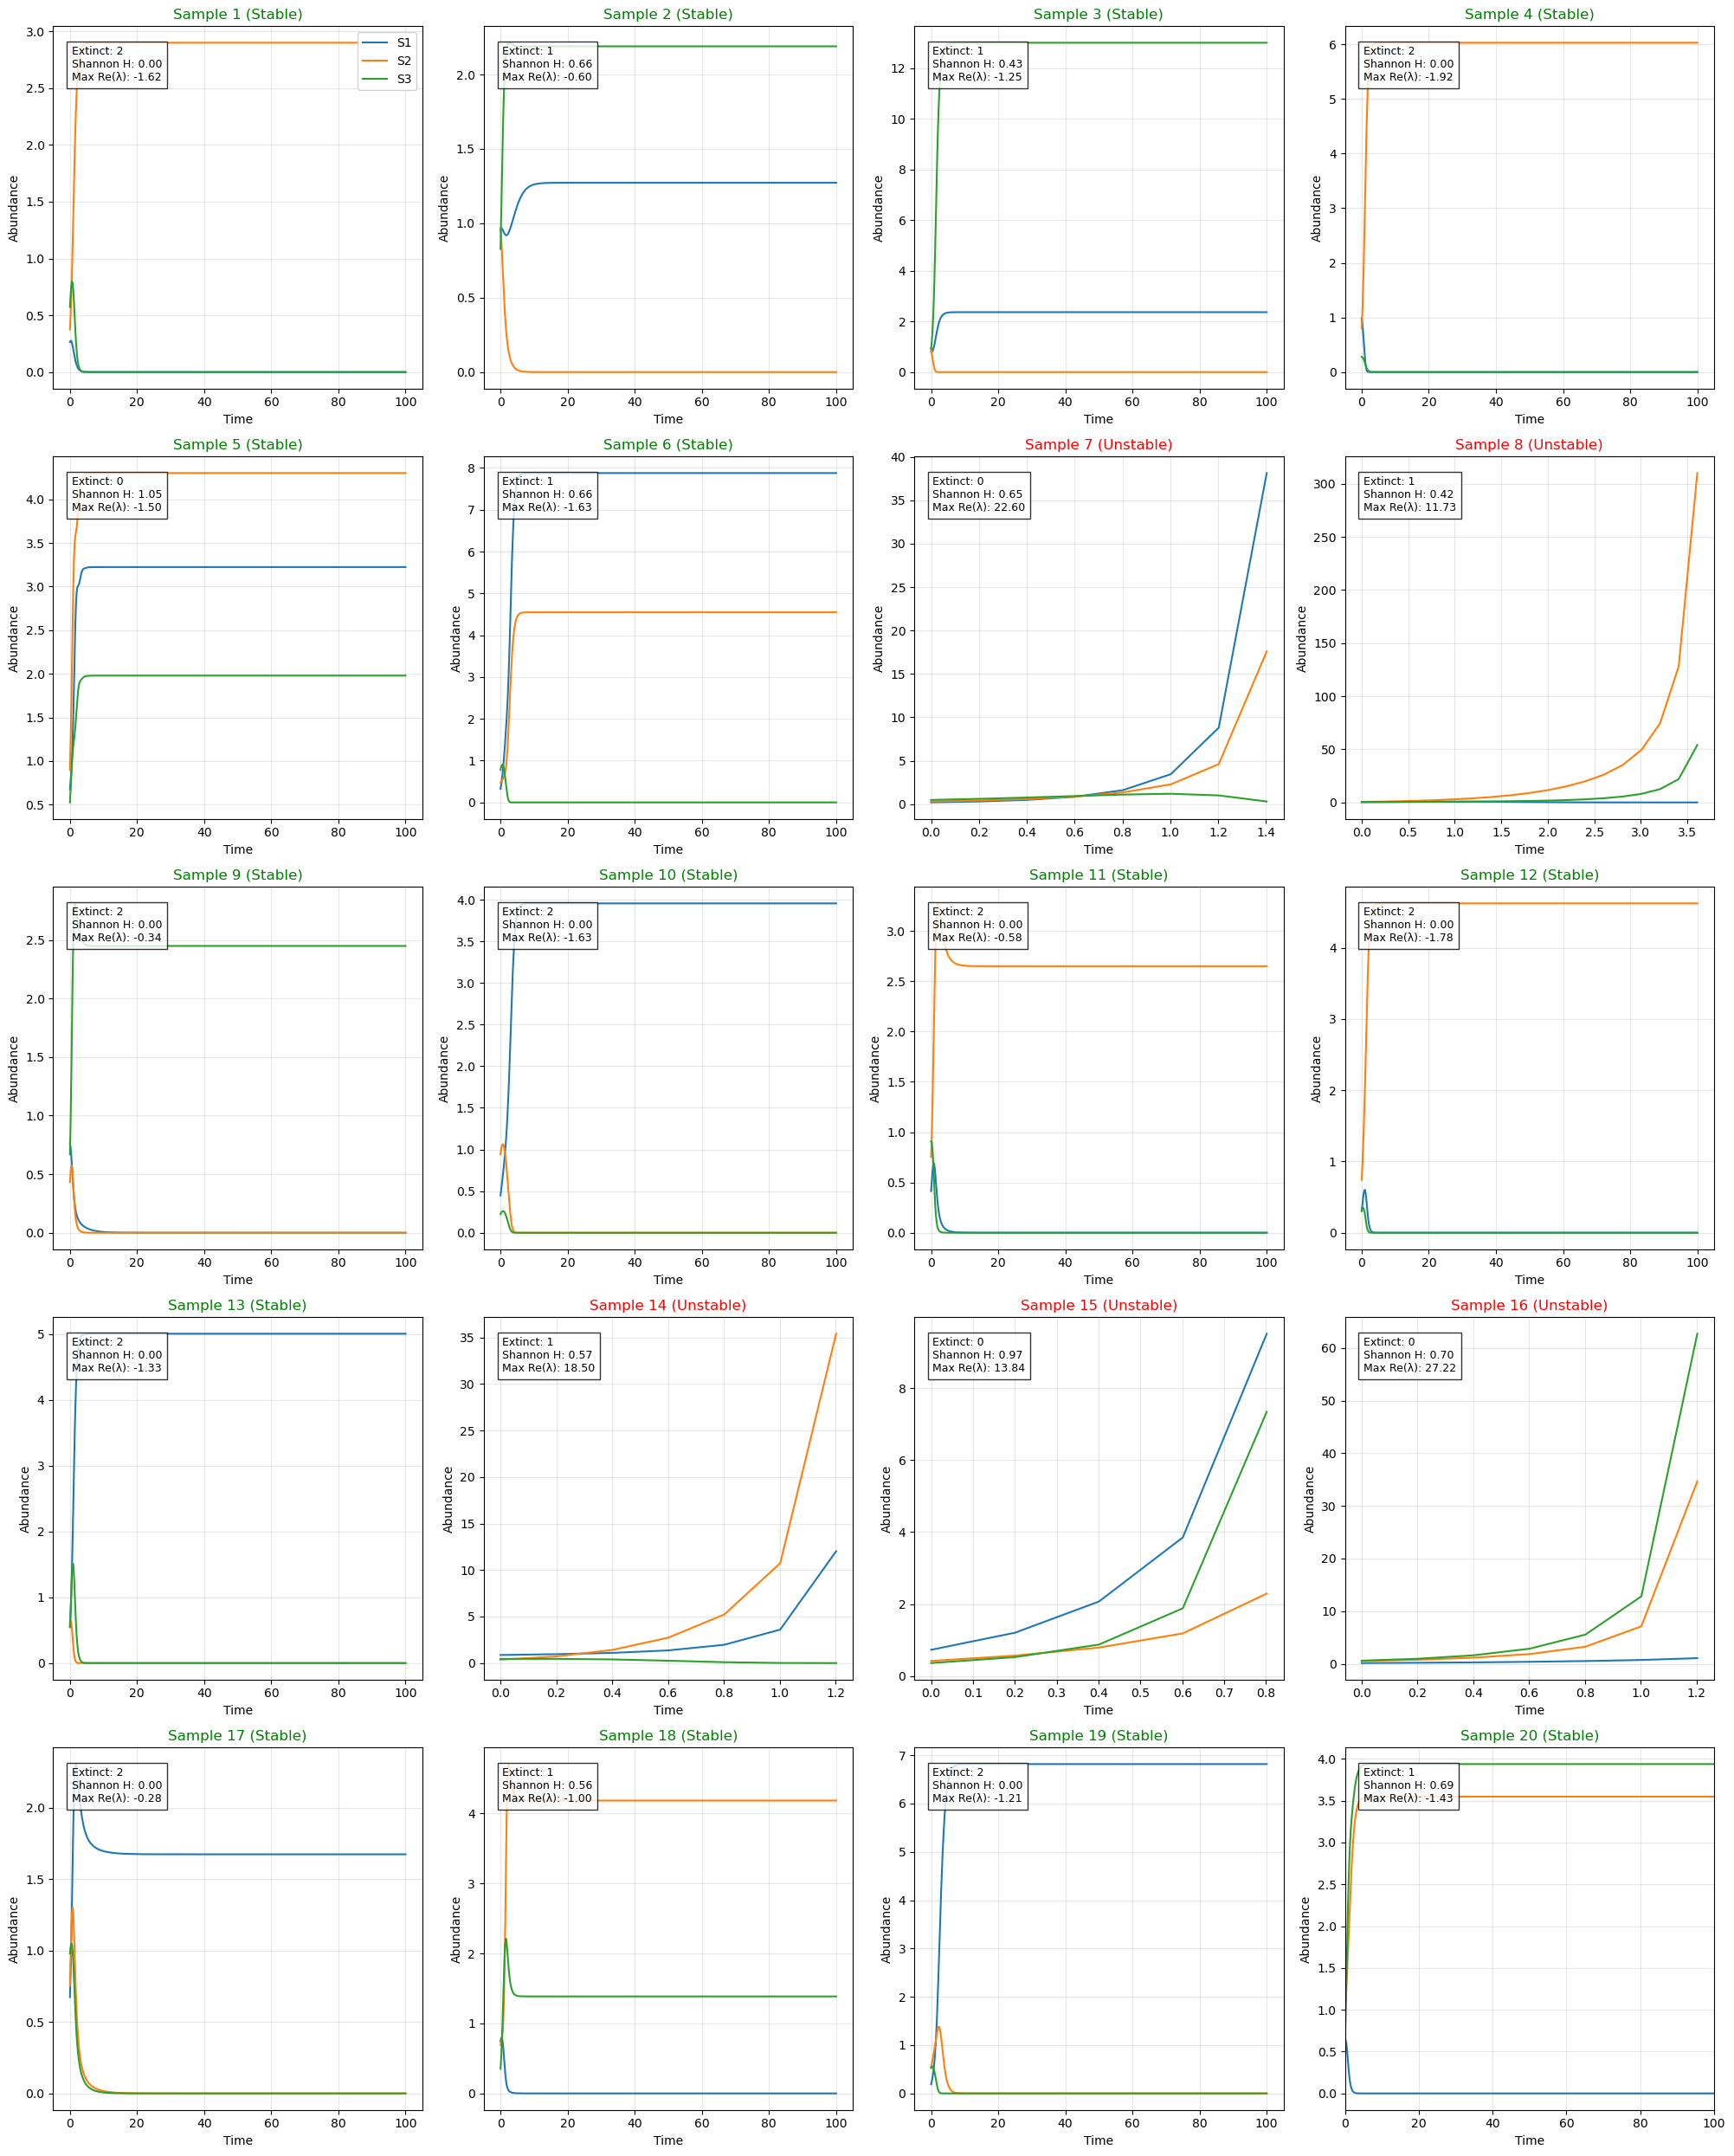

In [10]:
r_set = [1.0, 2.0]
S_set = [-1.5, 1.5]
diag_set = [0.2, 0.8]
x0_set = [0.1, 1]
generate_lv_trajectories(r_set=r_set, S_set=S_set, diag_set=diag_set, x0_set=x0_set, num_samples=20)

#### **Dynamics without Self-Regulation**

In this final scenario, we investigate the effect of **removing intraspecies self-regulation** in Lotka–Volterra systems. This corresponds to setting the diagonal elements of the interaction matrix:
$$ 
\Sigma_{ii} \sim \mathcal{U}(0.99, 1.0),
$$
approximating zero self-damping.

Extreme instability dominates: a significant number of simulations show rapid, unbounded population explosions, even reaching **biological implausibility**, sicne we witness populations reaching unrealistic abundances (e.g., > 1000), demonstrating that self-regulation is essential to maintaining ecological realism.


Self-regulation is not just a mathematical tweak — it's a cornerstone of biological realism. This simulation highlights that even moderate interaction networks become catastrophically unstable when species lack intrinsic constraints on their own growth.

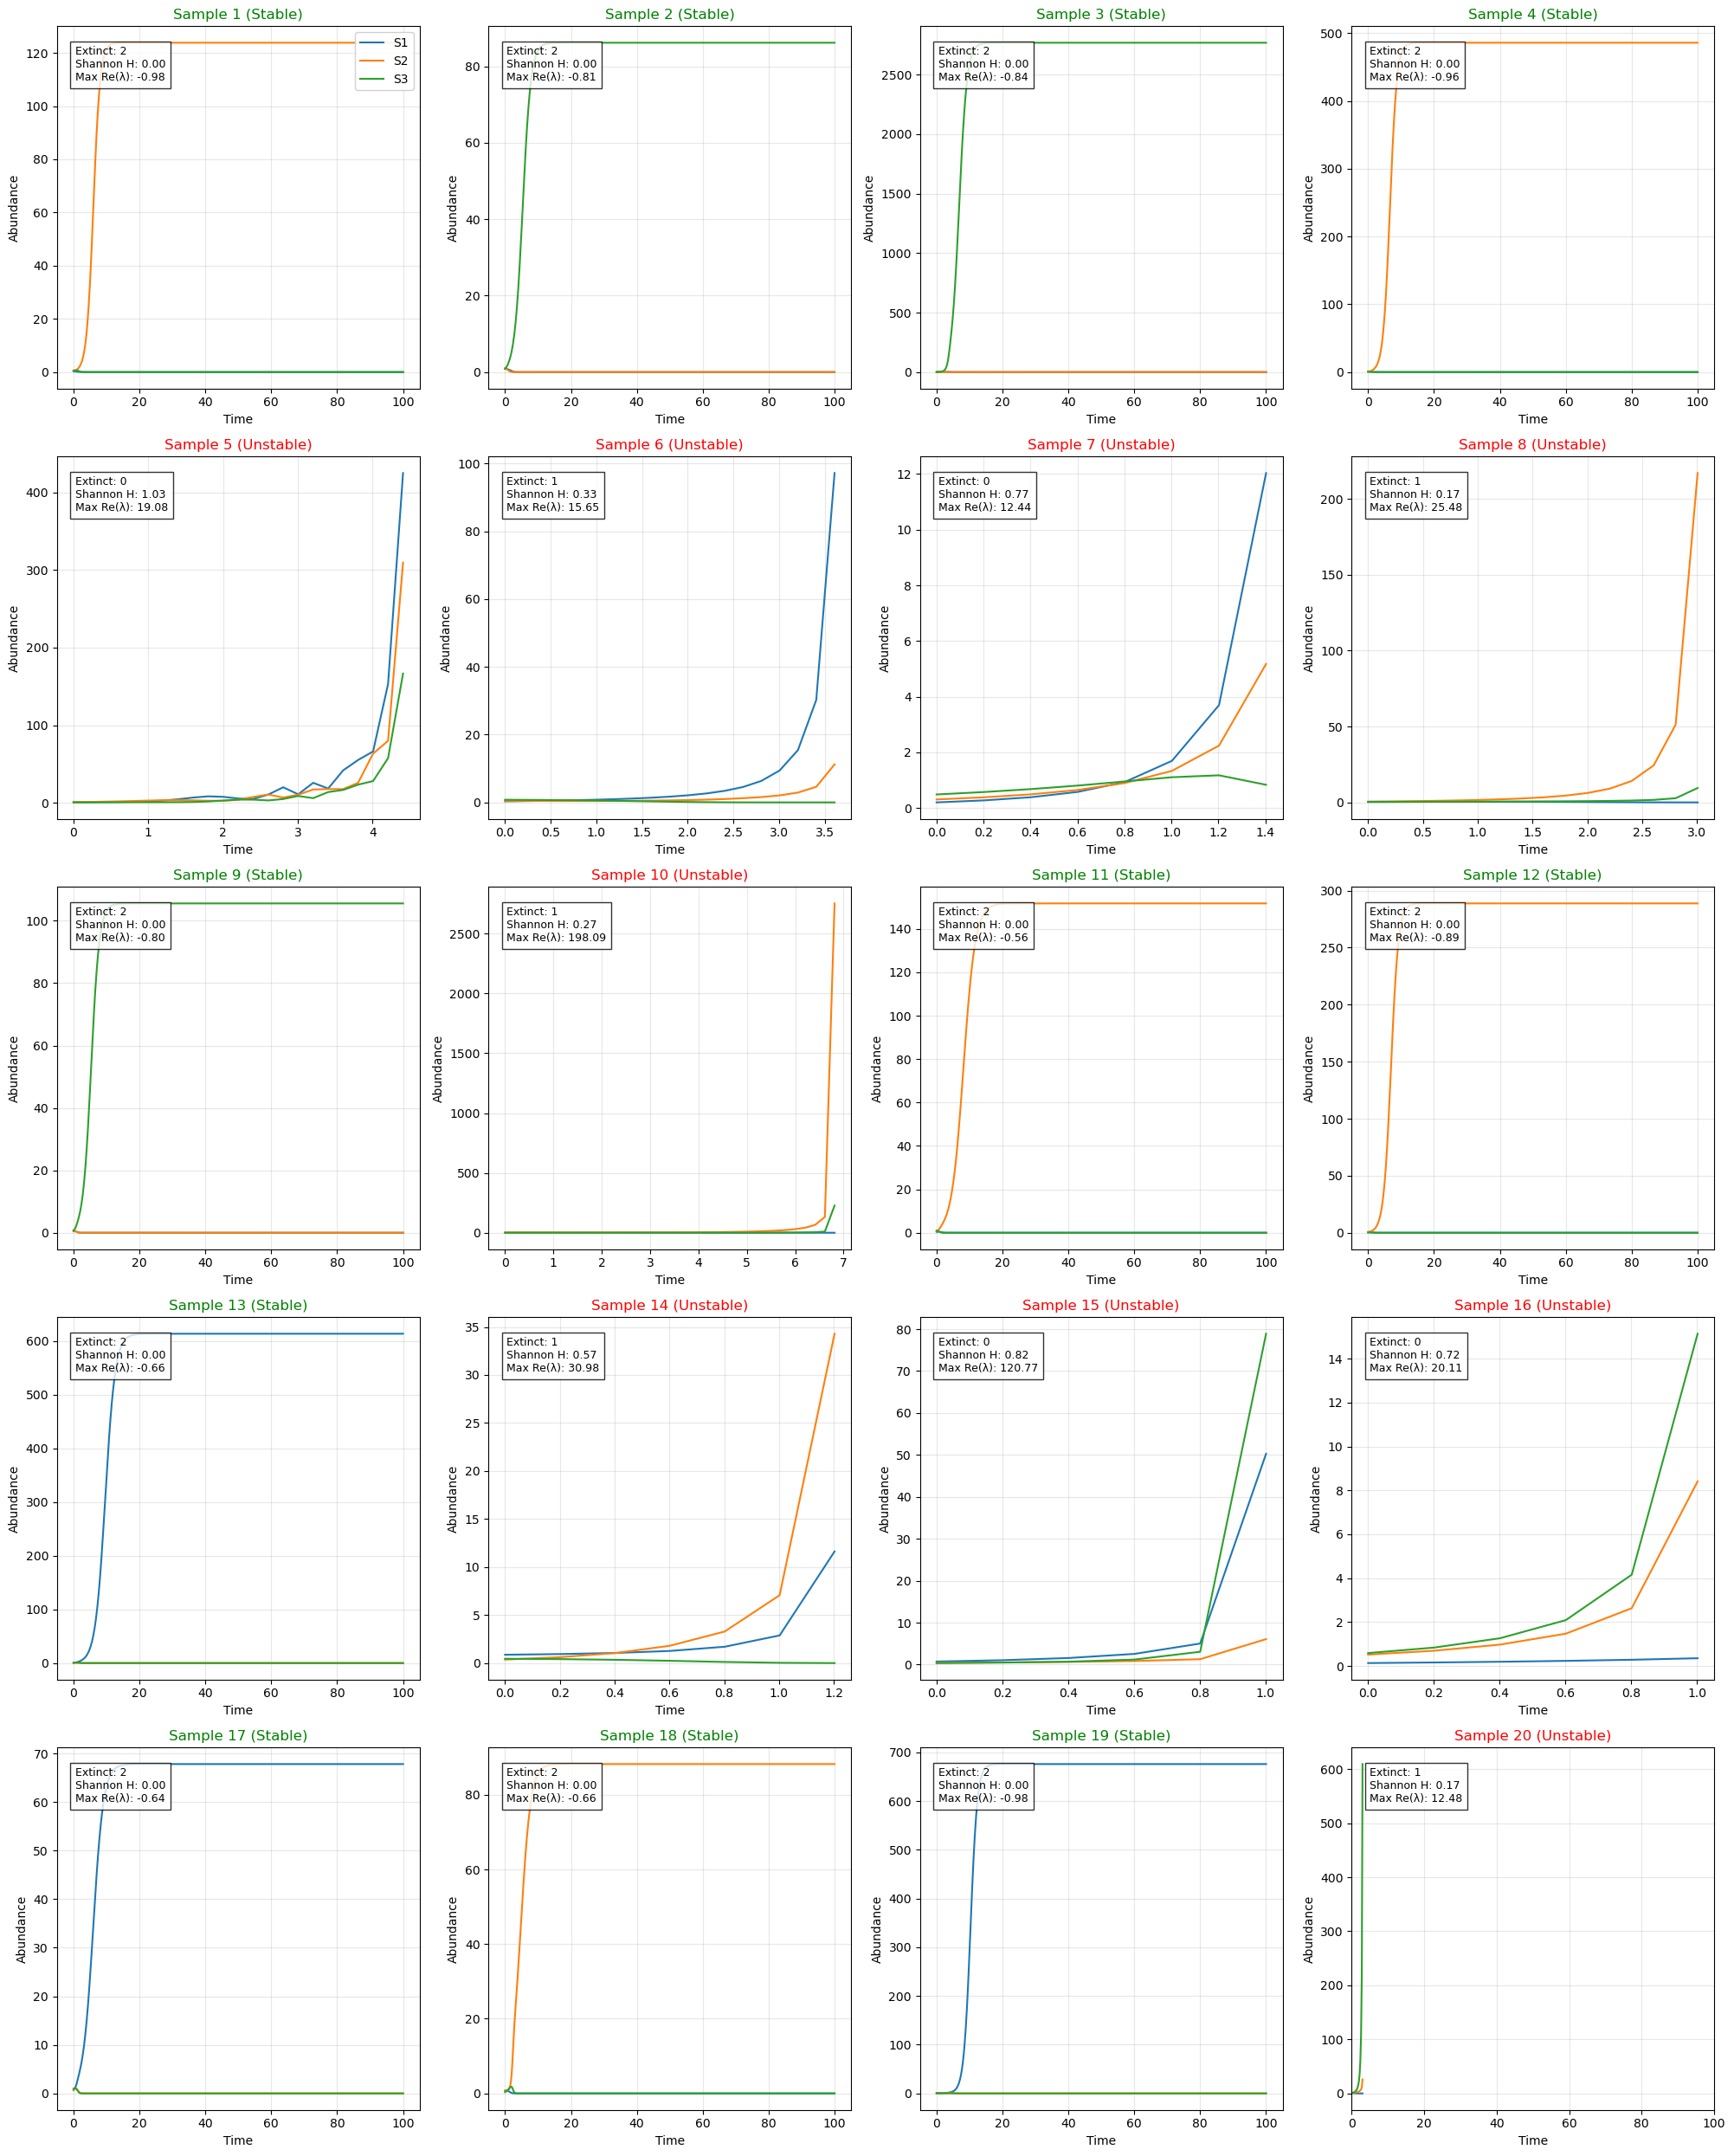

In [11]:
r_set = [0.5, 1.0]
S_set = [-1.5, 1.5]
diag_set = [0.99, 1.0]
x0_set = [0.1, 1]

generate_lv_trajectories(r_set=r_set, S_set=S_set, diag_set=diag_set, x0_set=x0_set,)

## **LOTKA-VOLTERRA SIMULATIONS IN A 10-D SPACE**

#### **Base Setting**

In this section, we simulate generalized Lotka–Volterra (GLV) dynamics for a larger ecosystem of 10 species, using biologically reasonable parameter ranges:

- Growth rates: $ r_i \sim \mathcal{U}(0.5, 1.0) $
- Interactions: $ \Sigma_{ij} \sim \mathcal{U}(-0.5, 0.5) $
- Self-regulation: $ \Sigma_{ii} \sim \mathcal{U}(0.2, 0.8) $
- Initial conditions: $ x_i(0) \sim \mathcal{U}(0.1, 1.0) $

Key Observations:

- Moderate complexity, moderate chaos: While some systems reach a stable coexistence, many others diverge or collapse.
- Higher instability rate: Compared to the 3-species case, instability is now more frequent, showing how increased dimensionality amplifies dynamic sensitivity.
- Shannon index varies widely — some communities stabilize around rich, balanced configurations, others collapse toward mono-dominance or chaotic growth.
- Eigenvalues confirm trends: Large positive real parts in many samples confirm nonlinear instabilities.

Larger ecosystems can harbor richer dynamics, but also become structurally fragile:
- Slight shifts in interactions or growth rates can cascade into extinction or runaway growth.
- Self-regulation and bounded interaction ranges remain key stabilizers.

This base case offers a controlled environment to explore how complexity scales and where it breaks down.

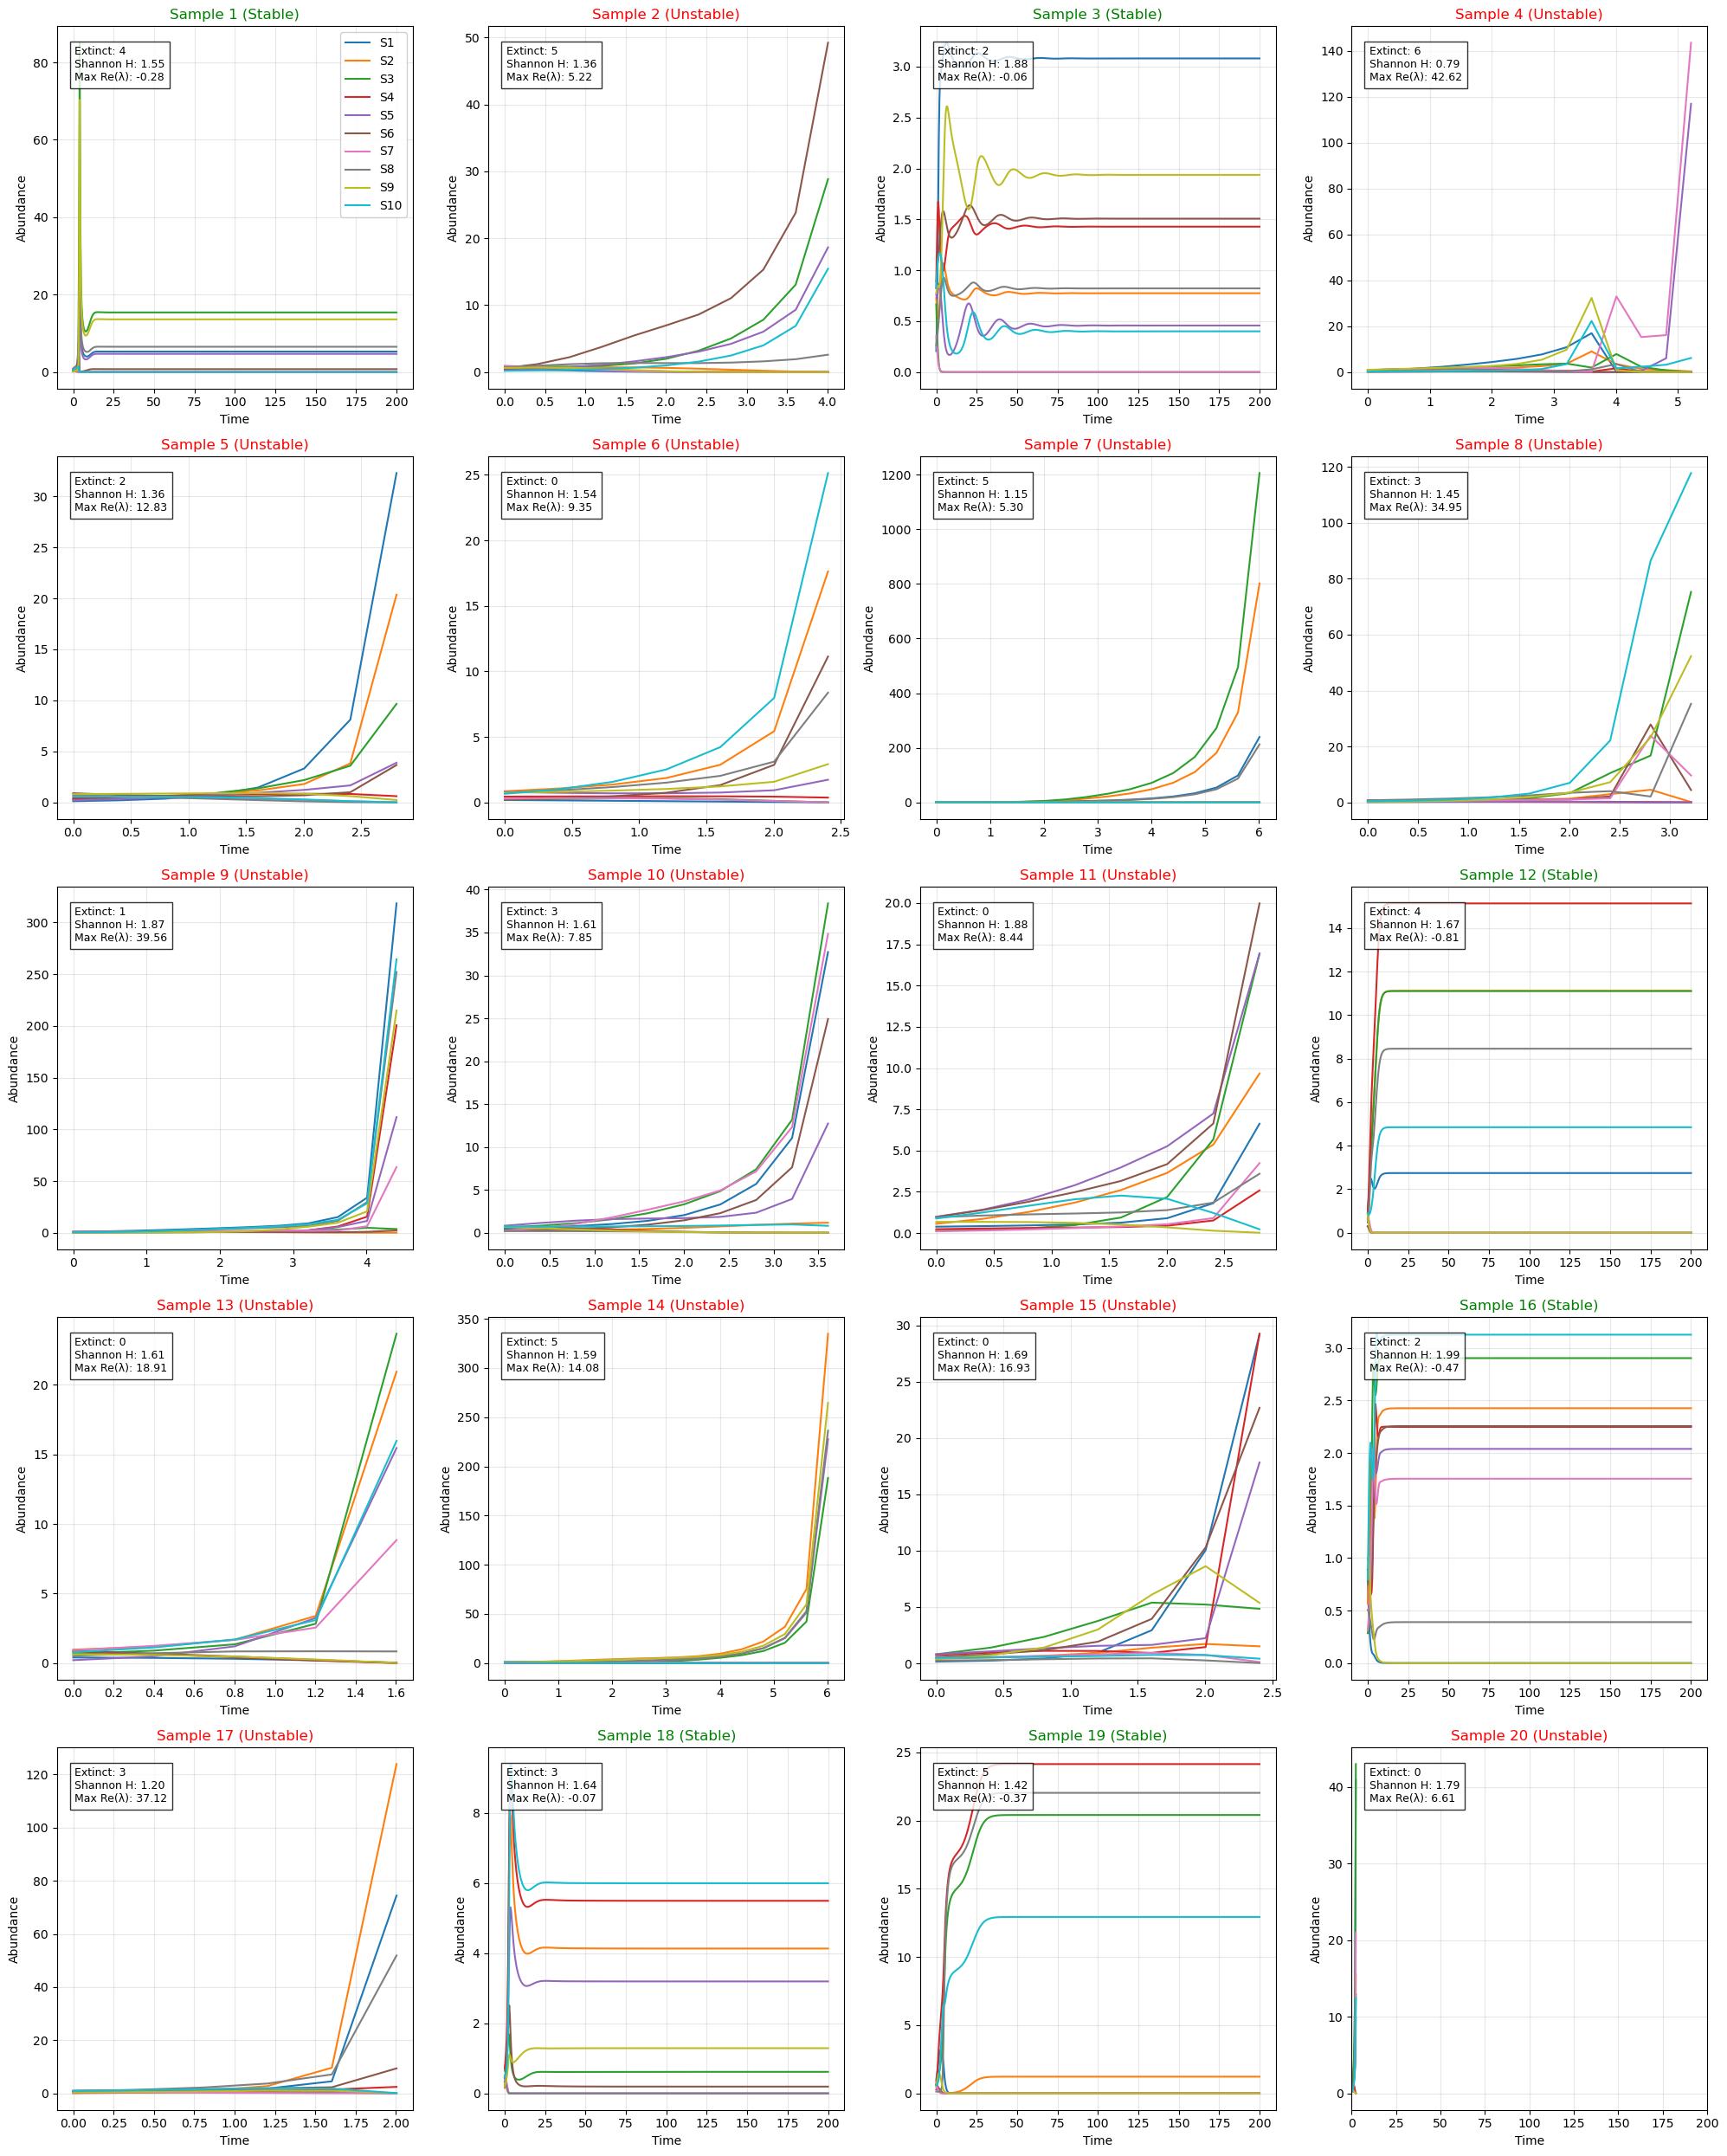

In [12]:
N = 10
r_set = [0.5, 1.0]
S_set = [-0.5, 0.5]
diag_set = [0.2, 0.8]
x0_set = [0.1, 1]

generate_lv_trajectories(r_set=r_set, S_set=S_set, diag_set=diag_set, x0_set=x0_set, num_samples=20, N=N, t_span=(0, 200.0))

#### **Aggressive Interactions**

We now explore GLV dynamics under **intensified interspecies interactions***.

This regime simulates an ecosystem under heightened competition, predation, or mutualism pressures, with 20 samples generated.

Observations:

- Dominance of instability: Nearly all systems show runaway growth or chaotic collapse. Even small perturbations in initial conditions or parameters result in sharp divergences.
- Short time to divergence: Many simulations diverge within the first few time units, underlining the impact of strong cross-species feedback.
- Near-absence of extinction: Few species die out; instead, unchecked explosive growth dominates.
- Rare stability: Only Sample 18 achieves a well-balanced equilibrium — indicating that stabilization under such aggressive conditions is highly improbable.

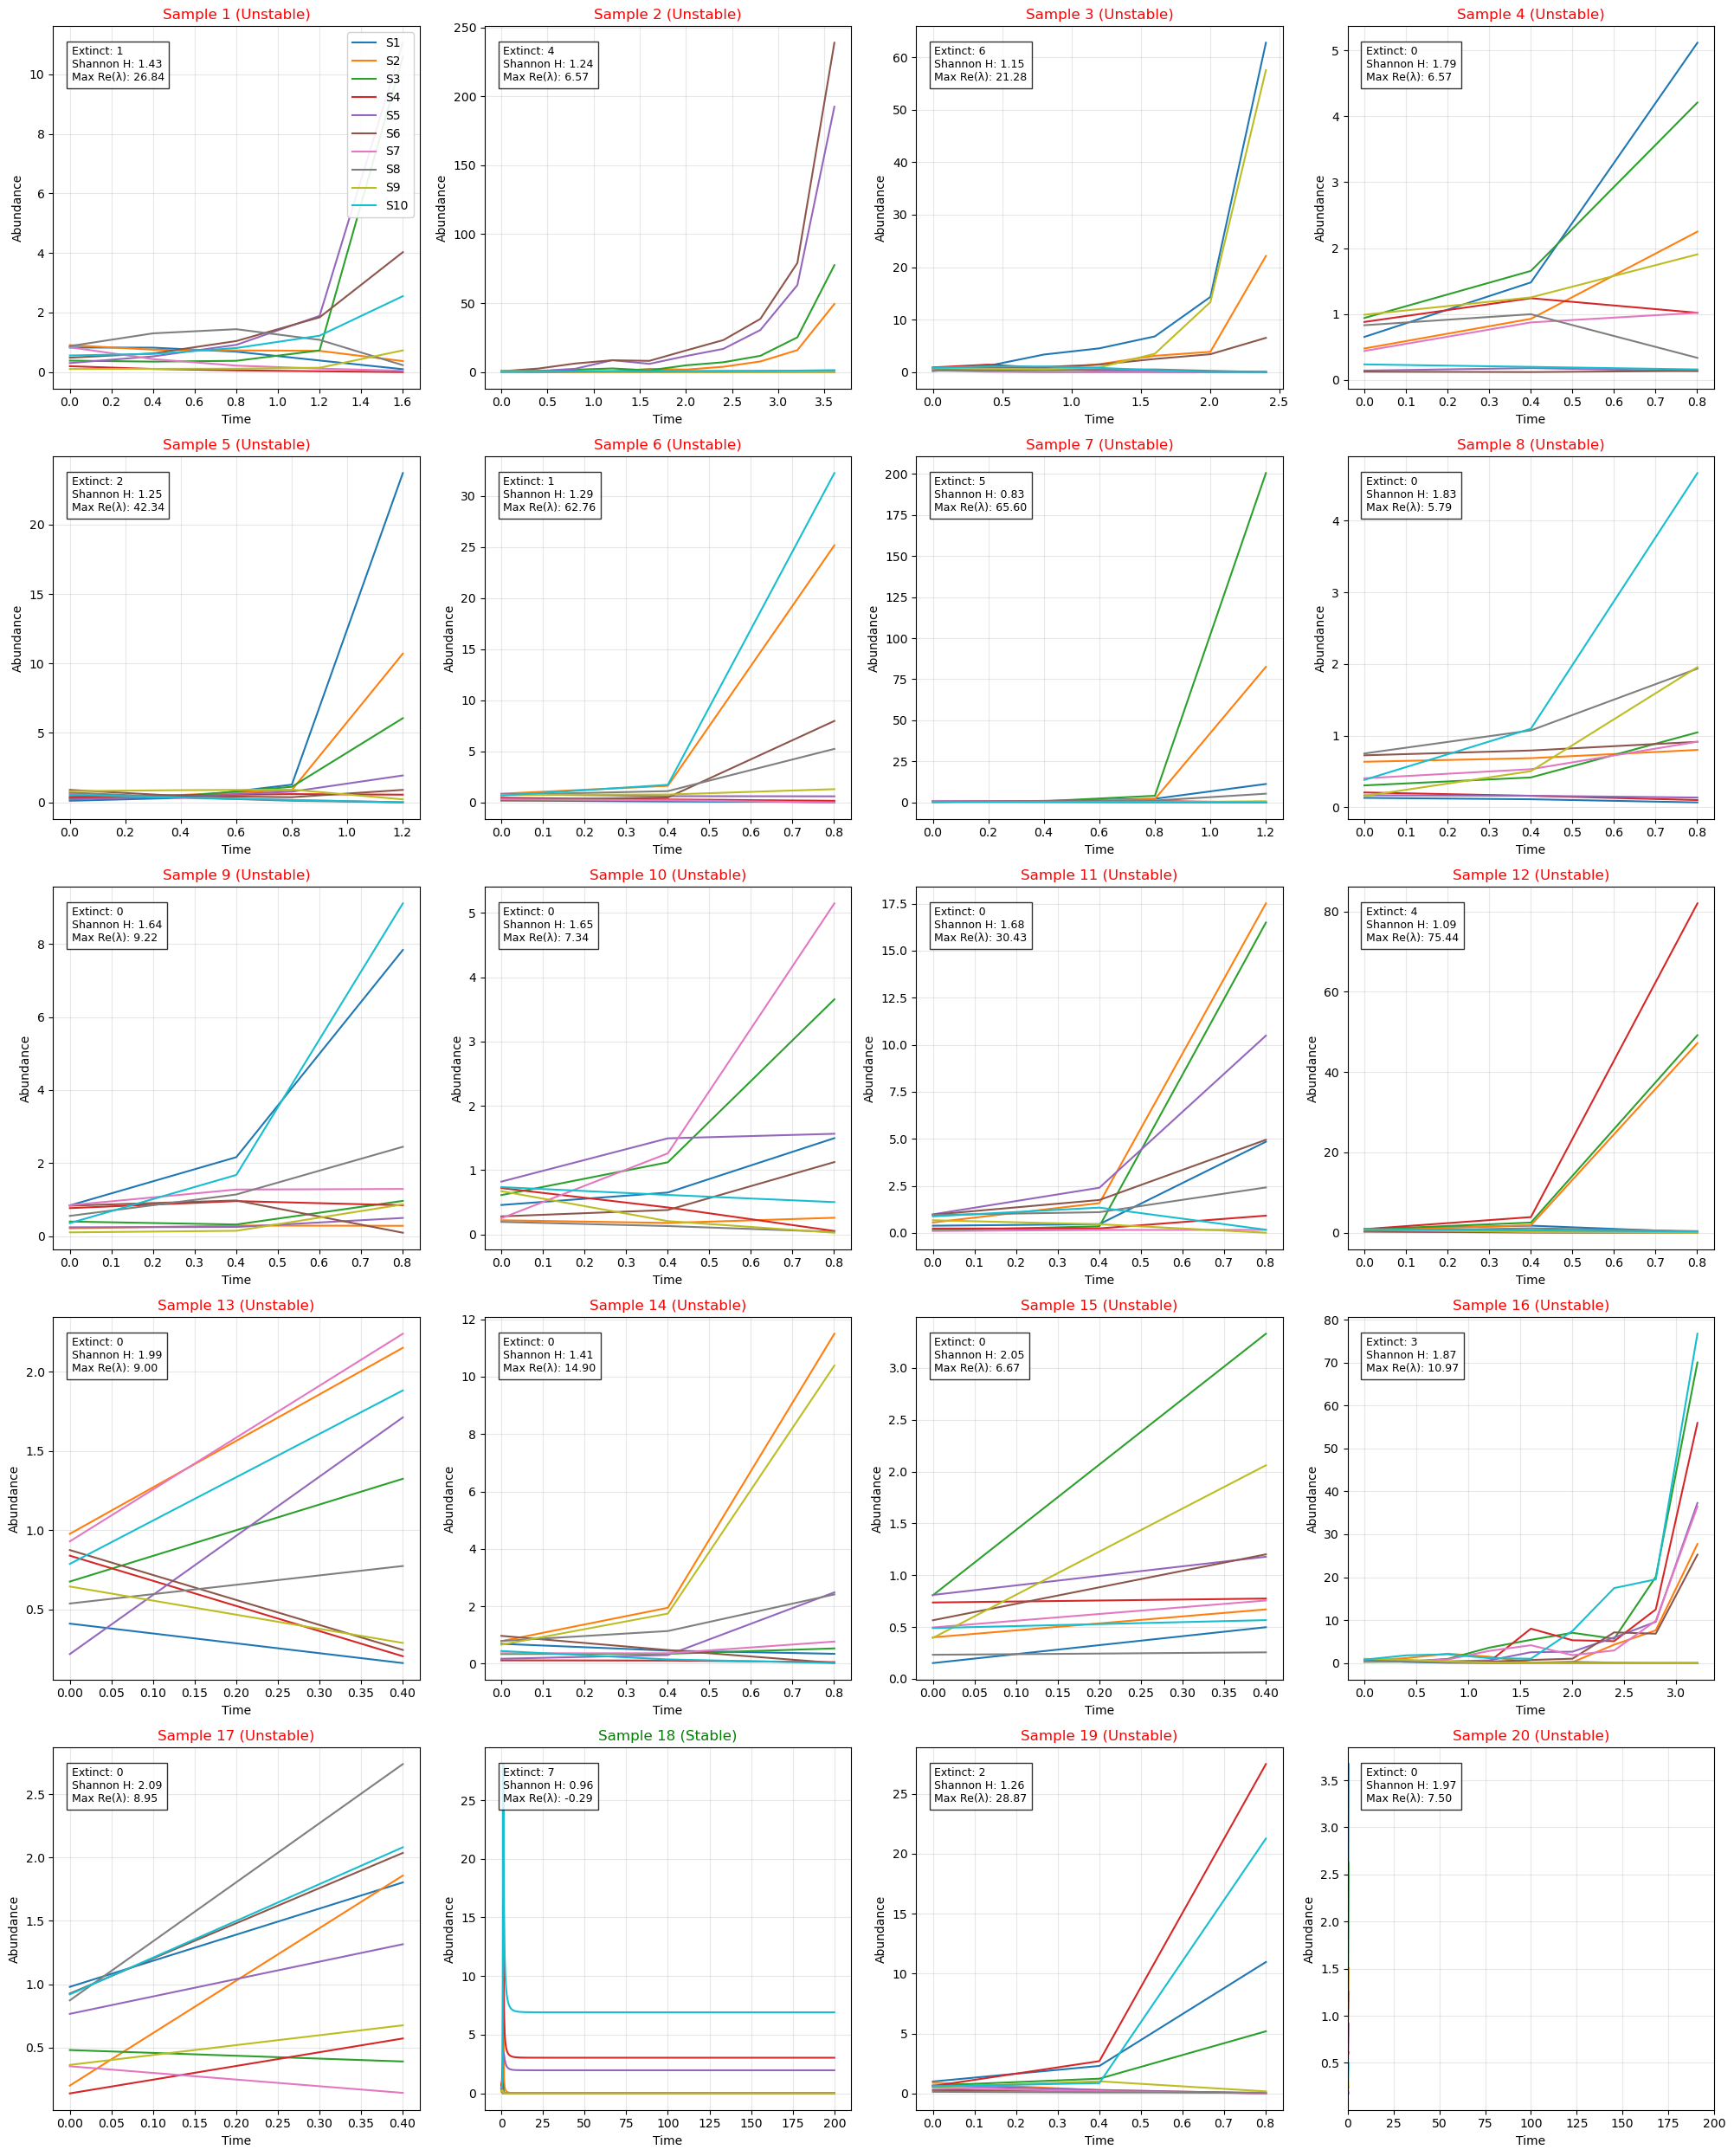

In [13]:
N=10
r_set = [0.5, 1.0]
S_set = [-1.5, 1.5]
diag_set = [0.2, 0.8]
x0_set = [0.1, 1]

generate_lv_trajectories(r_set=r_set, S_set=S_set, diag_set=diag_set, x0_set=x0_set, N=N, t_span=(0, 200.0))

#### **High Growth Rates**

We explore the effects of **faster intrinsic reproduction** while keeping interactions biologically plausible.

Sample 1 shows **chaotic dynamics**: species fluctuate in high-frequency, erratic bursts resembling classic deterministic chaos — likely due to finely balanced competition loops.

Amplified growth pushes the ecosystem closer to critical thresholds, enhancing sensitivity to feedback loops. This models ecosystems under favorable reproduction conditions, such as invasive species or climate-driven booms, where instability becomes more likely despite neutral average interactions.


C:\Users\cresp\AppData\Local\Temp\ipykernel_17868\1894088560.py:75: RuntimeWarning: invalid value encountered in log
  shannon = -np.sum(p * np.log(p))


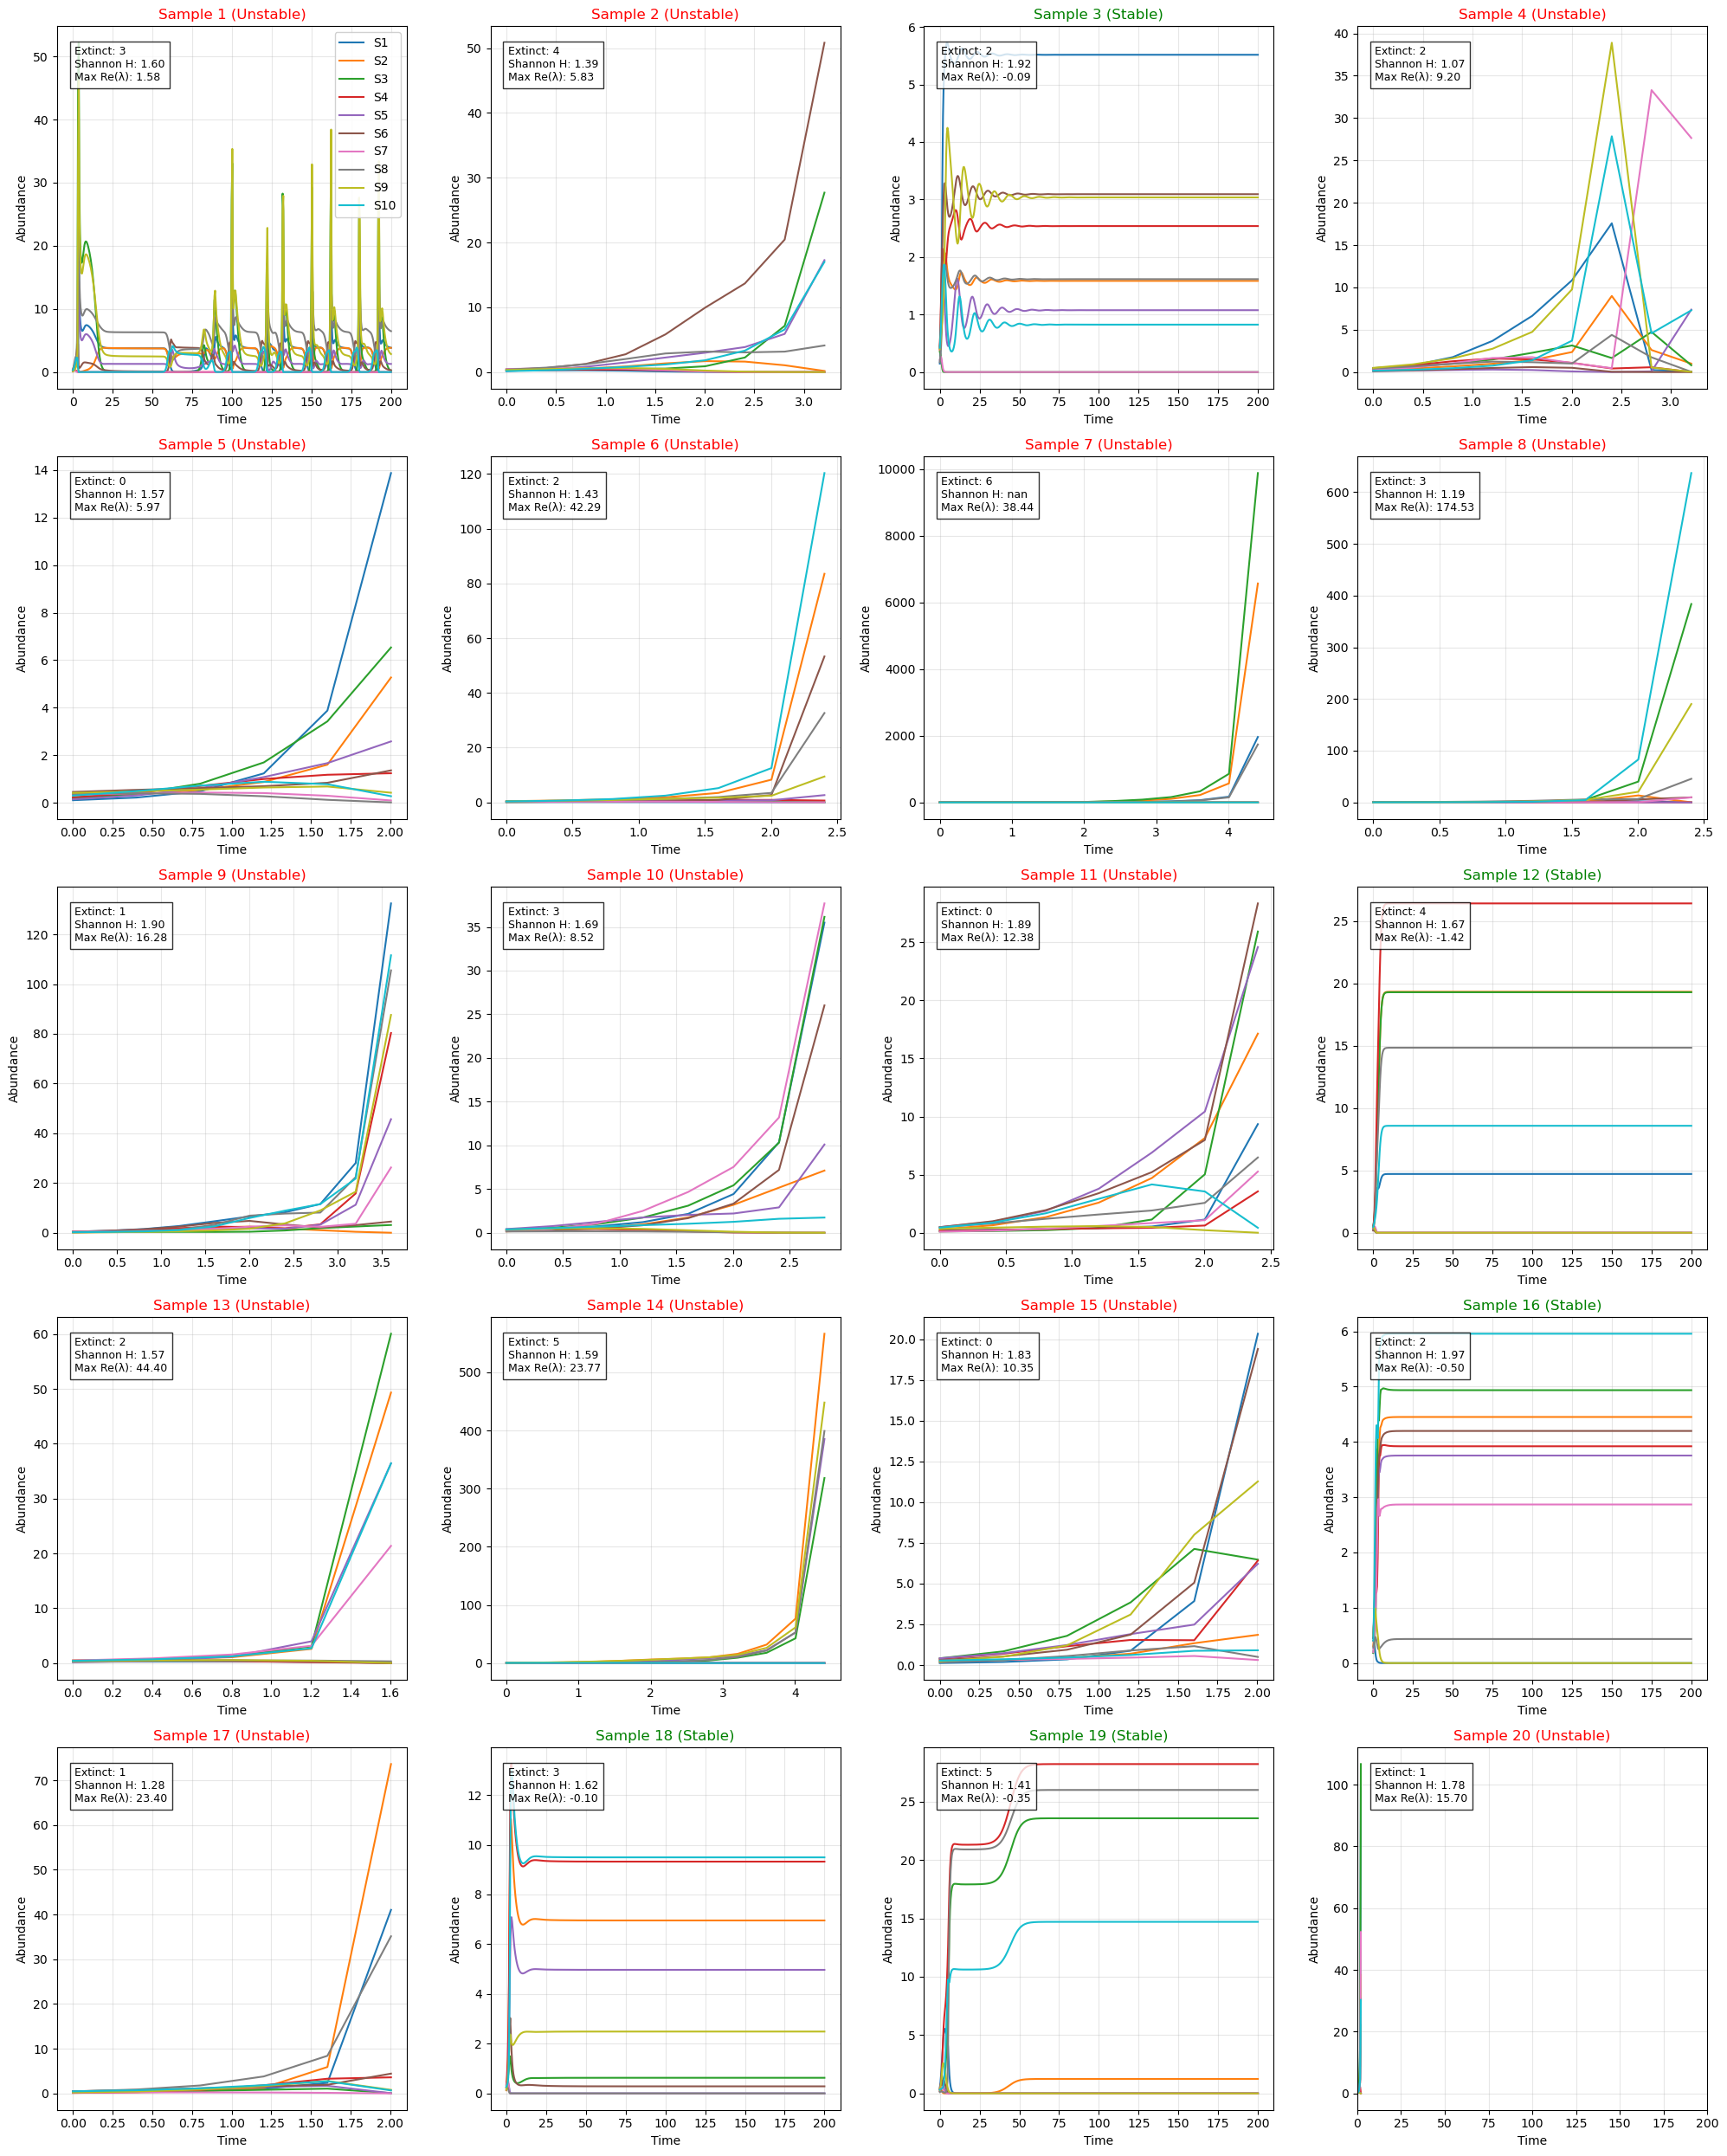

In [14]:
N=10
r_set = [0.5, 2.0]
S_set = [-0.5, 0.5]
diag_set = [0.2, 0.8]
x0_set = [0.1, 0.5]
generate_lv_trajectories(r_set=r_set, S_set=S_set, diag_set=diag_set, x0_set=x0_set, N=N, t_span=(0, 200.0), num_samples=20)

#### **Absence of Self-Regulation**

We simulate ecosystems with 10 interacting species, where **all self-regulation terms approach unity**:

- All systems are unstable: 20/20 simulations exhibit explosive or divergent dynamics.
- Self-regulation removal breaks the damping feedback that stabilizes population growth.
- Even with moderate growth rates, strong inter-species interactions dominate.
- A few simulations show transient order, but exponential divergence soon prevails.

This highlights the critical stabilizing role of intraspecific competition in maintaining biodiversity and preventing ecological collapse.

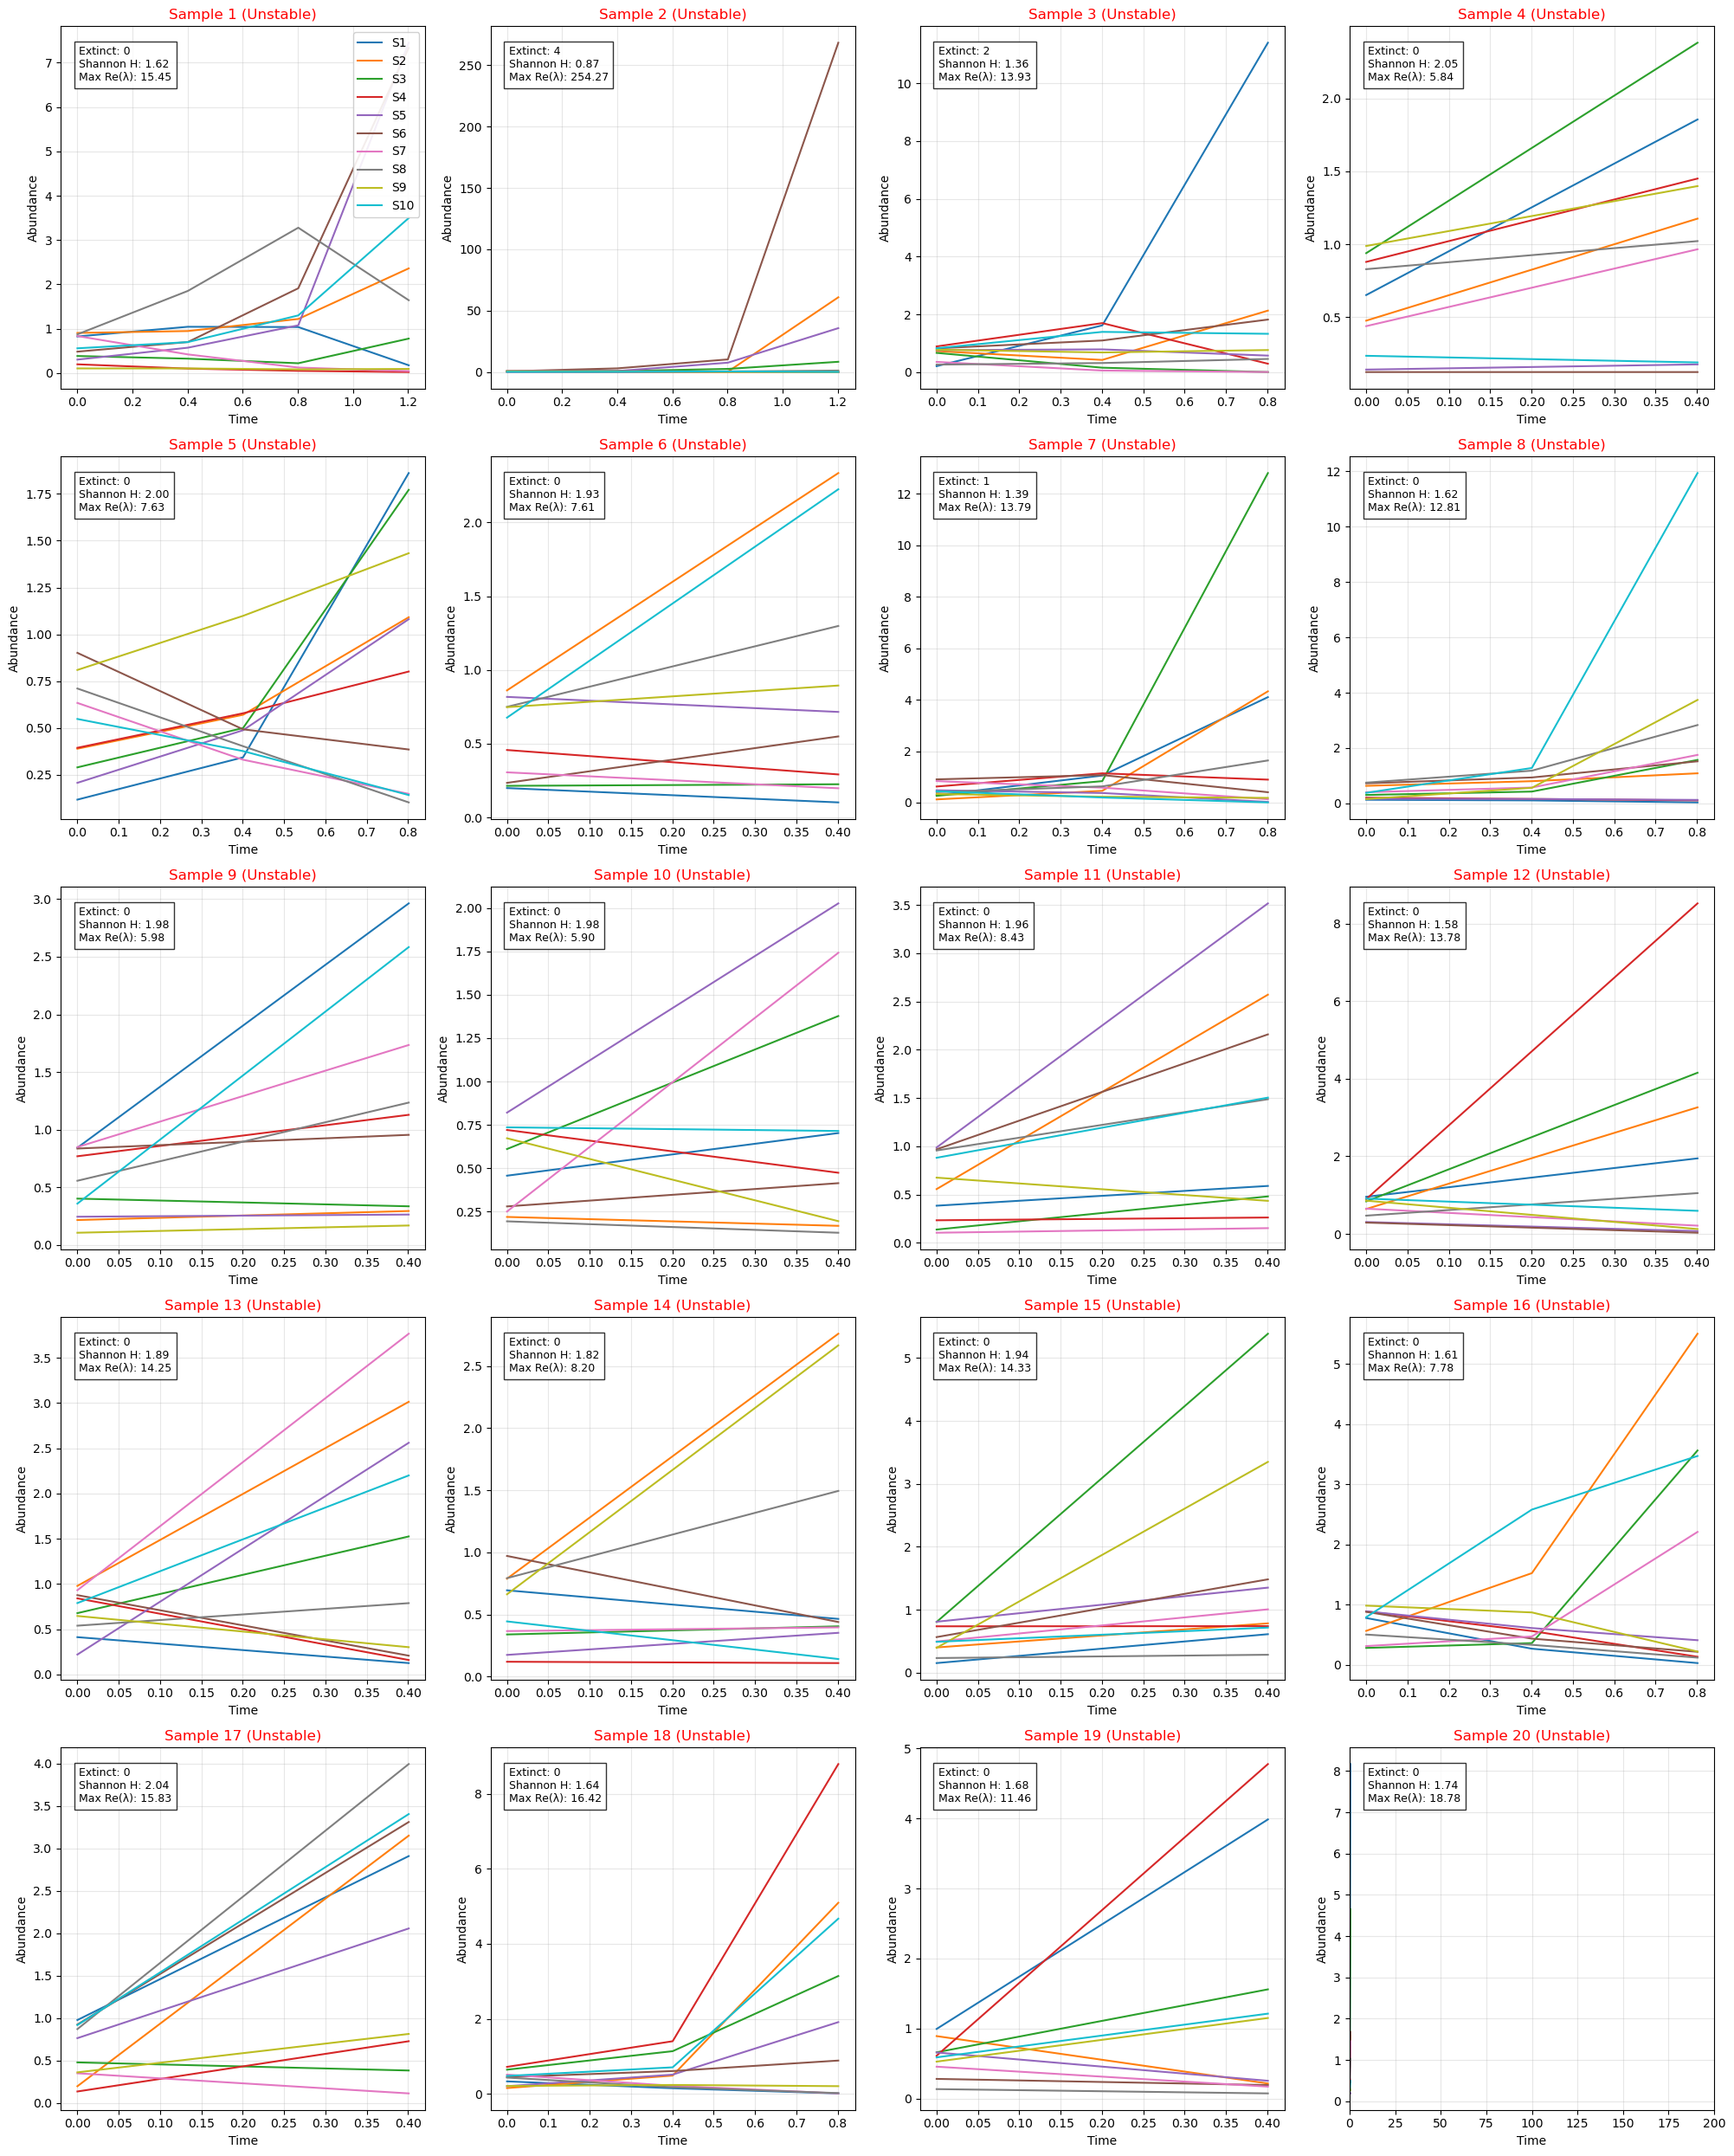

In [15]:
N=10
r_set = [0.5, 1.0]
S_set = [-1.5, 1.5]
diag_set = [0.99, 1.0]
x0_set = [0.1, 1]

generate_lv_trajectories(r_set=r_set, S_set=S_set, diag_set=diag_set, x0_set=x0_set,N=N, t_span=(0, 200.0))

## **LOTKA-VOLTERRA WITH 3 POPULATIONS**

In this section, we explore several examples of generalized Lotka–Volterra (LV) systems involving three interacting populations. While the classical two-species LV model already reveals interesting predator-prey dynamics, adding a third species introduces a new dimension of complexity.

Studying the $N = 3$ case allows us to:

- Visualize dynamics in *3D phase space*;
- Observe a range of qualitative behaviors such as:
  - *Stable coexistence* (convergence to a fixed point),
  - *Limit cycles* (sustained oscillations),
  - *Chaotic dynamics* (sensitive dependence on initial conditions);
- Experiment with different types of interactions including *competition*, *mutualism*, and *asymmetric influence*.

Each example is defined by a specific choice of:

- *Growth rate vector:* $\quad \mathbf{r} = (r_1, r_2, r_3) $,
- *Interaction matrix:* $\quad \Sigma \in \mathbb{R}^{3 \times 3} $,
- *Initial condition:* $\quad \mathbf{x}_0 = (x_1(0), x_2(0), x_3(0)) $.

We will simulate the time evolution of the system and perform a qualitative analysis using:

- Time-series plots of each species,
- 3D phase-space trajectories,
- Stability analysis via Jacobian eigenvalues,
- Detection of extinction or dominance.

These examples serve as a foundation for understanding more complex multi-species dynamics and the emergence of non-trivial behaviors in ecological networks.

Before getting on, we would like to comment on some implementation details which may lead to unrealistic scenarios. 

In particular, in several simulations, we notice that **species with near-zero abundance** (well below the extinction threshold) occasionally return to non-negligible levels. While biologically unrealistic, this behavior is expected from the **numerical integration** of the Lotka-Volterra system.

This "resurrection" can be attributed to the following:

- *Floating-point precision*: Computers never truly reach zero; values may hover near machine epsilon (e.g., $ \sim 10^{-15} $) and still be non-zero.
- *Exponential sensitivity*: Even small values of $ x_i $ can regrow under a positive effective growth term, especially when influenced by other species.
- *Lack of hard extinction condition*: The ODE system is continuous and deterministic.


In a real ecosystem, species with tiny populations would probably face extinction due to stochastic effects, environmental noise, or reproductive bottlenecks. However, our model lacks:
- Demographic stochasticity,
- Discrete individuals,
- Allee effects or extinction cutoffs.

#### **Stable Fixed Point**

In this first exmaple, we deal with a set of parameter leading to a stable fixed point. In particular, we notice that $\Sigma$ has $0$s on the diagonal, meaning we are modelling a high intra-species competition (i.e. self-regulation).

We observe the following behaviour:
- The populations evolve smoothly and converge toward a steady state.
- No oscillations or chaotic behaviour is observed.
- The final abundances of the species stabilize at:
  $
  \mathbf{x}^* \approx (0.601,\ 0.547,\ 0.965)
  $
- All species survive and coexist over time — no extinction occurred.

For what regards the analysis of the Jacobian matrix, we get that:
- All eigenvalues have negative real parts, which implies that the fixed point is locally asymptotically stable.
- The complex conjugate pair suggests the presence of slight damped oscillations, but the system ultimately settles into equilibrium.

This example represents a *typical competitive system* where:

- Each species is negatively influenced by the others (all off-diagonal interactions are negative),
- Self-regulation (via the identity matrix in the model) ensures bounded growth,
- Coexistence is possible when inter-species competition is sufficiently weak compared to intrinsic growth.

Such a system is ecologically relevant for modeling *stable ecosystems* with *mild competition* and *no external disruptions*.

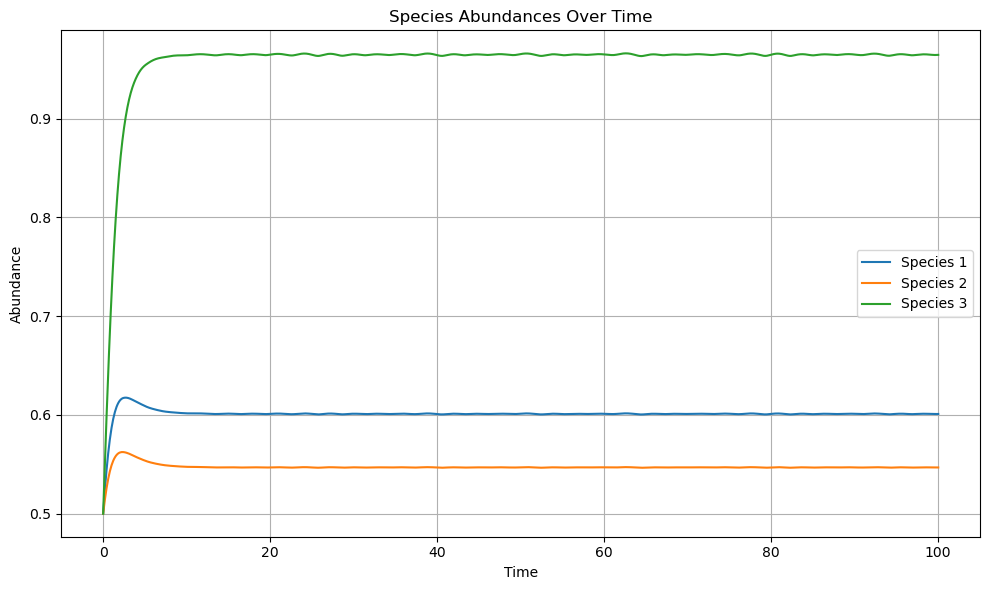

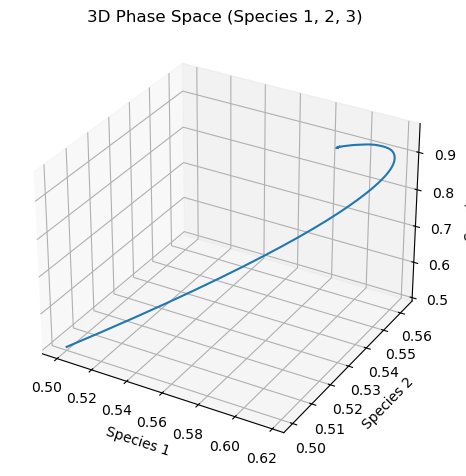

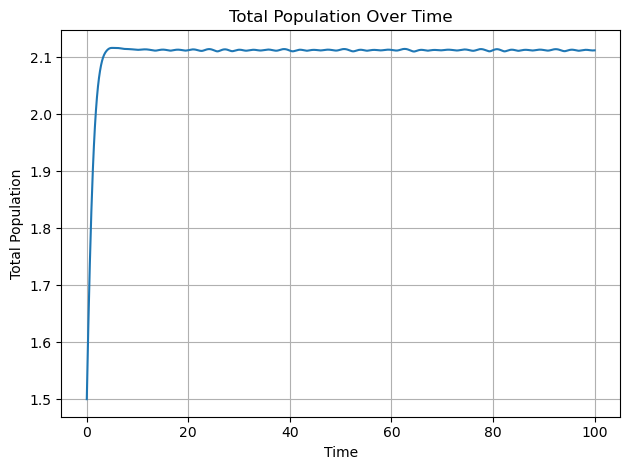

No species went extinct.
Estimated Fixed Point (last state): [0.60098706 0.54681097 0.96462471]
Jacobian Eigenvalues at Fixed Point: [-1.10636336+0.j         -0.5026163 +0.02518101j -0.5026163 -0.02518101j]
Stable fixed point (all eigenvalues have negative real parts).


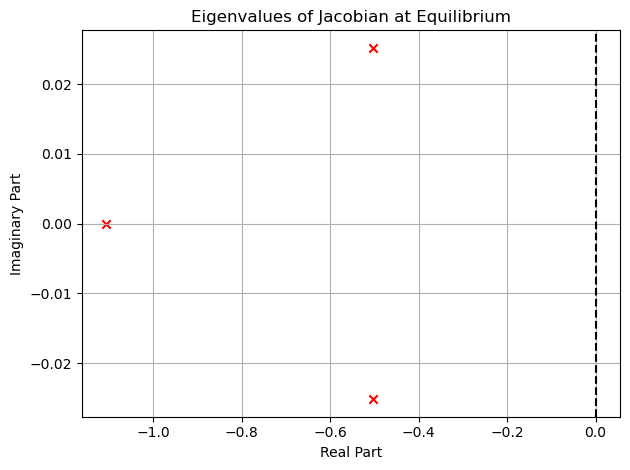

In [16]:
N = 3
r = np.array([1.0, 0.8, 1.2])
Sigma = np.array([
    [0.0, -0.2, -0.3],
    [-0.1, 0.0, -0.2],
    [-0.3, -0.1, 0.0]
])
x0 = np.array([0.5, 0.5, 0.5])
simulate_and_analyze_lv(N, r, Sigma, x0, (0, 100))

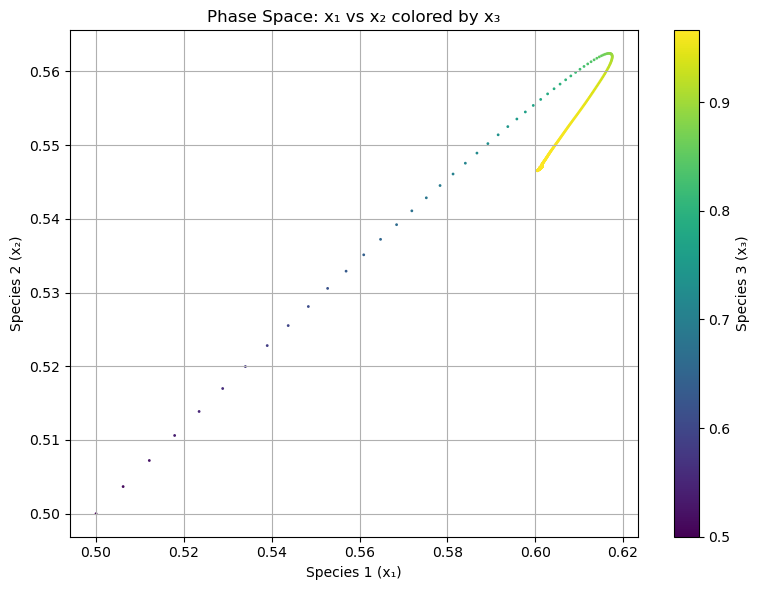

In [17]:
plot_colored_phase_space(N, r, Sigma, x0, (0, 100))

#### **Oscillatory Behaviour and Competitive Exclusion**

In this example, we simulate a 3-species Lotka–Volterra system where the interaction matrix creates a *cyclic competitive structure* — similar in spirit to rock-paper-scissors dynamics.

Observations:

- The system initially displays sustained and periodic oscillations in the abundances of all three species.
- Each species peaks in turn, while the others decline — a hallmark of *cyclic dominance*.
- However, over time, these oscillations grow more extreme, ultimately leading to *competitive exclusion*.
- One species (Species 2 in this case) eventually dominates, while the others are driven to extinction ($abundance < 10^{-3}$).

It is interesting to remark that, despite a long period of apparent coexistence, the simulation ends with extintion of species 1 and 3, which illustrates that transient coexistence in cyclic competitive systems can lead to long-term extinction in deterministic dynamics, especially when small asymmetries are present in the system or numerical rounding accumulates.

Since one eigenvalue has a positive real part, the fixed point is classified as unstable. This confirms what we observe numerically: while the system temporarily hovers around a dynamic equilibrium, it ultimately escapes due to instability, leading to extinction and dominance.

This example demonstrates:

- The potential for oscillatory dynamics in cyclic systems,
- The role of interaction asymmetry in destabilizing coexistence,
- How deterministic systems may eventually break symmetry and result in competitive exclusion.

Such behaviors are important in ecological modeling, particularly in understanding *ecosystem fragility*, *dominance shifts*, and species invasions over long time scales.

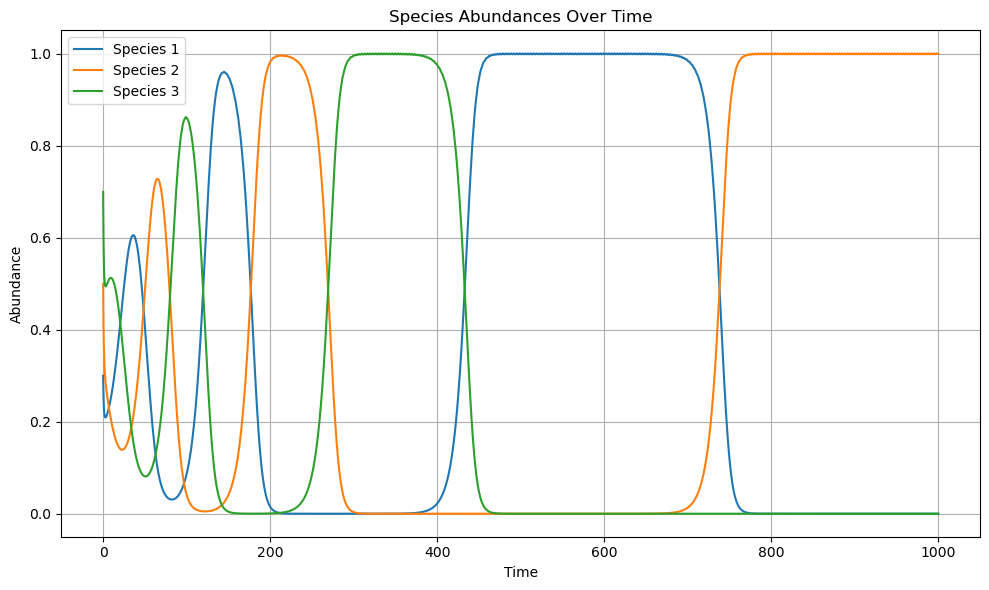

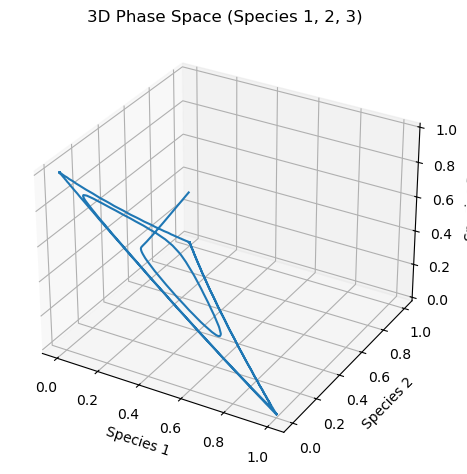

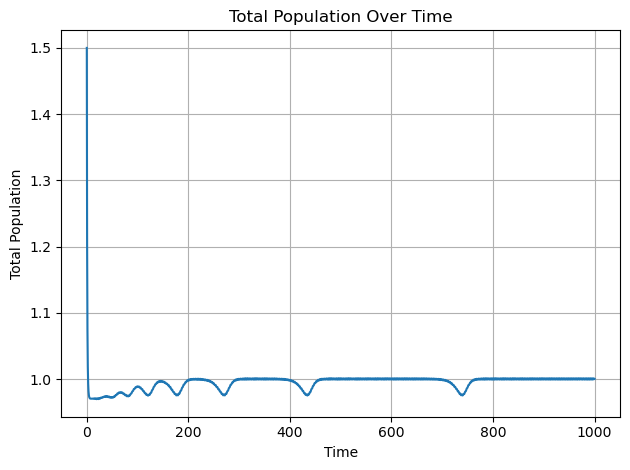

Extinct or nearly extinct species (abundance < 1e-3): [1, 2, 3]
Estimated Fixed Point (last state): [3.10832579e-23 1.00022982e+00 4.10637618e-15]
Jacobian Eigenvalues at Fixed Point: [-1.00045963 -0.20027578  0.09979317]
Unstable fixed point (some eigenvalues have positive real parts).


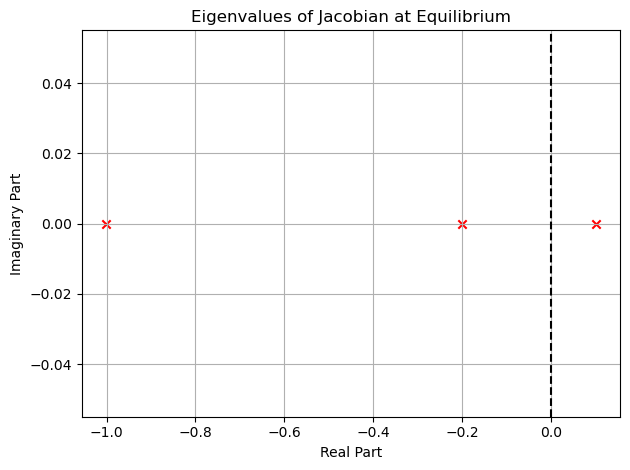

In [18]:
N = 3
r = np.ones(N)
Sigma = np.array([
    [0.0, -1.2, -0.9],
    [-0.9, 0.0, -1.2],
    [-1.2, -0.9, 0.0]
])
x0 = np.array([0.3, 0.5, 0.7])
t_span = (0, 1000)
t_eval = np.linspace(*t_span, 10000)

simulate_and_analyze_lv(N, r, Sigma, x0, t_span, t_eval)

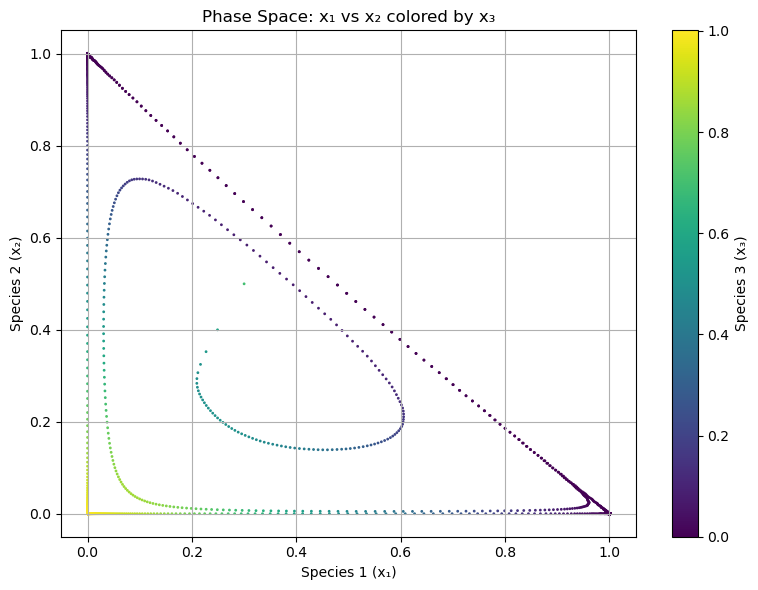

In [19]:
plot_colored_phase_space(N, r, Sigma, x0, (0, 1000))

In this example, we revisit the cyclic competitive interactions seen previously, but we analyze what happens in the **limit of nearly null self-regulation** — where species no longer significantly restrict their own growth.

The diagonal terms of the interaction matrix $ \Sigma_{ii} \approx 1 $ effectively cancel the logistic self-limiting term in the dynamics:

$$
(I - \Sigma)_{ii} \approx 0 \quad \Rightarrow \quad \text{no self-regulation}
$$

This models species that:

- Do not regulate their own growth (e.g., *lack of intraspecific competition*),
- Face no crowding effects, space/resource limits, or internal control mechanisms.

Examples in nature might include:

- *Invasive species* without natural predators or constraints,
- *Opportunistic microorganisms* that grow rapidly when unchecked (bacteria, tumors, viri),
- *Synthetic species* or cell lines engineered without feedback controls.

Observations:

- The system displays *sustained, high-amplitude oscillations* with sharp peaks.
- Species grow until interactions with others sharply cut them off.
- The oscillations do not decay — instead, the system cycles perpetually through near-extinction and explosion phases.

This is consistent with limit cycle behavior resulting from **weak damping** (lack of self-regulation).

Stability analysis via computation of the Jacobian matrix shows the presence of a positive real eigenvalue, which confirms the oscillatory behaviour of the system. Also, the **large spread in eigenvalues** indicates a system with **sharp, unstable dynamics**, sensitive to perturbation.

Such insights are crucial when modeling **invasions**, **disease outbreaks**, or **engineered populations** with reduced natural control mechanisms.

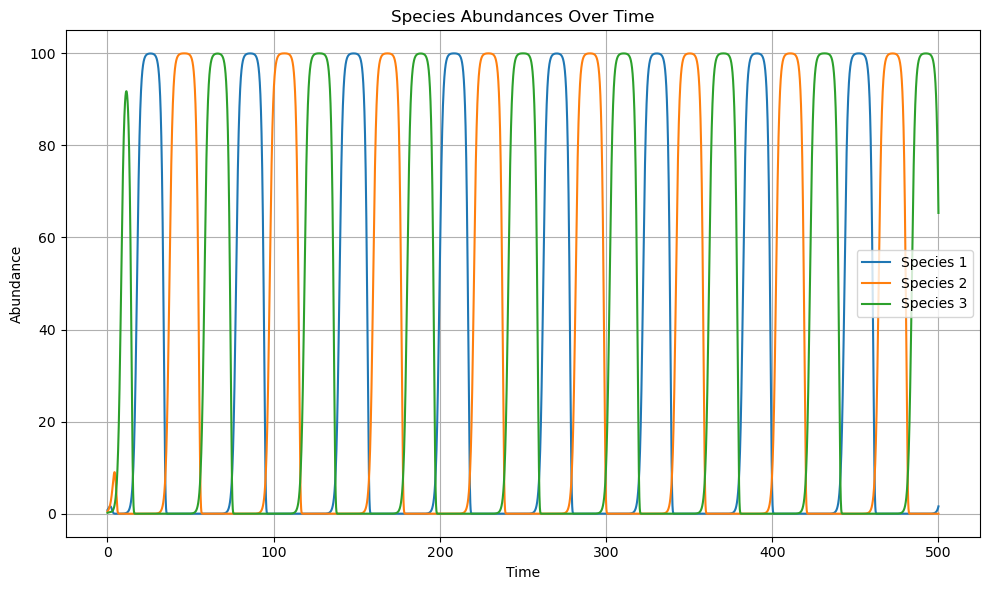

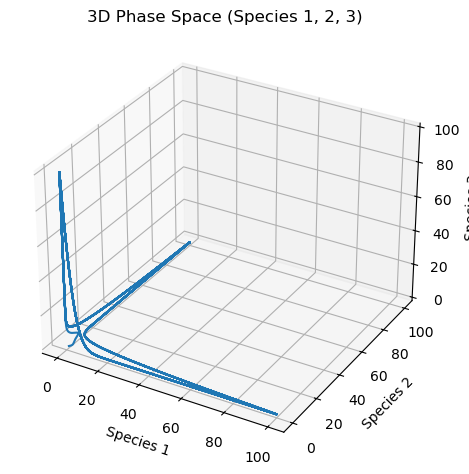

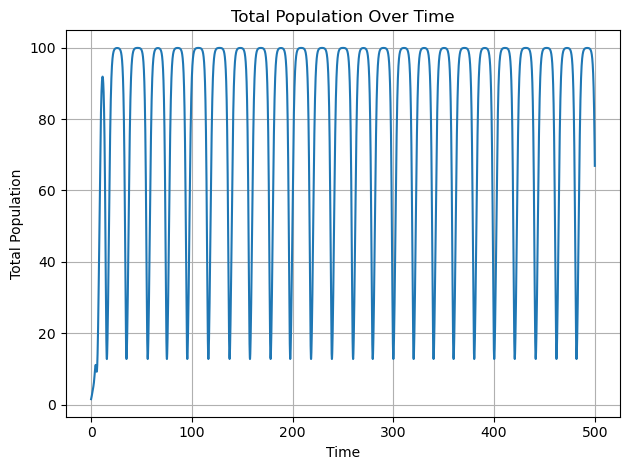

Extinct or nearly extinct species (abundance < 1e-3): [1, 2, 3]
Estimated Fixed Point (last state): [1.58889739e+00 1.34968238e-07 6.53157727e+01]
Jacobian Eigenvalues at Fixed Point: [  0.96822196  -1.10076412 -31.65788633]
Unstable fixed point (some eigenvalues have positive real parts).


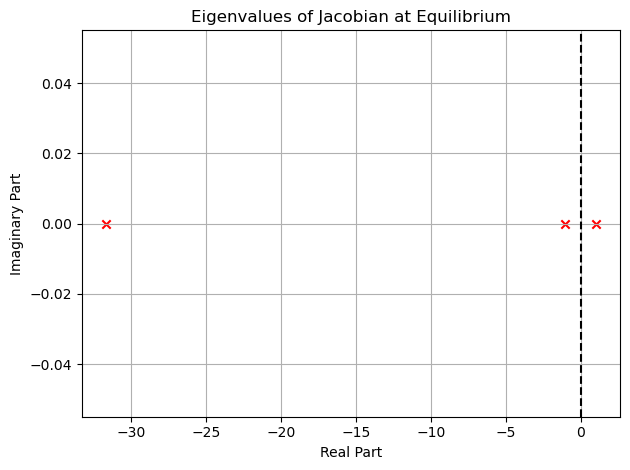

In [20]:
N = 3
r = np.ones(N)
Sigma = np.array([
    [0.99, -0.5, -0.0],
    [-0.0, 0.99, -0.5],
    [-0.5, -0.0, 0.99]
])
x0 = np.array([0.8, 0.5, 0.2])
t_span = (0, 500)
t_eval = np.linspace(*t_span, 10000)

simulate_and_analyze_lv(N, r, Sigma, x0, t_span, t_eval)

This example illustrates a **boundary regime** between sustained oscillatory dynamics and asymptotic stability, determined by the value of the **self-regulation terms**.

We notice that the system begins with pronounced *cyclic oscillations* of the species' abundances, but over time, these oscillations *decay*, and the system *converges to a common fixed point*.
Also, no species goes extinct: all three populations stabilize at the same abundance.

This behavior is a **benchmark case** on the edge between:

- Sustained limit cycles, seen when self-regulation is too weak (e.g., $ \Sigma_{ii} \approx 1 $),
- Global stability, observed when self-regulation is strong enough to dampen oscillations.

Recalling that diagonal entries of \( \Sigma \) represent the strength of self-regulation, here $ \Sigma_{ii} = 0.7 $ balances internal regulation and external interactions. This setting mimics species that moderately regulate their own growth (e.g., through limited resource use or mild territorial constraints).

Such species may exhibit **transient competition dynamics** but ultimately reach stable coexistence.

All eigenvalues happen to have negative real parts, confirming the fixed point is locally asymptotically stable, while the complex conjugate pair explains the damped oscillations seen before stabilization.

This example provides a valuable **reference case**:

- By slightly increasing or decreasing the diagonal of $\Sigma $, we can transition between stable equilibria and sustained oscillations.
- It serves as a **bifurcation boundary**, highlighting how fine-tuned feedback mechanisms affect ecological stability.

Such tuning is useful when modeling ecosystems with known cyclic patterns that eventually settle — like seasonal population shifts, controlled predator-prey dynamics, or managed ecological networks.



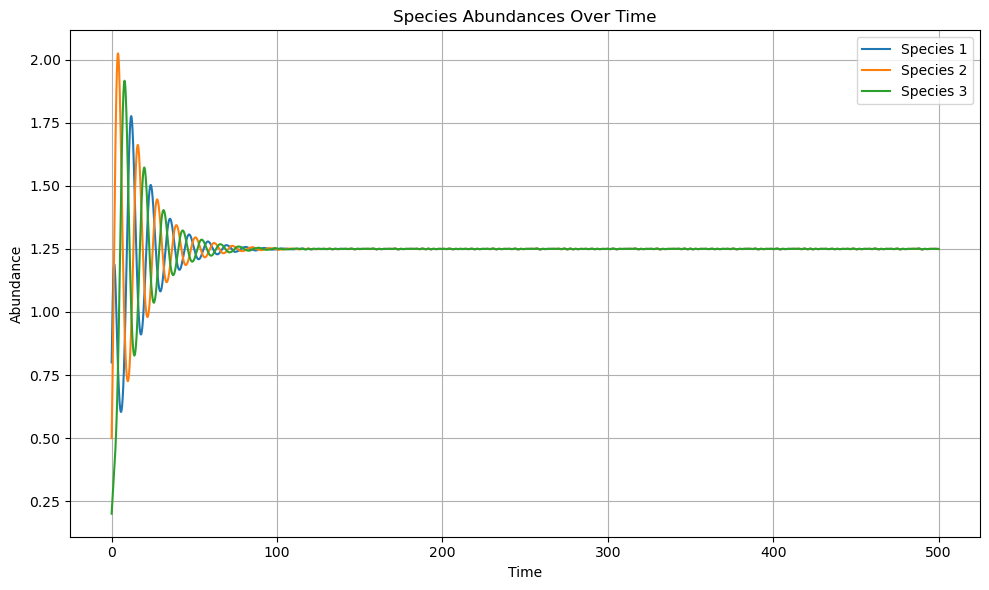

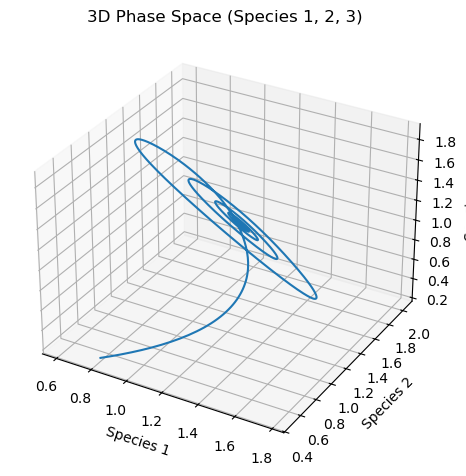

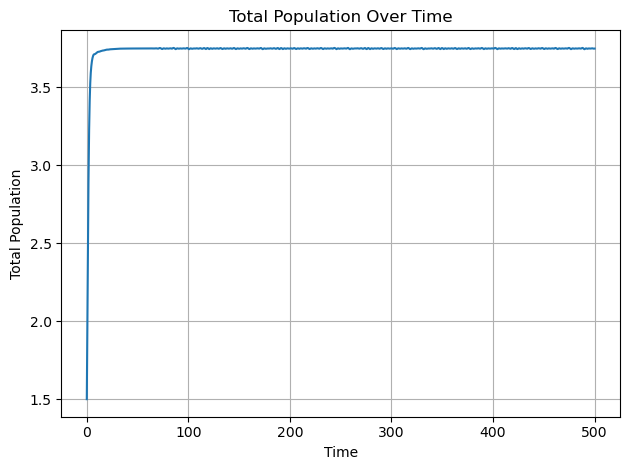

No species went extinct.
Estimated Fixed Point (last state): [1.24974628 1.24974628 1.24974628]
Jacobian Eigenvalues at Fixed Point: [-0.06228433+0.54115601j -0.06228433-0.54115601j -0.99959404+0.j        ]
Stable fixed point (all eigenvalues have negative real parts).


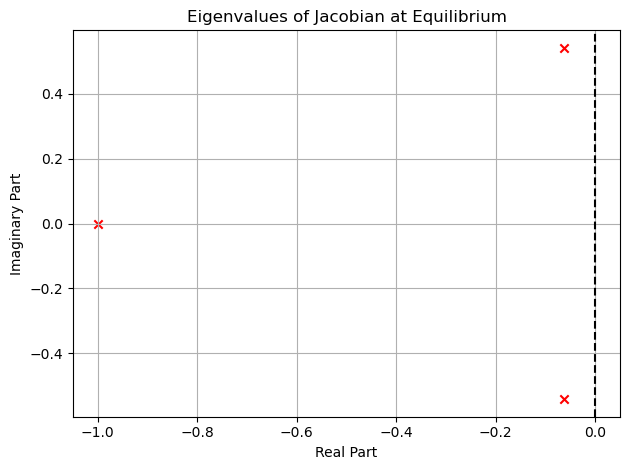

In [21]:
N = 3
alpha, beta = 0.5, 0.0
r = np.ones(N)
Sigma = np.array([
    [0.7, -alpha, -beta],
    [-beta, 0.7, -alpha],
    [-alpha, -beta, 0.7]
])
x0 = np.array([0.8, 0.5, 0.2])
t_span = (0, 500)
t_eval = np.linspace(*t_span, 10000)

simulate_and_analyze_lv(N, r, Sigma, x0, t_span, t_eval)

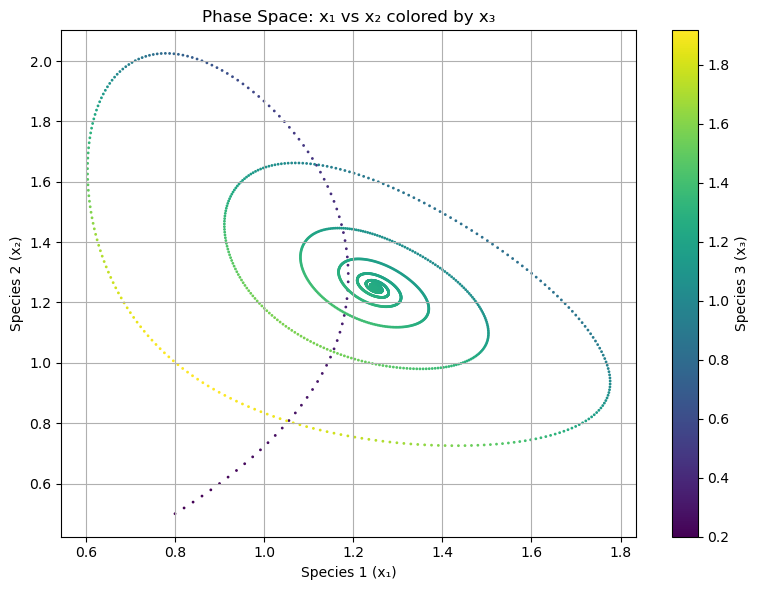

In [22]:
plot_colored_phase_space(N, r, Sigma, x0, t_span, t_eval)

## **HIGHLY UNSTABLE 4-SPECIES ECOSYSTEM**

This example demonstrates a system with:
- Mixed growth rates (positive and negative),
- Strongly asymmetric inter-species interactions,
- Extinction of a species,
- And an unstable fixed point.

It showcases how **imbalances** in the growth and interaction parameters can drive a system toward complex and unbalanced long-term outcomes. 
Indeed, the species show highly irregular dynamics with sharp oscillations, Species 3 goes extinct (its abundance drops to near-zero permanently), and Species 1 and 2 continue interacting, with Species 2 growing far more dominant.

From a biological point of view, these paramters model an ecosystem where:
- Species 2 has a *negative intrinsic growth rate*, relying on interaction for survival;
- Species 3 is *strongly suppressed* by Species 1 and *unable to recover*;
- Species 1 has a *slightly positive growth rate* and ultimately dominates.

Such scenarios may occur in:
- Systems where one species is invasive and outcompetes a weaker native one,
- Predator-prey-prey chains where one prey gets wiped out,
- Artificial or disrupted environments with unbalanced feedback.

Form eigenvalues analysis, we get that the positive real part confirms the fixed point is unstable, while the complex conjugate pair indicates the system exhibits **spiral-like divergence** near the fixed point — a classic signature of an unstable focus.

This example highlights how:
- Strong asymmetries can break coexistence,
- Negative intrinsic growth can be compensated by interactions,
- Unstable equilibria can result in ongoing divergence or collapse of part of the system.

It is particularly relevant to modeling:
- Fragile ecosystems, where one species is on the brink of collapse,
- Invasion dynamics where balance is broken by one powerful agent,
- or chaotic regimes that arise near bifurcations.

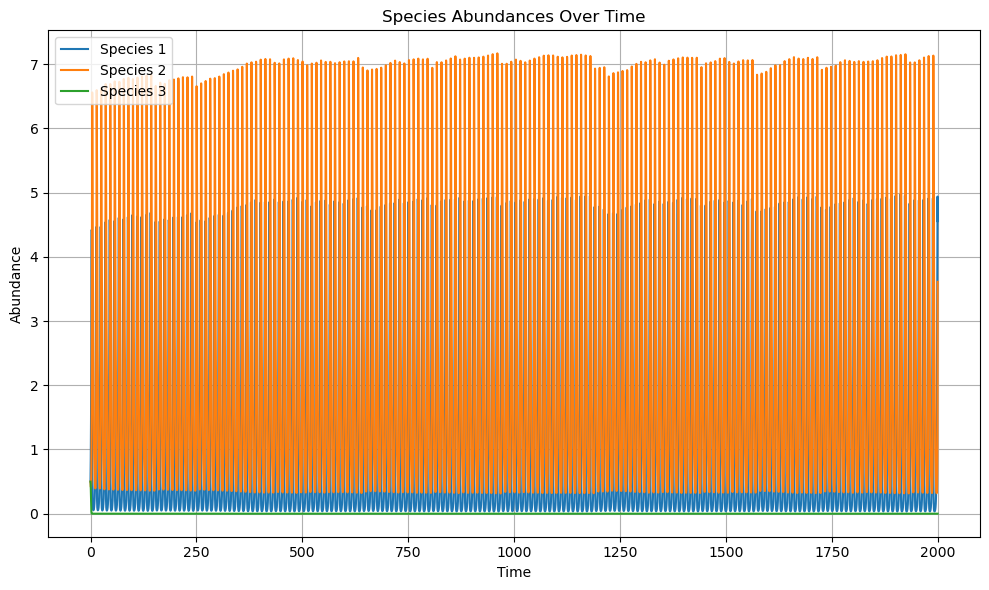

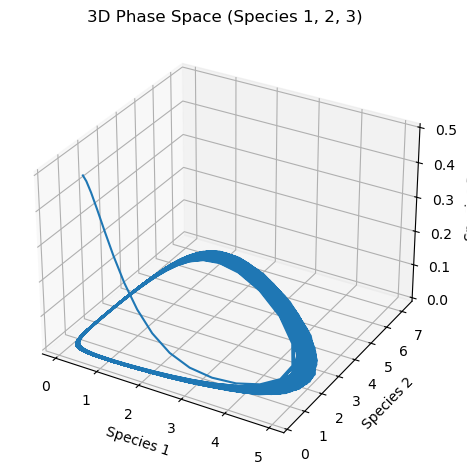

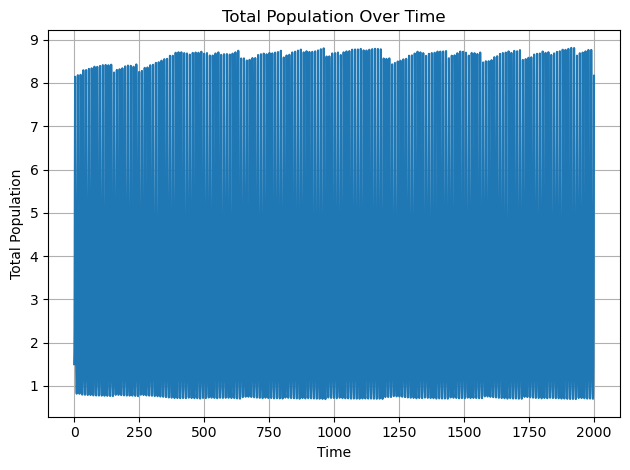

Extinct or nearly extinct species (abundance < 1e-3): [3]
Estimated Fixed Point (last state): [ 4.55663262e+00  3.61050092e+00 -6.05265080e-11]
Jacobian Eigenvalues at Fixed Point: [ 0.53653293+1.60340438j  0.53653293-1.60340438j -6.13494894+0.j        ]
Unstable fixed point (some eigenvalues have positive real parts).


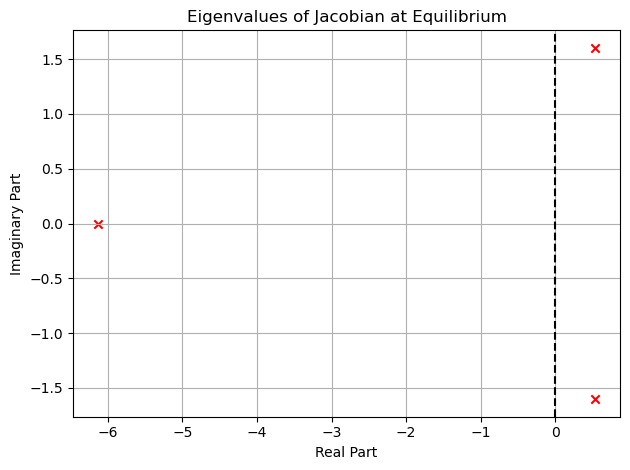

In [23]:
N = 3

r = np.array([1.1, -0.5, 0.7])
Sigma = np.array([[ 1.0, -0.5, 0],
                  [0.5, 1.0,  -0.2],
                  [-1.5, 0, 1.0]])

x0 = np.array([0.5, 0.5, 0.5])
t_span = (0, 2000)
t_eval = np.linspace(*t_span, 10000)

simulate_and_analyze_lv(N, r, Sigma, x0, t_span, t_eval)

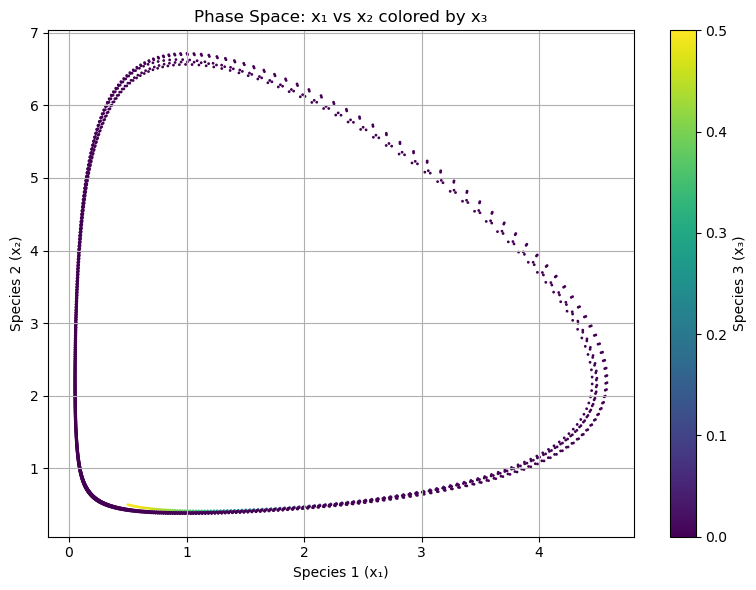

In [24]:
plot_colored_phase_space(N, r, Sigma, x0, (0, 50))

## **LARGE LOTKA-VOLTERRA MODELS (N=8)**

In this section, we explore the behavior of generalized Lotka–Volterra systems with a larger number of species. Specifically, we focus on the case $N = 8$.

This number was chosen arbitrarily to represent a system with numerous interacting species, while still allowing for manageable visualization and analysis. It enables us to investigate:

- High-dimensional population dynamics,
- Emergent behaviors such as clustering, chaos, or extinction,
- How interaction structure affects global stability or collapse.

But why should we consider many species?
Most natural ecosystems involve **multiple interdependent species**, often with complex relationships. While smaller systems ($N = 2$ or $3$) allow for geometric visualization, larger systems are essential to explore:

- Ecosystem-level properties, like stability, biodiversity, and resilience,
- Invasion dynamics in crowded ecosystems,
- Rich dynamical regimes not observable in low dimensions.

Moreover, as the number of species increases:
- The phase space becomes higher-dimensional,
- The qualitative behavior becomes more sensitive to initial conditions and parameter choices,
- The likelihood of partial extinction**, chaotic attractors, or quasi-stable states increases.

Our approach will be the follwing. We will generate examples by selecting:
- A random or structured interaction matrix $$ \Sigma \in \mathbb{R}^{8 \times 8}, $$
- A growth rate vector $$ \mathbf{r} \in \mathbb{R}^8, $$
- A random initial condition $$ \mathbf{x}_0 \in \mathbb{R}_+^8.$$

We then analyze:
- Abundance trajectories over time,
- Total population dynamics,
- Extinction events and survivors,
- Fixed point estimates and their stability,
- Selected projections of the phase space (2D or 3D with coloring).

This transition from 3-species to 8-species systems reveals **how complexity scales with dimensionality** in ecological models, and provides insights into **high-dimensional nonlinear dynamics**.


#### **Stable Equilibrium**

This example illustrates a randomly generated Lotka–Volterra system with $ N = 8 $ species. The growth rates and interactions are drawn from uniform and normal distributions, respectively, to mimic a **heterogeneous ecosystem** with varied ecological roles.

Observations:

- Most species show fast transients followed by stabilization.
- Two species (4 and 8) went *extinct* or nearly extinct during the simulation.
- The other six species converge to *nonzero steady-state abundances*, forming a **stable sub-ecosystem**.

This reflects common outcomes in complex systems:
- Competitive exclusion under pressure from random interactions,
- **Survival of compatible clusters**, where species dynamics mutually stabilize.

All eigenvalues have negative real parts, therefore, the fixed point is locally asymptotically stable.

This example demonstrates key features of **large ecological networks**:

- **Extinction cascades** may occur even without external shocks, purely from internal structure,
- Stable coexistence is possible for a subset of species,
- High-dimensional systems tend to converge quickly if strongly damped (large negative eigenvalues).

Such random, data-free models can be used to test robustness, explore phase transitions, and study diversity collapse in ecological or synthetic networks.

Interaction matrix (Sigma): 
 [[ 0.          0.63403815  0.05371864 -0.44274219  0.63129022  0.04299918
  -0.30561913 -0.3100754 ]
 [ 0.55353887  0.         -0.11425821  0.21534699 -0.83355865  0.37511268
  -0.0023112  -0.18699159]
 [-0.16920612  0.42579284  0.          0.64675615  0.57020395 -0.26590205
   0.39400714 -0.68018611]
 [-0.44005752 -0.52625764  0.32420036  0.         -0.27569175 -0.34110275
   0.44538884 -0.76846789]
 [-0.28056097  0.33963514  0.42027992 -0.21474978  0.          0.55762239
  -0.15914698  0.40765095]
 [ 0.75955252 -0.14193986 -0.15480659 -0.77092215  0.22030264  0.
   0.3131106  -0.71729516]
 [ 0.4967422   0.68309875  0.12926136 -0.39673376 -0.46531295 -0.00853404
   0.         -0.49724567]
 [-0.16406761 -0.42203014 -0.42292486 -0.51364689  0.36525042 -0.55509814
   0.01201111  0.        ]]


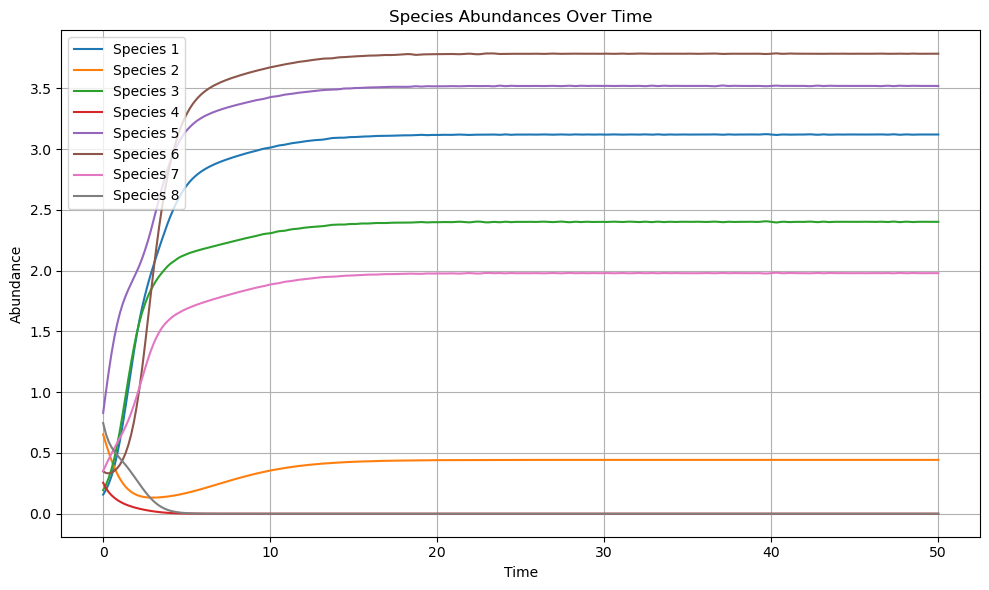

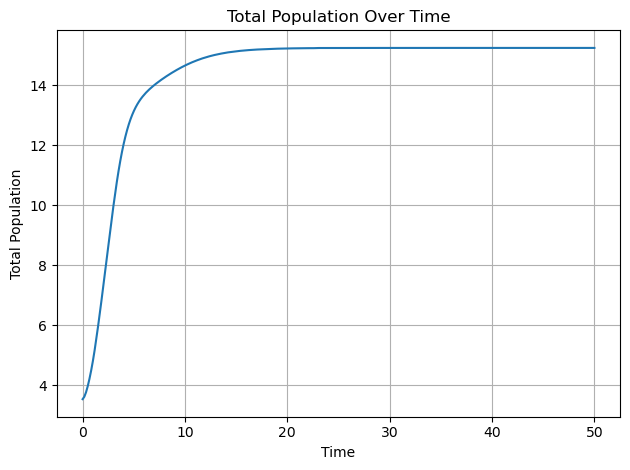

Extinct or nearly extinct species (abundance < 1e-3): [4, 8]
Estimated Fixed Point (last state): [3.12103737e+00 4.43101454e-01 2.40236057e+00 7.38652898e-40
 3.52072613e+00 3.78601276e+00 1.97981166e+00 3.12186921e-40]
Jacobian Eigenvalues at Fixed Point: [-3.97613426+0.79362403j -3.97613426-0.79362403j -4.02008175+0.j
 -0.37579404+0.j         -1.45245234+0.38680233j -1.45245234-0.38680233j
 -2.04620264+0.j         -2.23087089+0.j        ]
Stable fixed point (all eigenvalues have negative real parts).


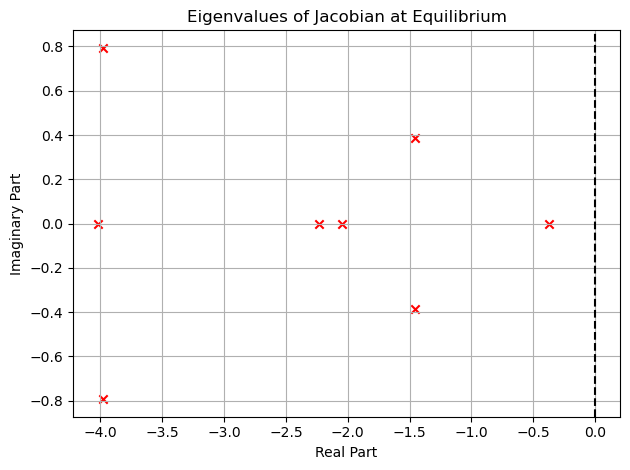

In [25]:
N = 8
np.random.seed(30)  # for reproducibility

# Uniform growth rates
r = [np.random.uniform(-0.1, 1.5) for _ in range(N)]

# Random interaction matrix (mean 0, std 0.4), zero diagonal
Sigma = np.random.normal(loc=0.0, scale=0.4, size=(N, N))
np.fill_diagonal(Sigma, 0.0)
print("Interaction matrix (Sigma): \n", Sigma)

# Optionally make it symmetric (comment out if not desired)
# Sigma = (Sigma + Sigma.T) / 2

# Initial conditions
x0 = np.random.uniform(0.1, 0.9, size=N)

# Time span
t_span = (0, 50)
t_eval = np.linspace(*t_span, 300)
simulate_and_analyze_lv(N, r, Sigma, x0, t_span, t_eval)

#### **Benhcmarking Intraspecies Competition**

This example illustrates how the **absence of intraspecies self-regulation** in one species can drive it to **dominate** the entire system — and **shape the fate of its ecological partners**. 
We construct a Lotka–Volterra system with \(N = 8\) species, where only Species 2  has a nearly null self-limiting term. We achieve this by setting $$\Sigma_{1,1}\rightarrow 1,$$ while we keep $$\Sigma_{i,i}=0 \quad \forall i\neq1.$$

As a results, we observe that:

- Species 2 rapidly grows and continues to dominate the system;
- Species 4 & 8 (positively affected by Species 2) also grow significantly, especially at later stages;
- Most of the other species exhibit transient dynamics and ultimately collapse to near-zero abundance;
- The system experiences **intermittent bursts** before complete domination occurs.

From an ecological viewpoint, we can give the follwing interpretation:

- Lack of self-regulation in Species 2 means its growth is not constrained by its own abundance, which leads to unchecked expansion, mimicking the behavior of an **invasive species**;
- Species 4 & 8 benefit from a positive interaction with Species 2 ($\Sigma_{3,1}=0.52625764 > 0, \Sigma_{7,1}=0.42203014 > 0$), which boosts their own growth;
- All other species experience negative pressure or fail to compete, eventually collapsing.

This highlights how **network topology** — especially **which species benefit from or suppress others** — critically determines long-term outcomes. 

But we should bewaret that there is one positive eigenvalue, implying the system is unstable.

This simulation shows:

- How $\Sigma_{ii} \approx 1$ can effectively eliminate self-regulation,
- How this causes explosive growth and dominance,
- How species that benefit from such a dominant species may co-prosper,
- And how a highly asymmetric and deregulated interaction matrix can drive the system toward instability.

Such cases are analogous to:
- **Invasive species** taking over ecosystems,
- **Tumor cell populations** in biological systems with disrupted feedback,
- **Runaway agents** in economic or artificial multi-agent systems.

Initial conditions (x0): [0.56855541 0.42535208 0.20898746 0.53530903 0.51454108 0.71348409
 0.84708011 0.17176271]


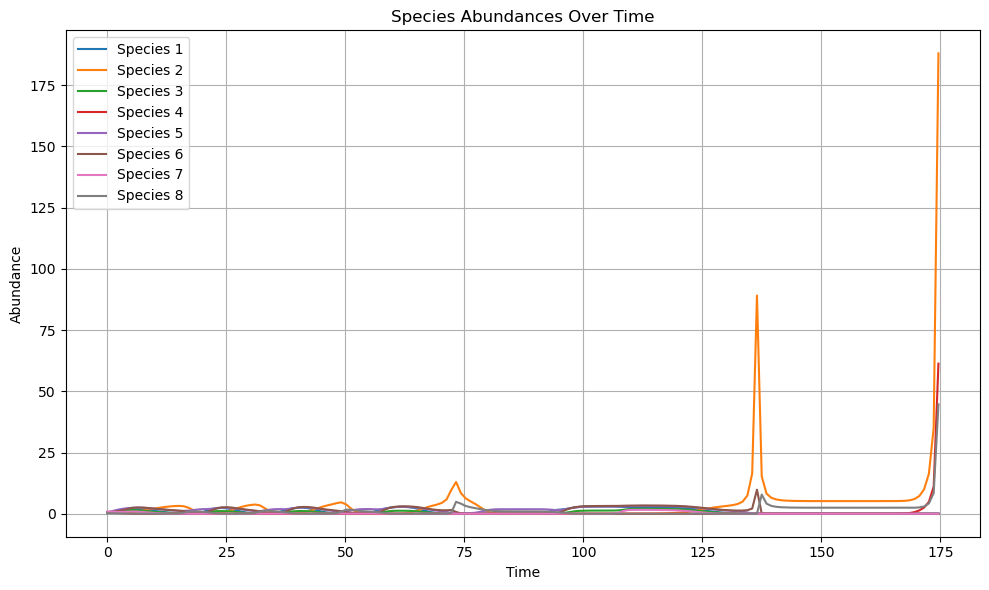

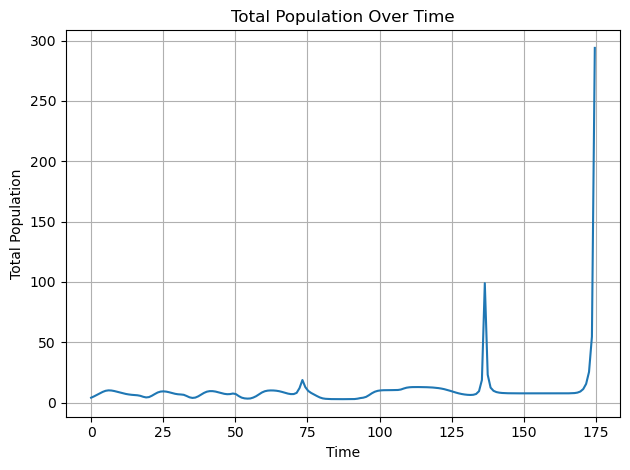

Extinct or nearly extinct species (abundance < 1e-3): [1, 2, 3, 4, 5, 6, 7, 8]
Estimated Fixed Point (last state): [-4.09879320e-22  1.88048840e+02  5.17933826e-49  6.13023269e+01
  1.19657105e-17  3.25320442e-26 -5.16798440e-07  4.46714461e+01]
Jacobian Eigenvalues at Fixed Point: [-159.29215177    6.49923569  -12.9021972   -91.00224769 -173.50251075
  -69.84621341  -57.38212529  -52.15564892]
Unstable fixed point (some eigenvalues have positive real parts).


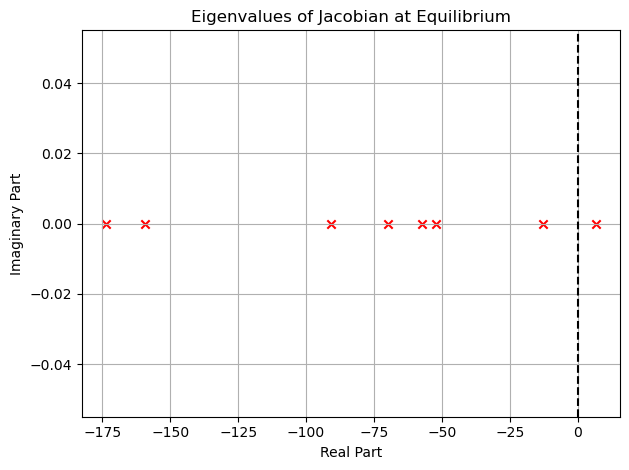

In [26]:
N = 8
np.random.seed(30)  # for reproducibility

# Uniform growth rates
r = [np.random.uniform(-0.1, 1.5) for _ in range(N)]

Sigma = np.array([
 [0.0, -0.63403815, 0.05371864, -0.44274219, 0.63129022, 0.04299918, -0.30561913, -0.3100754],
 [0.55353887, 0.99, -0.11425821, 0.21534699, -0.83355865, 0.37511268, -0.0023112, -0.18699159],
 [-0.16920612, -0.42579284, 0.0, 0.64675615, 0.57020395, -0.26590205, 0.39400714, -0.68018611],
 [-0.44005752, 0.52625764, 0.32420036, 0.0, -0.27569175, -0.34110275, 0.44538884, -0.76846789],
 [-0.28056097, -0.33963514, 0.42027992, -0.21474978, 0.0, 0.55762239, -0.15914698, 0.40765095],
 [0.75955252, 0.14193986, -0.15480659, -0.77092215, 0.22030264, 0.0, 0.3131106, -0.71729516],
 [0.4967422, -0.68309875, 0.12926136, -0.39673376, -0.46531295, -0.00853404, 0.0, -0.49724567],
 [-0.16406761, 0.42203014, -0.42292486, -0.51364689, 0.36525042, -0.55509814, 0.01201111, 0.0]
])

# Initial conditions
x0 = np.random.uniform(0.1, 0.9, size=N)
print("Initial conditions (x0):", x0)

# Time span
t_span = (0, 300)
t_eval = np.linspace(*t_span, 300)
simulate_and_analyze_lv(N, r, Sigma, x0, t_span, t_eval)

#### **Alien Invasion and Systemic Takeover**

This example simulates the invasion of an alien species (Species 2) into a pre-existing 8-species ecosystem. 

**Despite having zero intrinsic growth rate** ($r[1]=0$), the alien species manages to completely outcompete all others, demonstrating how interaction dynamics alone can lead to dominance.

Looking at the interaction matrix:
  - Row 1 (interactions exerted by the alien):  
    $$
    \Sigma_{1, \cdot} = [0.1,\ \mathbf{1},\ 0.1,\ 0.1,\ 0.1,\ 0.1,\ 0.1,\ 0.1]
    $$
    This means:
    - Species 2 experiences strong self-support (\(\Sigma_{1,1} = 1\)),
    - And gets **positive effects from all others** — possibly exploiting and manipulating them.
  
  - Column 1 (how other species are affected by the alien):  
    All values are negative, indicating **every native species is harmed** by the presence of the alien:
    $$
    \Sigma_{\cdot,1} < 0 \text{ for all } i \neq 1.
    $$

As the values above may suggest, Species 2 (the alien) rapidly grows and dominates the ecosystem, while all native species $\{1, [3,8]\}$ exhibit brief transients before collapsing to extinction. The alien stabilizes at a high, steady abundance, despite having no intrinsic growth.

This setup models an **invading species** that:
  - Relies entirely on exploiting interactions with the environment,
  - Weakens or suppresses all native competitors,
  - And thrives purely through systemic structure, not biological fitness.

It mimics real-world cases of:
  - Invasive species with strong ecological leverage,
  - Parasitic dominance in microbial or economic systems,
  - Artificially introduced agents (e.g., engineered organisms) altering dynamics.

Notice that a small positive eigenvalue confirms that the fixed point is unstable in the full system, but the alien species' dominance is practically irreversible in the current setup.

This example starkly illustrates how:
- **Interaction structure can override growth disadvantage**,
- An ecosystem can be overrun by a single agent if it is strategically embedded,
- Designing or defending ecological systems requires control over inter-species influence not just intrinsic parameters.

This "alien conquest" scenario highlights the power of asymmetry in multi-agent systems — a cautionary tale for ecology, epidemiology, economics, and artificial systems alike.


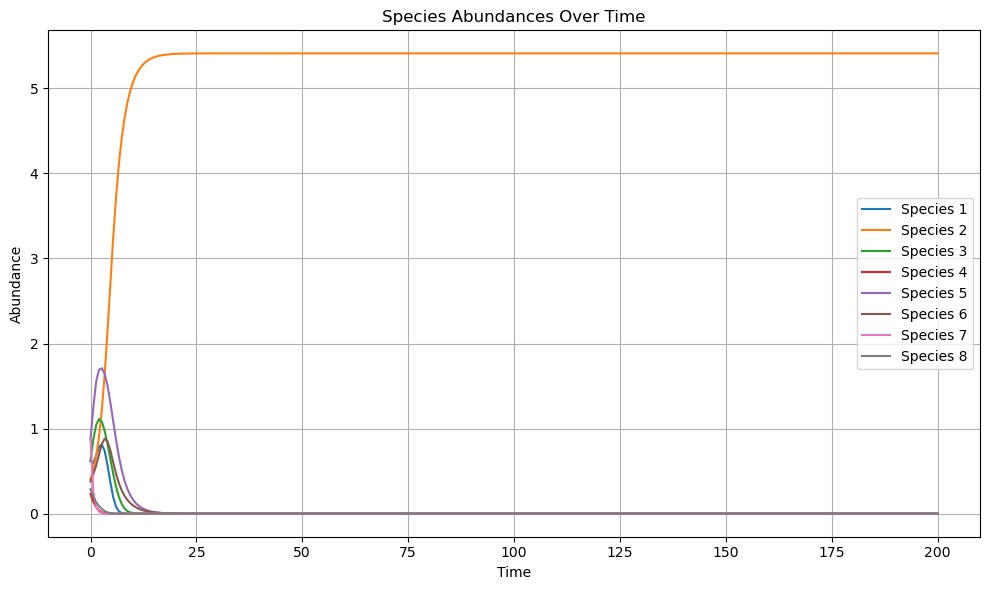

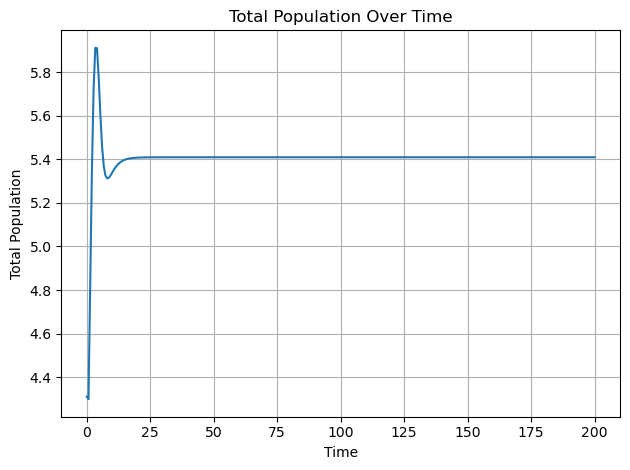

Extinct or nearly extinct species (abundance < 1e-3): [1, 3, 4, 5, 6, 7, 8]
Estimated Fixed Point (last state): [2.88726958e-185 5.40970366e+000 4.58516461e-118 1.11117850e-197
 1.44038245e-037 4.12401021e-032 5.79367388e-007 2.08458519e-172]
Jacobian Eigenvalues at Fixed Point: [-3.02995868e+00  1.03105043e-08 -4.49536292e+00 -1.40341286e+00
 -3.67852398e-01 -4.37325551e-01 -2.74689762e+00 -2.08305798e+00]
Unstable fixed point (some eigenvalues have positive real parts).


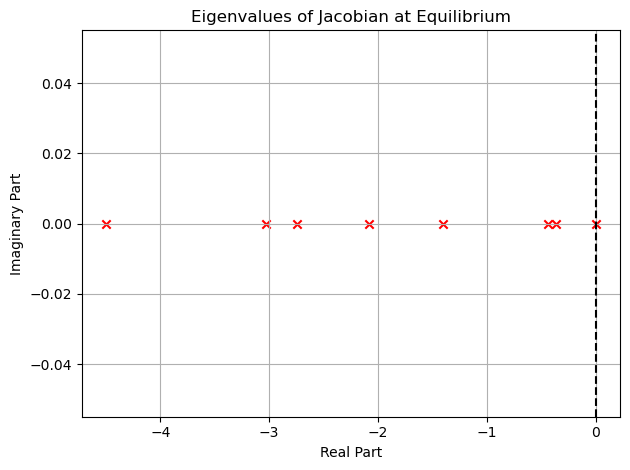

In [27]:
N = 8
np.random.seed(30)  # for reproducibility


r = [0.4, 0, 0.9, 0.1, 1.4, 0.4, -0.8, 0.2]

Sigma = np.array([
 [0.0, -0.63403815, 0.05371864, -0.44274219, 0.63129022, 0.04299918, -0.30561913, -0.3100754],
 [0.1, 1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 
 [-0.16920612, -0.42579284, 0.0, 0.64675615, 0.57020395, -0.26590205, 0.39400714, -0.68018611],
 [-0.44005752, -0.52625764, 0.32420036, 0.0, -0.27569175, -0.34110275, 0.44538884, -0.76846789],
 [-0.28056097, -0.33963514, 0.42027992, -0.21474978, 0.0, 0.55762239, -0.15914698, 0.40765095],
 [0.75955252, -0.14193986, -0.15480659, -0.77092215, 0.22030264, 0.0, 0.3131106, -0.71729516],
 [0.4967422, -0.68309875, 0.12926136, -0.39673376, -0.46531295, -0.00853404, 0.0, -0.49724567],
 [-0.16406761, -0.42203014, -0.42292486, -0.51364689, 0.36525042, -0.55509814, 0.01201111, 0.0]
])

# Initial conditions
x0 = np.random.uniform(0.1, 0.9, size=N)

# Time span
t_span = (0, 200)
t_eval = np.linspace(*t_span, 300)
simulate_and_analyze_lv(N, r, Sigma, x0, t_span, t_eval)

#### **Native Resistance Against an Alien Invader**

In this continuation of the previous "alien conquest" scenario, we introduce a **strong native competitor (Species 5)** with a high intrinsic growth rate. While the alien species (Species 2) still spreads aggressively, the new conditions lead to **partial coexistence** rather than full extinction.

Modified Parameters:

1. Growth rates:
    $$
    \mathbf{r} = [0.4,\ \mathbf{0.0},\ 0.9,\ 0.1,\ \mathbf{1.4},\ 0.4,\ -0.8,\ 0.2]
    $$
    + Species 2 (alien): no intrinsic growth
    + Species 5: high growth capacity ($r_4 = 1.4$), acting as the native resistance

2. Interaction matrix (unchanged from previous alien scenario):
    - Row 2: the alien gets positive effects from everyone
    - Column 2: all other species are negatively affected by the alien
    - Diagonal: $\Sigma_{11} = 0.99$ keeps alien growth minimally constrained

Observations:

- The alien still becomes dominant, but now:
  - Species 5 survives and stabilizes at a non-zero abundance
  - Other species (1, 3, 4, 7, 8) go extinct
  - Species 6 also survives in small amounts due to indirect interactions

- This case represents **partial resilience**, where one or two ecologically strong native species resist the collapse.

This pattern occurs in:
- Ecosystems where certain species are **keystone defenders**,
- Microbial systems with **probiotic resistance**,
- Societal or economic systems where local hubs survive global shocks.

Notice that all real parts of the eigenvalues are negative, hence the system is locally asymptotically stable.

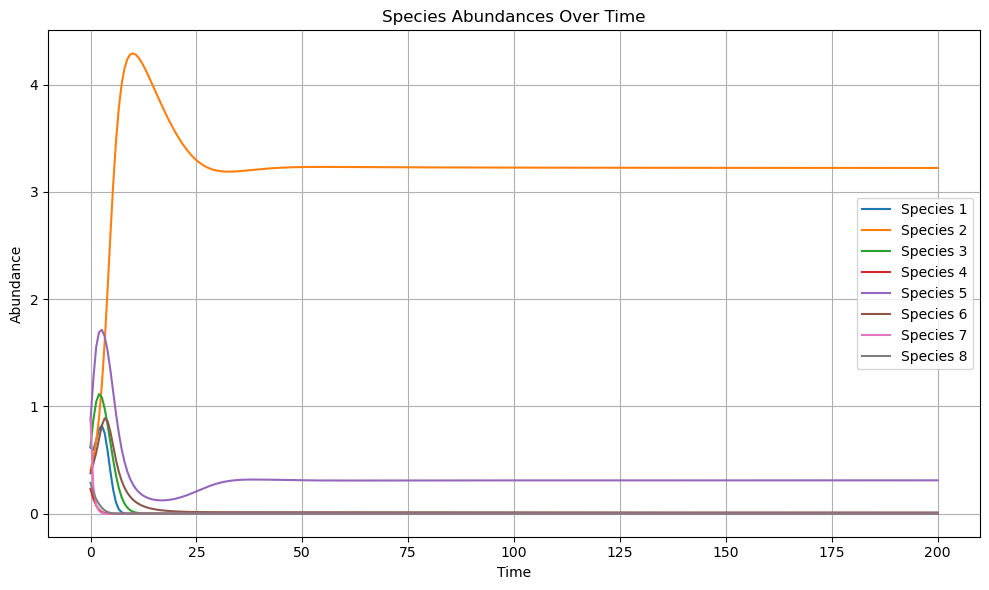

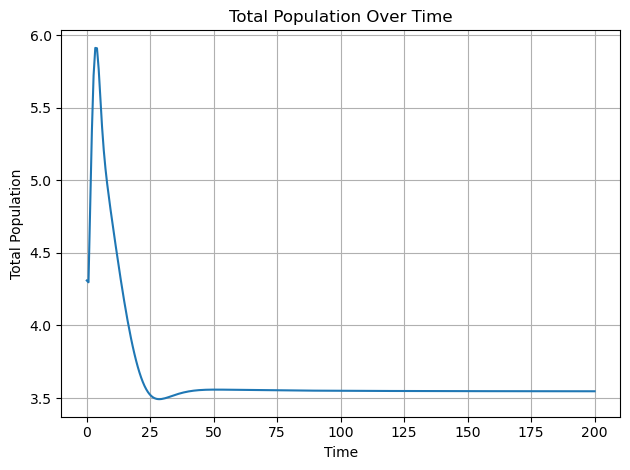

Extinct or nearly extinct species (abundance < 1e-3): [1, 3, 4, 7, 8]
Estimated Fixed Point (last state): [6.53547176e-121 3.22404652e+000 2.30321550e-029 1.80502153e-137
 3.11216163e-001 1.11585662e-002 3.68180333e-007 1.82844127e-094]
Jacobian Eigenvalues at Fixed Point: [-1.44722108+0.j         -0.16753913+0.11582898j -0.16753913-0.11582898j
 -0.01975077+0.j         -3.147251  +0.j         -0.29828618+0.j
 -1.6862849 +0.j         -1.05316707+0.j        ]
Stable fixed point (all eigenvalues have negative real parts).


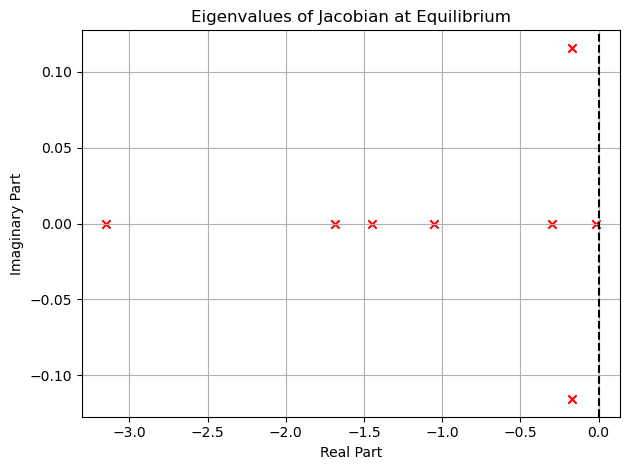

In [28]:
N = 8
np.random.seed(30)  # for reproducibility


r = [0.4, 0, 0.9, 0.1, 1.4, 0.4, -0.8, 0.2]

Sigma = np.array([
 [0.0, -0.63403815, 0.05371864, -0.44274219, 0.63129022, 0.04299918, -0.30561913, -0.3100754],
 [0.1, 0.99, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 
 [-0.16920612, -0.42579284, 0.0, 0.64675615, 0.57020395, -0.26590205, 0.39400714, -0.68018611],
 [-0.44005752, -0.52625764, 0.32420036, 0.0, -0.27569175, -0.34110275, 0.44538884, -0.76846789],
 [-0.28056097, -0.33963514, 0.42027992, -0.21474978, 0.0, 0.55762239, -0.15914698, 0.40765095],
 [0.75955252, -0.14193986, -0.15480659, -0.77092215, 0.22030264, 0.0, 0.3131106, -0.71729516],
 [0.4967422, -0.68309875, 0.12926136, -0.39673376, -0.46531295, -0.00853404, 0.0, -0.49724567],
 [-0.16406761, -0.42203014, -0.42292486, -0.51364689, 0.36525042, -0.55509814, 0.01201111, 0.0]
])

# Initial conditions
x0 = np.random.uniform(0.1, 0.9, size=N)

# Time span
t_span = (0, 200)
t_eval = np.linspace(*t_span, 300)
simulate_and_analyze_lv(N, r, Sigma, x0, t_span, t_eval)

#### **Dynamic Coexistence Despite Alien Pressure**

This example extends the alien invasion scenario by tuning Species 5 to also have:

- A strong growth rate,
- Low self-regulation ($\Sigma_{44} = 0.99$),
- Positive interactions from most other species,
- But it is negatively affected by the alien (Species 2).

We aim to investigate whether Species 5 can coexist with the invader despite this disadvantage — and under what conditions oscillatory coexistence might emerge.

Parameters:

1. Growth rates:
  $$
  \mathbf{r} = [0.4,\ \mathbf{0.0},\ 0.9,\ 0.1,\ \mathbf{1.0},\ 0.4,\ -0.8,\ 0.2]
  $$

2. Interaction matrix (key properties):
  - $\Sigma_{11} = 0.99$ (alien self-regulation nearly null),
  - $\Sigma_{44} = 0.99$ (Species 5 also with weak self-regulation),
  - Row 4 (effects on Species 5): positive from most species,
  - Column 4: exerts negative influence from most species, *except** Species 2.

Observations:

- Species 2 (alien) reaches and stabilizes at a high abundance.
- Species 5 survives and oscillates for a long time, eventually settling at a lower but stable value.
- All other species (1, 3, 4, 6, 7, 8) become extinct or nearly so.

This is a clear instance of **partial dominance** with **stable coexistence** between one aggressive invader and one resilient native.

Species 5’s survival, despite alien hostility, is enabled by:
  - A strong intrinsic growth rate ($r[4] = 1.0$),
  - Broad ecological support from other species,
  - Minimal self-competition, allowing rapid expansion when conditions are favorable.

The alien harms all other species (negative column 1), but Species 5 resists collapse due to these internal structural advantages.

This situation reflects:
- Ecological resistance through structural embedding,
- **Mutualistic buffering** that delays extinction or collapse,
- Emergent oscillatory dynamics leading to long-term equilibrium.

For what regards eigenvalues, all real parts are negative, hence the fixed point is asymptotically stable, and the complex pair causes transient oscillations.

This finely tuned example shows that oscillations often precede stable coexistence, and negative interactions from invaders can be buffered by collective ecological support.

It illustrates a realistic case of **resilient survival**, where a native species finds a niche in a hostile environment.


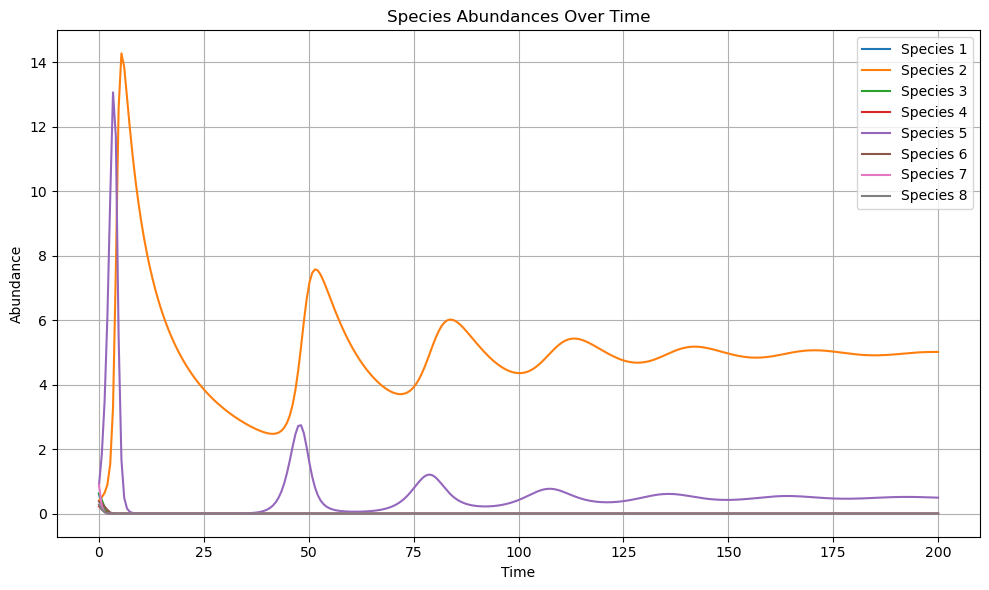

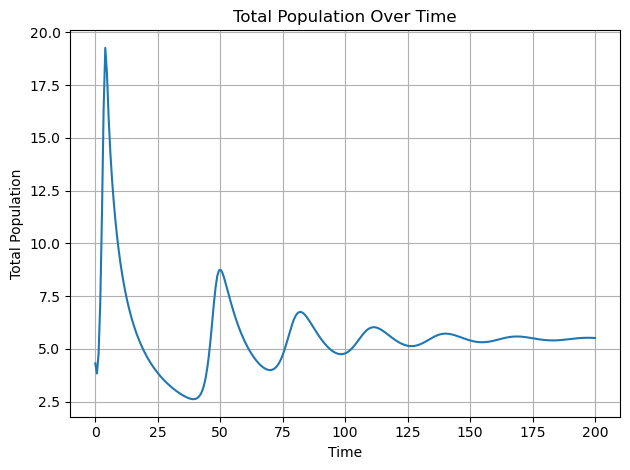

Extinct or nearly extinct species (abundance < 1e-3): [1, 3, 4, 5, 6, 7, 8]
Estimated Fixed Point (last state): [3.73633230e-185 5.01702402e+000 3.41791189e-134 2.82746690e-202
 4.97544835e-001 6.70372717e-040 2.92605390e-006 4.03425736e-180]
Jacobian Eigenvalues at Fixed Point: [-3.09508071+0.j         -0.03197068+0.22265974j -0.03197068-0.22265974j
 -4.4586425 +0.j         -1.51991379+0.j         -2.67741493+0.j
 -0.42172521+0.j         -2.09906378+0.j        ]
Stable fixed point (all eigenvalues have negative real parts).


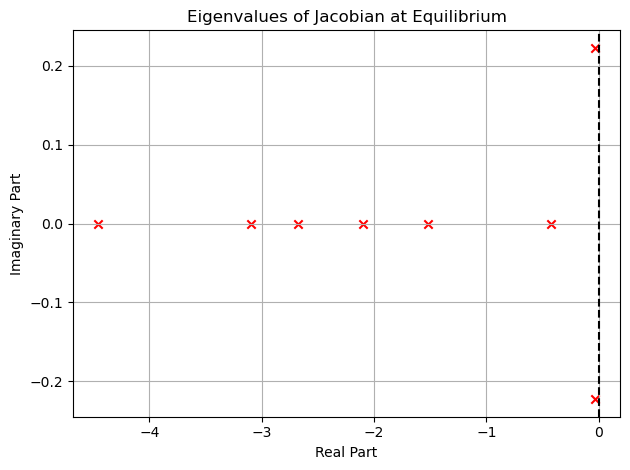

In [29]:
N = 8
np.random.seed(30)  # for reproducibility


r = [0.4, 0, 0.9, 0.1, 1, 0.4,-0.8, 0.2]

Sigma = np.array([
 [0.0, -0.63403815, 0.05371864, -0.44274219, -0.63129022, 0.04299918, -0.30561913, -0.3100754],
 [0.1, 0.99, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], 
 [-0.16920612, -0.42579284, 0.0, 0.64675615, -0.57020395, -0.26590205, 0.39400714, -0.68018611],
 [-0.44005752, -0.52625764, 0.32420036, 0.0, -0.27569175, -0.34110275, 0.44538884, -0.76846789],
 [0.1, -0.2, 0.1, 0.1, 0.99, 0.1, 0.1, 0.1],
 [0.75955252, -0.14193986, -0.15480659, -0.77092215, -0.22030264, 0.0, 0.3131106, -0.71729516],
 [0.4967422, -0.68309875, 0.12926136, -0.39673376, -0.46531295, -0.00853404, 0.0, -0.49724567],
 [-0.16406761, -0.42203014, -0.42292486, -0.51364689, -0.36525042, -0.55509814, 0.01201111, 0.0]
])

# Initial conditions
x0 = np.random.uniform(0.1, 0.9, size=N)

# Time span
t_span = (0, 200)
t_eval = np.linspace(*t_span, 300)
simulate_and_analyze_lv(N, r, Sigma, x0, t_span, t_eval)

## **FINAL COMMENTS**

In this notebook, we have conducted an extensive exploration of the generalized Lotka-Volterra (LV) model, showcasing its flexibility, complexity, and relevance for modeling ecological dynamics. By varying the number of species, interaction strengths, self-regulation parameters, and initial conditions, we captured a rich spectrum of possible behaviors.

**Key Takeaways:**

- Dynamical richness: The LV system exhibits a wide range of outcomes — from stable equilibria and oscillations to extinctions and chaotic bursts — driven by simple rules of interaction.
- Role of parameters: Stability and species survival are highly sensitive to:
  - The interaction matrix $\Sigma$, especially its diagonal (self-regulation).
  - The growth vector $ \mathbf{r} $, which determines intrinsic fitness.
  - The structure of positive vs. negative feedback loops in the community.
- Extinction mechanisms: Even with favorable intrinsic growth, a species can go extinct due to competitive pressure, while invaders with no growth advantage can dominate through favorable interactions.
- Numerical behavior: We observed edge cases like “resurrected” species, highlighting the need to interpret simulation results with awareness of computational precision and model assumptions.

With its mathematical elegance, the LV framework captures essential mechanisms of population ecology:
- Competition, mutualism, and predation are all embedded via the interaction matrix.
- Diversity dynamics can be assessed through measures like the Shannon index.
- Invasion ecology and coexistence theory emerge naturally in multi-species setups.

By systematically experimenting across parameter regimes and ecological scenarios — from minimal 3-species systems to complex 10-species networks — we have demonstrated that the LV model is not only a cornerstone of theoretical ecology but also a fertile ground for discovering emergent dynamics.

This notebook provides a computational laboratory for studying these dynamics and may serve as a stepping stone for further ecological modeling, such as:
- Adding spatial heterogeneity,
- Incorporating stochasticity,
- Or extending to nonlinear or trophic interaction structures.